# Problem formulation: Non-linear constraint optimization

The objective function is defined as the combination of net revenue and the penalty for discount lambda, to maximize net revenue and minimize discount:

$$ \min f() = - NR - \lambda * discount $$

Subject to:

- Non-linear & inequality constraints:
    - $f(\text{Promotional discount} + \text{Other discount}) \leq $ Max_discount
    - $\text{min vol variation constraint} \leq \text{actual volume variation} \leq \text{max vol variation constraint}$
    - Positive net revenue imposed: $NR \geq 0$

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import pulp

import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Aneur\Miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Aneur\Miniconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\Aneur\Miniconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Constraints

In [2]:
vol_var_const_df = pd.read_excel("Input Data/volume_variation_constraint_hackathon.xlsx")
vol_var_const_df.head()

SKU   Brand    Pack    Size  Minimum Volume Variation  \
0  jpXhdU  LoYUOg  mmgsXK  StircS                 -0.595874   
1  ykzJnG  OmUaam  mmgsXK  CTOGzl                 -0.389015   
2  mFEENn  YZfPPf  gydWlH  StircS                 -0.384432   
3  EWpIvF  ddBknG  mmgsXK  StircS                 -0.383206   
4  NDjGwG  aYZJQW  VmwBmS  pKILVK                 -0.382353   

   Maximum Volume Variation  
0                  0.365638  
1                  0.298220  
2                  0.343191  
3                  0.309620  
4                  0.245059

In [3]:
max_discount_const_brand = pd.read_excel("Input Data/maximum_discount_constraint_hackathon.xlsx", sheet_name="Brand")
max_discount_const_brand.rename(columns={"max_discount":"max_discount_brand"}, inplace=True)
max_discount_const_pack = pd.read_excel("Input Data/maximum_discount_constraint_hackathon.xlsx", sheet_name="Pack")
max_discount_const_pack.rename(columns={"max_discount":"max_discount_pack"}, inplace=True)
max_discount_const_price_segment = pd.read_excel("Input Data/maximum_discount_constraint_hackathon.xlsx", sheet_name="PriceSegment")
max_discount_const_price_segment.rename(columns={"max_discount":"max_discount_segment"}, inplace=True)
max_discount_const_price_segment.head()

Year  Month PriceSegment  max_discount_segment
0  2023      6       FkcKlo         -7.075328e+09
1  2023      6       qtUPAJ         -4.217010e+09
2  2023      6       rBvOre         -1.402168e+10
3  2023      6       zLdfYx         -3.566363e+10
4  2023      7       FkcKlo         -7.727772e+09

In [4]:
brand_price_segment = pd.read_excel("Input Data/brand_segment_mapping_hackathon.xlsx")
max_discount_const_brand = max_discount_const_brand.merge(brand_price_segment, how='left')
max_discount_const_brand = max_discount_const_brand.merge(max_discount_const_price_segment, how='left')
max_discount_const_brand

Year  Month   Brand  max_discount_brand PriceSegment  max_discount_segment
0   2023      6  FPgJHY       -2.340258e+08       rBvOre         -1.402168e+10
1   2023      6  FnpxCq       -1.077114e+08       qtUPAJ         -4.217010e+09
2   2023      6  JKAQQU       -1.969668e+09       zLdfYx         -3.566363e+10
3   2023      6  JcucVL       -2.169168e+07       qtUPAJ         -4.217010e+09
4   2023      6  LoYUOg       -2.792598e+08       FkcKlo         -7.075328e+09
..   ...    ...     ...                 ...          ...                   ...
59  2023      7  pspMdo       -1.215235e+09       qtUPAJ         -4.535993e+09
60  2023      7  pugybN       -1.550623e+05       rBvOre         -1.569308e+10
61  2023      7  tcqKyp       -6.375197e+06       rBvOre         -1.569308e+10
62  2023      7  vAKBcH       -4.664660e+07       zLdfYx         -3.560526e+10
63  2023      7  wXKDHy       -1.147356e+09       FkcKlo         -7.727772e+09

[64 rows x 6 columns]

# Predictions df for month 6

In [5]:
barrier_df = pd.read_csv("Curves_month_6_predicton_300.csv")
barrier_df.head()

SKU  month      discount  Volume_Htls_month_6_discount  \
0  AjMMHY      6  0.000000e+00                   1803.619012   
1  AjMMHY      6 -1.459029e+07                   3040.633519   
2  AjMMHY      6 -2.918058e+07                   3425.539457   
3  AjMMHY      6 -4.377087e+07                   3690.791985   
4  AjMMHY      6 -5.836116e+07                   3689.736192   

   Volume_Htls_month_6_other_discount   Brand    Pack      Price_Htl  \
0                            0.646017  ZVDcKH  GUbqnp  580347.476104   
1                          212.116020  ZVDcKH  GUbqnp  580347.476104   
2                          445.927041  ZVDcKH  GUbqnp  580347.476104   
3                          425.377329  ZVDcKH  GUbqnp  580347.476104   
4                          419.709056  ZVDcKH  GUbqnp  580347.476104   

        VILC_LC  Net_Revenue_LC_6_discount  Net_Revenue_LC_6_other_discount  \
0  1.601311e+09               1.046726e+09                     3.749146e+05   
1  1.601311e+09               1.764624e+09                     1.231010e+08   
2  1.601311e+09               1.988003e+09                     2.587926e+08   
3  1.601311e+09               2.141942e+09                     2.468667e+08   
4  1.601311e+09               2.141329e+09                     2.435771e+08   

   MACO_LC_6_discount  MACO_LC_6_other_discount  
0       -5.545855e+08             -1.600936e+09  
1        1.633127e+08             -1.478210e+09  
2        3.866919e+08             -1.342519e+09  
3        5.406306e+08             -1.354445e+09  
4        5.400178e+08             -1.357734e+09

Bring the last month's volume data

In [6]:
sales_df = pd.read_excel("Input Data/sales_data_hackathon.xlsx")
sales_df = sales_df[['SKU', 'Year', 'Month', 'Volume_Htls']]
sales_df = sales_df[(sales_df['Year']==2023) & (sales_df['Month']==5)]
sales_df.rename(columns={"Volume_Htls":"Volume_Htls_prev_month"}, inplace=True)
sales_df.head()

SKU  Year  Month  Volume_Htls_prev_month
98   yvlFSF  2023      5                  214.41
158  DYnHEw  2023      5                10364.54
210  hAjjKL  2023      5                    0.41
264  yEDccP  2023      5                    7.83
319  mRxjWU  2023      5                57672.67

In [7]:
barrier_df = barrier_df.merge(sales_df[['SKU','Volume_Htls_prev_month']], how="left", on="SKU")
barrier_df['actual_volume_variation'] = ((barrier_df['Volume_Htls_month_6_discount']+barrier_df['Volume_Htls_month_6_other_discount'])-barrier_df['Volume_Htls_prev_month']) / barrier_df['Volume_Htls_prev_month']
barrier_df.head()

SKU  month      discount  Volume_Htls_month_6_discount  \
0  AjMMHY      6  0.000000e+00                   1803.619012   
1  AjMMHY      6 -1.459029e+07                   3040.633519   
2  AjMMHY      6 -2.918058e+07                   3425.539457   
3  AjMMHY      6 -4.377087e+07                   3690.791985   
4  AjMMHY      6 -5.836116e+07                   3689.736192   

   Volume_Htls_month_6_other_discount   Brand    Pack      Price_Htl  \
0                            0.646017  ZVDcKH  GUbqnp  580347.476104   
1                          212.116020  ZVDcKH  GUbqnp  580347.476104   
2                          445.927041  ZVDcKH  GUbqnp  580347.476104   
3                          425.377329  ZVDcKH  GUbqnp  580347.476104   
4                          419.709056  ZVDcKH  GUbqnp  580347.476104   

        VILC_LC  Net_Revenue_LC_6_discount  Net_Revenue_LC_6_other_discount  \
0  1.601311e+09               1.046726e+09                     3.749146e+05   
1  1.601311e+09               1.764624e+09                     1.231010e+08   
2  1.601311e+09               1.988003e+09                     2.587926e+08   
3  1.601311e+09               2.141942e+09                     2.468667e+08   
4  1.601311e+09               2.141329e+09                     2.435771e+08   

   MACO_LC_6_discount  MACO_LC_6_other_discount  Volume_Htls_prev_month  \
0       -5.545855e+08             -1.600936e+09                 4031.35   
1        1.633127e+08             -1.478210e+09                 4031.35   
2        3.866919e+08             -1.342519e+09                 4031.35   
3        5.406306e+08             -1.354445e+09                 4031.35   
4        5.400178e+08             -1.357734e+09                 4031.35   

   actual_volume_variation  
0                -0.552441  
1                -0.193136  
2                -0.039660  
3                 0.021040  
4                 0.019372

Add volume variation constraint

In [8]:
barrier_df2 = barrier_df.merge(vol_var_const_df[['SKU','Size','Minimum Volume Variation',
                                                 "Maximum Volume Variation"]], 
                                how="left", on="SKU")
barrier_df2.rename(columns={'Minimum Volume Variation':'min_vol_variation_constraint',
                            "Maximum Volume Variation":'max_vol_variation_constraint'},inplace=True)

# Fill na values from the volume variation dataset
barrier_df2['min_vol_variation_constraint'] = barrier_df2['min_vol_variation_constraint'].fillna(0) # Ensure a positive outlook on volume variation

max_percentage = 0.091
barrier_df2['max_vol_variation_constraint'] = barrier_df2['max_vol_variation_constraint'].apply(lambda x: min(x, max_percentage))
barrier_df2['max_vol_variation_constraint'].fillna(max_percentage, inplace=True)

barrier_df2['Size'] = barrier_df2['Size'].fillna("")
barrier_df2

SKU  month      discount  Volume_Htls_month_6_discount  \
0      AjMMHY      6  0.000000e+00                   1803.619012   
1      AjMMHY      6 -1.459029e+07                   3040.633519   
2      AjMMHY      6 -2.918058e+07                   3425.539457   
3      AjMMHY      6 -4.377087e+07                   3690.791985   
4      AjMMHY      6 -5.836116e+07                   3689.736192   
...       ...    ...           ...                           ...   
22805  ztGEho      6 -1.173146e+10                  10152.248792   
22806  ztGEho      6 -1.177123e+10                  10152.248792   
22807  ztGEho      6 -1.181099e+10                  10152.248792   
22808  ztGEho      6 -1.185076e+10                  10152.248792   
22809  ztGEho      6 -1.189053e+10                  10152.248792   

       Volume_Htls_month_6_other_discount   Brand    Pack      Price_Htl  \
0                                0.646017  ZVDcKH  GUbqnp  580347.476104   
1                              212.116020  ZVDcKH  GUbqnp  580347.476104   
2                              445.927041  ZVDcKH  GUbqnp  580347.476104   
3                              425.377329  ZVDcKH  GUbqnp  580347.476104   
4                              419.709056  ZVDcKH  GUbqnp  580347.476104   
...                                   ...     ...     ...            ...   
22805                        40269.117899  oKraYa  GUbqnp  512090.249806   
22806                        40269.117899  oKraYa  GUbqnp  512090.249806   
22807                        40269.117899  oKraYa  GUbqnp  512090.249806   
22808                        40269.117899  oKraYa  GUbqnp  512090.249806   
22809                        40269.117899  oKraYa  GUbqnp  512090.249806   

            VILC_LC  Net_Revenue_LC_6_discount  \
0      1.601311e+09               1.046726e+09   
1      1.601311e+09               1.764624e+09   
2      1.601311e+09               1.988003e+09   
3      1.601311e+09               2.141942e+09   
4      1.601311e+09               2.141329e+09   
...             ...                        ...   
22805  1.884897e+09               5.198868e+09   
22806  1.884897e+09               5.198868e+09   
22807  1.884897e+09               5.198868e+09   
22808  1.884897e+09               5.198868e+09   
22809  1.884897e+09               5.198868e+09   

       Net_Revenue_LC_6_other_discount  MACO_LC_6_discount  \
0                         3.749146e+05       -5.545855e+08   
1                         1.231010e+08        1.633127e+08   
2                         2.587926e+08        3.866919e+08   
3                         2.468667e+08        5.406306e+08   
4                         2.435771e+08        5.400178e+08   
...                                ...                 ...   
22805                     2.062142e+10        3.313970e+09   
22806                     2.062142e+10        3.313970e+09   
22807                     2.062142e+10        3.313970e+09   
22808                     2.062142e+10        3.313970e+09   
22809                     2.062142e+10        3.313970e+09   

       MACO_LC_6_other_discount  Volume_Htls_prev_month  \
0                 -1.600936e+09                 4031.35   
1                 -1.478210e+09                 4031.35   
2                 -1.342519e+09                 4031.35   
3                 -1.354445e+09                 4031.35   
4                 -1.357734e+09                 4031.35   
...                         ...                     ...   
22805              1.873653e+10                 8132.90   
22806              1.873653e+10                 8132.90   
22807              1.873653e+10                 8132.90   
22808              1.873653e+10                 8132.90   
22809              1.873653e+10                 8132.90   

       actual_volume_variation    Size  min_vol_variation_constraint  \
0                    -0.552441                              0.000000   
1                    -0.193136                              0.000000   
2        

Add the maximum possible discount to be given 

In [9]:
max_discount_const_brand['month'] = max_discount_const_brand['Month'].astype(int)
del max_discount_const_brand['Month']
del max_discount_const_brand['Year']
barrier_df3 = barrier_df2.merge(max_discount_const_brand, how="left")
barrier_df3

SKU  month      discount  Volume_Htls_month_6_discount  \
0      AjMMHY      6  0.000000e+00                   1803.619012   
1      AjMMHY      6 -1.459029e+07                   3040.633519   
2      AjMMHY      6 -2.918058e+07                   3425.539457   
3      AjMMHY      6 -4.377087e+07                   3690.791985   
4      AjMMHY      6 -5.836116e+07                   3689.736192   
...       ...    ...           ...                           ...   
22805  ztGEho      6 -1.173146e+10                  10152.248792   
22806  ztGEho      6 -1.177123e+10                  10152.248792   
22807  ztGEho      6 -1.181099e+10                  10152.248792   
22808  ztGEho      6 -1.185076e+10                  10152.248792   
22809  ztGEho      6 -1.189053e+10                  10152.248792   

       Volume_Htls_month_6_other_discount   Brand    Pack      Price_Htl  \
0                                0.646017  ZVDcKH  GUbqnp  580347.476104   
1                              212.116020  ZVDcKH  GUbqnp  580347.476104   
2                              445.927041  ZVDcKH  GUbqnp  580347.476104   
3                              425.377329  ZVDcKH  GUbqnp  580347.476104   
4                              419.709056  ZVDcKH  GUbqnp  580347.476104   
...                                   ...     ...     ...            ...   
22805                        40269.117899  oKraYa  GUbqnp  512090.249806   
22806                        40269.117899  oKraYa  GUbqnp  512090.249806   
22807                        40269.117899  oKraYa  GUbqnp  512090.249806   
22808                        40269.117899  oKraYa  GUbqnp  512090.249806   
22809                        40269.117899  oKraYa  GUbqnp  512090.249806   

            VILC_LC  Net_Revenue_LC_6_discount  ...  MACO_LC_6_discount  \
0      1.601311e+09               1.046726e+09  ...       -5.545855e+08   
1      1.601311e+09               1.764624e+09  ...        1.633127e+08   
2      1.601311e+09               1.988003e+09  ...        3.866919e+08   
3      1.601311e+09               2.141942e+09  ...        5.406306e+08   
4      1.601311e+09               2.141329e+09  ...        5.400178e+08   
...             ...                        ...  ...                 ...   
22805  1.884897e+09               5.198868e+09  ...        3.313970e+09   
22806  1.884897e+09               5.198868e+09  ...        3.313970e+09   
22807  1.884897e+09               5.198868e+09  ...        3.313970e+09   
22808  1.884897e+09               5.198868e+09  ...        3.313970e+09   
22809  1.884897e+09               5.198868e+09  ...        3.313970e+09   

       MACO_LC_6_other_discount  Volume_Htls_prev_month  \
0                 -1.600936e+09                 4031.35   
1                 -1.478210e+09                 4031.35   
2                 -1.342519e+09                 4031.35   
3                 -1.354445e+09                 4031.35   
4                 -1.357734e+09                 4031.35   
...                         ...                     ...   
22805              1.873653e+10                 8132.90   
22806              1.873653e+10                 8132.90   
22807              1.873653e+10                 8132.90   
22808              1.873653e+10                 8132.90   
22809              1.873653e+10                 8132.90   

       actual_volume_variation    Size min_vol_variation_constraint  \
0                    -0.552441                             0.000000   
1                    -0.193136                             0.000000   
2                    -0.039660                             0.000000   
3                     0.021040                             0.000000   
4                     0.019372                             0.000000   
...                        ...     ...                          ...   
22805                 5.199679  drgWuE                    -0.541302   
22806                 5.199679  drgWuE                    -0.541302   
22807                 5.199679 

In [10]:
barrier_df3.columns

Index(['SKU', 'month', 'discount', 'Volume_Htls_month_6_discount',
       'Volume_Htls_month_6_other_discount', 'Brand', 'Pack', 'Price_Htl',
       'VILC_LC', 'Net_Revenue_LC_6_discount',
       'Net_Revenue_LC_6_other_discount', 'MACO_LC_6_discount',
       'MACO_LC_6_other_discount', 'Volume_Htls_prev_month',
       'actual_volume_variation', 'Size', 'min_vol_variation_constraint',
       'max_vol_variation_constraint', 'max_discount_brand', 'PriceSegment',
       'max_discount_segment'],
      dtype='object')

In [11]:
barrier_df3[['discount', 'Volume_Htls_month_6_discount',
   'Volume_Htls_month_6_other_discount', 'Price_Htl',
   'VILC_LC', 'Net_Revenue_LC_6_discount',
   'Net_Revenue_LC_6_other_discount']] = barrier_df3[['discount', 'Volume_Htls_month_6_discount',
   'Volume_Htls_month_6_other_discount', 'Price_Htl',
   'VILC_LC', 'Net_Revenue_LC_6_discount',
   'Net_Revenue_LC_6_other_discount']].replace('#NAME?', 0).astype(float)

In [12]:
barrier_df4 = barrier_df3[barrier_df3.SKU == "AjMMHY"]
barrier_df4

SKU  month      discount  Volume_Htls_month_6_discount  \
0    AjMMHY      6  0.000000e+00                   1803.619012   
1    AjMMHY      6 -1.459029e+07                   3040.633519   
2    AjMMHY      6 -2.918058e+07                   3425.539457   
3    AjMMHY      6 -4.377087e+07                   3690.791985   
4    AjMMHY      6 -5.836116e+07                   3689.736192   
..      ...    ...           ...                           ...   
295  AjMMHY      6 -4.304136e+09                   8220.138262   
296  AjMMHY      6 -4.318726e+09                   8220.138262   
297  AjMMHY      6 -4.333316e+09                   8220.138262   
298  AjMMHY      6 -4.347907e+09                   8220.138262   
299  AjMMHY      6 -4.362497e+09                   8220.138262   

     Volume_Htls_month_6_other_discount   Brand    Pack      Price_Htl  \
0                              0.646017  ZVDcKH  GUbqnp  580347.476104   
1                            212.116020  ZVDcKH  GUbqnp  580347.476104   
2                            445.927041  ZVDcKH  GUbqnp  580347.476104   
3                            425.377329  ZVDcKH  GUbqnp  580347.476104   
4                            419.709056  ZVDcKH  GUbqnp  580347.476104   
..                                  ...     ...     ...            ...   
295                         6469.534441  ZVDcKH  GUbqnp  580347.476104   
296                         6469.534441  ZVDcKH  GUbqnp  580347.476104   
297                         6469.534441  ZVDcKH  GUbqnp  580347.476104   
298                         6469.534441  ZVDcKH  GUbqnp  580347.476104   
299                         6469.534441  ZVDcKH  GUbqnp  580347.476104   

          VILC_LC  Net_Revenue_LC_6_discount  ...  MACO_LC_6_discount  \
0    1.601311e+09               1.046726e+09  ...       -5.545855e+08   
1    1.601311e+09               1.764624e+09  ...        1.633127e+08   
2    1.601311e+09               1.988003e+09  ...        3.866919e+08   
3    1.601311e+09               2.141942e+09  ...        5.406306e+08   
4    1.601311e+09               2.141329e+09  ...        5.400178e+08   
..            ...                        ...  ...                 ...   
295  1.601311e+09               4.770536e+09  ...        3.169225e+09   
296  1.601311e+09               4.770536e+09  ...        3.169225e+09   
297  1.601311e+09               4.770536e+09  ...        3.169225e+09   
298  1.601311e+09               4.770536e+09  ...        3.169225e+09   
299  1.601311e+09               4.770536e+09  ...        3.169225e+09   

     MACO_LC_6_other_discount  Volume_Htls_prev_month  \
0               -1.600936e+09                 4031.35   
1               -1.478210e+09                 4031.35   
2               -1.342519e+09                 4031.35   
3               -1.354445e+09                 4031.35   
4               -1.357734e+09                 4031.35   
..                        ...                     ...   
295              2.153267e+09                 4031.35   
296              2.153267e+09                 4031.35   
297              2.153267e+09                 4031.35   
298              2.153267e+09                 4031.35   
299              2.153267e+09                 4031.35   

     actual_volume_variation  Size min_vol_variation_constraint  \
0                  -0.552441                                0.0   
1                  -0.193136                                0.0   
2                  -0.039660                                0.0   
3                   0.021040                                0.0   
4                   0.019372                                0.0   
..                       ...   ...                          ...   
295                 2.643859                                0.0   
296                 2.643859                                0.0   
297                 2.643859                                0.0   
298                 2.643859                                0.0   
299                 2.64385

In [13]:
barrier_df4.columns

Index(['SKU', 'month', 'discount', 'Volume_Htls_month_6_discount',
       'Volume_Htls_month_6_other_discount', 'Brand', 'Pack', 'Price_Htl',
       'VILC_LC', 'Net_Revenue_LC_6_discount',
       'Net_Revenue_LC_6_other_discount', 'MACO_LC_6_discount',
       'MACO_LC_6_other_discount', 'Volume_Htls_prev_month',
       'actual_volume_variation', 'Size', 'min_vol_variation_constraint',
       'max_vol_variation_constraint', 'max_discount_brand', 'PriceSegment',
       'max_discount_segment'],
      dtype='object')

In [14]:
df = barrier_df4.copy()
df = df[(df.actual_volume_variation >= df.min_vol_variation_constraint) & \
        (df.actual_volume_variation <= df.max_vol_variation_constraint) & \
        (df.discount >= df.max_discount_brand)]
df.shape

(2, 21)

The shape of the entry data to the optimizer is significantly reduced when some of the constraints are imposed by brute force.

In [15]:
df

SKU  month      discount  Volume_Htls_month_6_discount  \
3  AjMMHY      6 -4.377087e+07                   3690.791985   
4  AjMMHY      6 -5.836116e+07                   3689.736192   

   Volume_Htls_month_6_other_discount   Brand    Pack      Price_Htl  \
3                          425.377329  ZVDcKH  GUbqnp  580347.476104   
4                          419.709056  ZVDcKH  GUbqnp  580347.476104   

        VILC_LC  Net_Revenue_LC_6_discount  ...  MACO_LC_6_discount  \
3  1.601311e+09               2.141942e+09  ...        5.406306e+08   
4  1.601311e+09               2.141329e+09  ...        5.400178e+08   

   MACO_LC_6_other_discount  Volume_Htls_prev_month  actual_volume_variation  \
3             -1.354445e+09                 4031.35                 0.021040   
4             -1.357734e+09                 4031.35                 0.019372   

   Size min_vol_variation_constraint  max_vol_variation_constraint  \
3                                0.0                         0.091   
4                                0.0                         0.091   

   max_discount_brand  PriceSegment max_discount_segment  
3       -4.362497e+09        FkcKlo        -7.075328e+09  
4       -4.362497e+09        FkcKlo        -7.075328e+09  

[2 rows x 21 columns]

Run the optimization algorithm per SKU level.

Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [16]:
sku_list = barrier_df3.SKU.unique()
output_format_df_list = []

for sku in sku_list:
    df = barrier_df3.copy()
    df = df[df.SKU == sku]
    # Impose some constraints by brute force since sometimes COBYLA does not converge to an optimal solution
    df = df[(df.actual_volume_variation >= df.min_vol_variation_constraint) & (df.actual_volume_variation <= df.max_vol_variation_constraint) & \
            (df.discount >= df.max_discount_brand)]

    # Define the objective function to maximize net revenue while penalizing large values of total discount.
    def objective(x): 
        ''' Definition of the objective function to maximize net revenue and minimize investment.
        TODO: Try implementing the constraints as a log barrier to the objective function (INTERIOR POINT METHOD).
        '''
        discount, Volume_Htls_log_6_discount, Volume_Htls_log_6_other_discount, Net_Revenue_LC_6_discount, Net_Revenue_LC_6_other_discount = x    
        # Calculate net revenue for the entire DataFrame
        net_revenue = (df['Net_Revenue_LC_6_discount'] + df['Net_Revenue_LC_6_other_discount']).sum()
        net_revenue = net_revenue - (0.1 * df['discount'].sum())
        return -net_revenue

    # Define the inequality constraint function
    def constraints(x):
        discount, _, _, _, _ = x
        prob_bound = discount - df['max_discount_brand'].values
        return prob_bound

    # Initial guess for the variables
    min_discount = df['discount'].min()
    min_volume_discount = df['Volume_Htls_month_6_discount'].min()
    min_volume_other_discount = df['Volume_Htls_month_6_other_discount'].min()
    min_nr_discount = df['Net_Revenue_LC_6_discount'].min()
    min_nr_other_discount = df['Net_Revenue_LC_6_other_discount'].min()

    x0 = [min_discount, min_volume_discount, min_volume_other_discount, min_nr_discount, min_nr_other_discount]

    # Define bounds for the variables
    bounds = [(0, 0), (0, df['Volume_Htls_month_6_discount'].max()), (0, df['Volume_Htls_month_6_other_discount'].max()),
            (0, df['Net_Revenue_LC_6_discount'].max()), (0, df['Net_Revenue_LC_6_other_discount'].max())]

    constraints = [{'type': 'ineq', 'fun': constraints}]

    # Solve the optimization problem
    result = minimize(objective, x0, method='COBYLA', bounds=bounds, constraints=constraints, options={'maxiter': 1000})

    # Extract optimal values
    optimal_discount, optimal_Volume_Htls_log_6_discount, optimal_Volume_Htls_log_6_other_discount, \
    optimal_Net_Revenue_LC_6_discount, optimal_Net_Revenue_LC_6_other_discount = result.x

    df_to_stack_discounts = df[['month','SKU','Brand', 'Pack', 'Size']].drop_duplicates()
    df_to_stack_discounts['Optimal_Promotional_Discount'] = optimal_discount * (optimal_Volume_Htls_log_6_discount/(optimal_Volume_Htls_log_6_discount+optimal_Volume_Htls_log_6_other_discount))
    df_to_stack_discounts['Optimal_Other_Discount'] = optimal_discount * (optimal_Volume_Htls_log_6_other_discount/(optimal_Volume_Htls_log_6_discount+optimal_Volume_Htls_log_6_other_discount))
    df_to_stack_discounts['Optimal_Volume'] = optimal_Volume_Htls_log_6_discount + optimal_Volume_Htls_log_6_other_discount
    df_to_stack_discounts['Optimal_Net_Revenue'] = optimal_Net_Revenue_LC_6_discount + optimal_Net_Revenue_LC_6_other_discount
    output_format_df_list.append(df_to_stack_discounts)

In [17]:
output_format_month_6 = pd.concat(output_format_df_list, ignore_index=True)

In [18]:
output_format_month_6.to_excel("output_format_month_6.xlsx", index=False)

We can see that when there is a prospect of a negative NR the optimization throws a 0 in the discounts columns as a warning not to invest. 

In [19]:
output_format_month_6.Optimal_Promotional_Discount.sum() + output_format_month_6.Optimal_Other_Discount.sum()

-3966001596.8345904

In [20]:
output_format_month_6

month     SKU   Brand    Pack    Size  Optimal_Promotional_Discount  \
0       6  AjMMHY  ZVDcKH  GUbqnp                         -5.239968e+07   
1       6  DFBEVC  oKraYa  mmgsXK  LnpBuL                  0.000000e+00   
2       6  DYnHEw  JKAQQU  GUbqnp  StircS                 -1.975987e+07   
3       6  DunSRa  ZWPpTt  mmgsXK  WbVFEW                 -1.980423e+07   
4       6  DvLfgO  aYZJQW  gydWlH  StircS                 -5.397149e+05   
5       6  EWpIvF  ddBknG  mmgsXK  StircS                 -2.685090e+07   
6       6  JahmoZ  LoYUOg  GUbqnp                         -2.566456e+06   
7       6  KaRAzM  ZVDcKH  gydWlH                         -2.017652e+07   
8       6  NCZaeT  XVgSwQ  mmgsXK  StircS                 -1.379212e+07   
9       6  NDjGwG  aYZJQW  VmwBmS  pKILVK                 -4.544109e+05   
10      6  PHzOQX  czPDot  mmgsXK  NjMiGQ                 -9.285711e+06   
11      6  QKbkNh  ZWPqNN  gydWlH                          0.000000e+00   
12      6  QTYoqf  OmUaam  mmgsXK  WbVFEW                 -3.354440e+07   
13      6  RYuxMo  ddBknG  rwGJlW  isvUwn                 -2.711373e+06   
14      6  UkcAGg  ZWPpTt  mmgsXK  StircS                 -3.653724e+08   
15      6  YIKcZa  ZWPpTt  GUbqnp  StircS                 -1.138142e+08   
16      6  ayIjfQ  oKraYa  mmgsXK  StircS                 -3.919107e+08   
17      6  djCgzJ  oKraYa  GUbqnp  drgWuE                  0.000000e+00   
18      6  dtGgfn  VXgxLc  mmgsXK                         -6.021076e+06   
19      6  fWkemq  ZVDcKH  mmgsXK  StircS                 -4.912879e+07   
20      6  hIrbWp  OmUaam  mmgsXK  StircS                 -3.509725e+08   
21      6  jpXhdU  LoYUOg  mmgsXK  StircS                 -7.941097e+05   
22      6  lOLcFD  pspMdo  GUbqnp  StircS                 -2.843878e+07   
23      6  lWqqqR  ZfEWxz  GUbqnp  XotyGb                 -1.265926e+08   
24      6  mRxjWU  oKraYa  GUbqnp  StircS                 -4.408685e+08   
25      6  nXuqgq  tcqKyp  gydWlH  StircS                 -6.073686e+05   
26      6  nrllcF  ZVDcKH  GUbqnp  StircS                 -4.922332e+07   
27      6  tOpsPF  ZfEWxz  gydWlH  LlylGT                 -3.279448e+06   
28      6  uWOybK  OmUaam  gydWlH                         -3.303984e+07   
29      6  wGeFqS  ddBknG  GUbqnp  StircS                 -2.385819e+07   
30      6  wTKjmX  OmUaam  GUbqnp  StircS                 -2.284951e+08   
31      6  ykzJnG  OmUaam  mmgsXK  CTOGzl                  0.000000e+00   
32      6  yvlFSF  ZVDcKH  VmwBmS  pKILVK                  0.000000e+00   
33      6  ztGEho  oKraYa  GUbqnp  drgWuE                 -6.610156e+07   

    Optimal_Other_Discount  Optimal_Volume  Optimal_Net_Revenue  
0            -5.960486e+06     4109.445248         2.384906e+09  
1             0.000000e+00    33190.299892         1.285181e+10  
2            -1.691648e+03     9161.806878         3.601806e+09  
3            -1.958302e+04    26652.339222         8.789636e+09  
4            -1.683799e+03      293.895271         2.363927e+08  
5            -3.584187e+05     2509.692413         1.068226e+09  
6            -1.168466e+06     1150.557774         8.015689e+08  
7            -9.003066e+06     1644.700203         9.143828e+08  
8            -1.759123e+06    23195.847924         1.217958e+10  
9            -8.698772e+04       54.039839         2.910565e+07  
10           -2.625147e+06    14897.155978         1.487675e+10  
11            0.000000e+00       56.257505         4.396476e+07  
12           -1.181716e+05    35958.520352         1.186491e+10  
13           -8.663162e+03     4020.953853         9.508637e+08  
14           -2.293708e+08   137306.483975         6.546277e+10  
15           -4.478327e+07    17874.949320         1.160777e+10  
16           -5.227443e+08   203171.979432         8.940530e+10  
17            0.000000e+00        8.100225         3.136287e+06  
18           -8.192920e+06     1435.795786         8.210425e+08  
19           -3.841195e+07    18496.730749         1.06597

In [21]:
result # Check the last result of the optimization

 message: Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
 success: False
  status: 4
     fun: -16291654029.948969
       x: [-1.591e+08  2.991e+03  4.206e+03  1.531e+09  2.154e+09]
    nfev: 1000
   maxcv: 159069614.01308668

### Plot optimal net revenue distributions

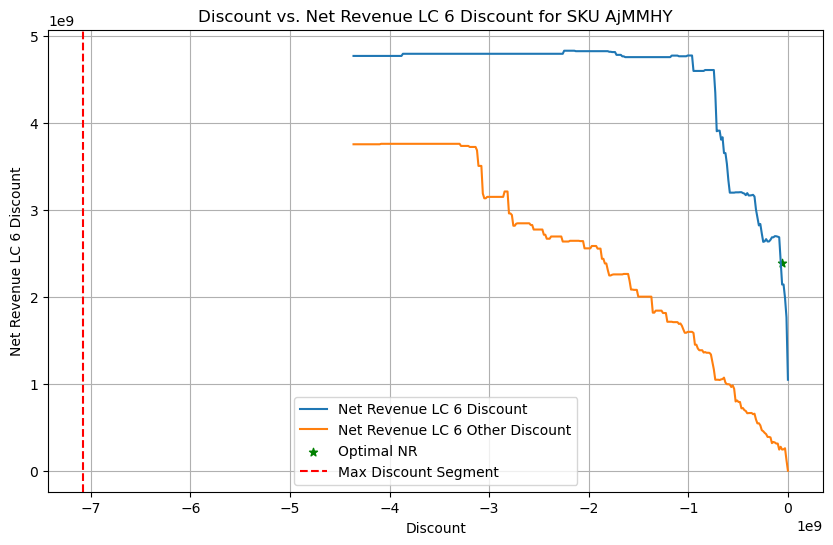

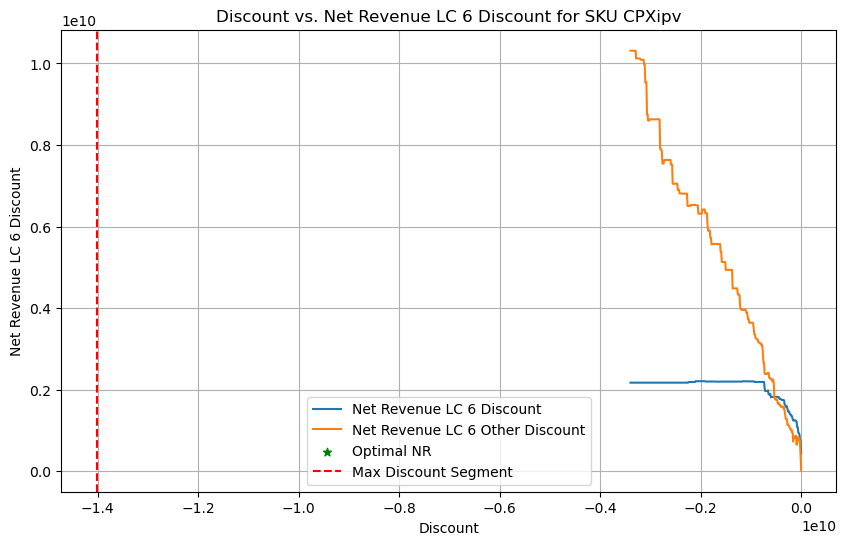

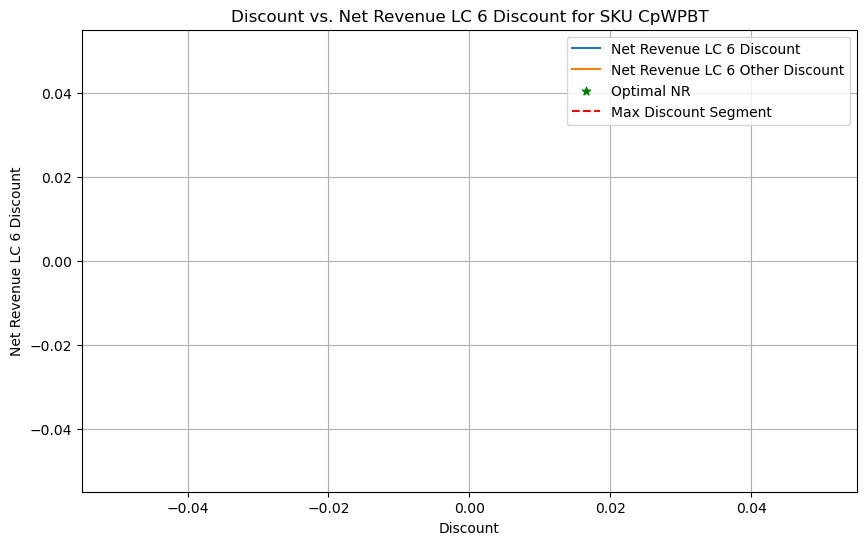

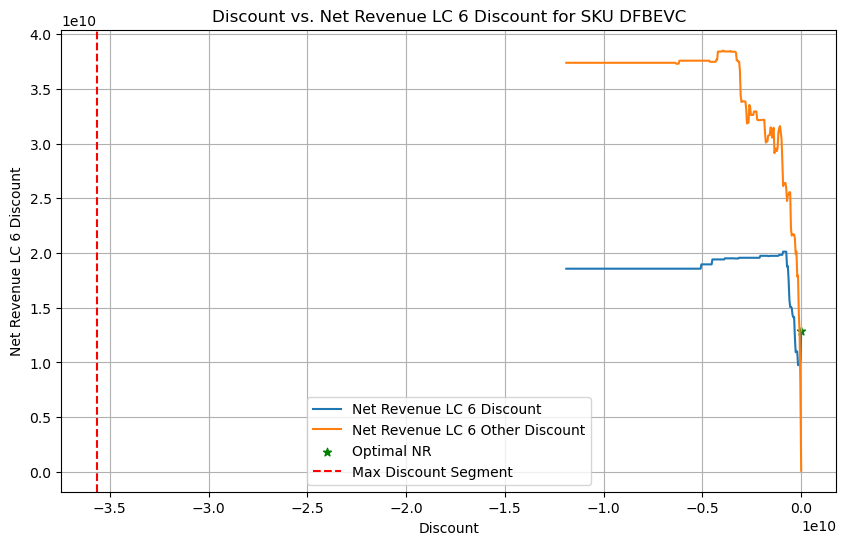

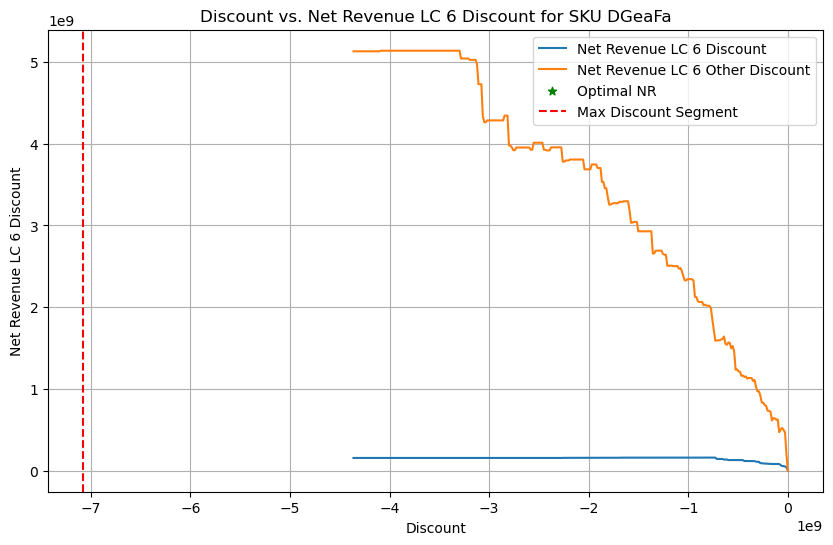

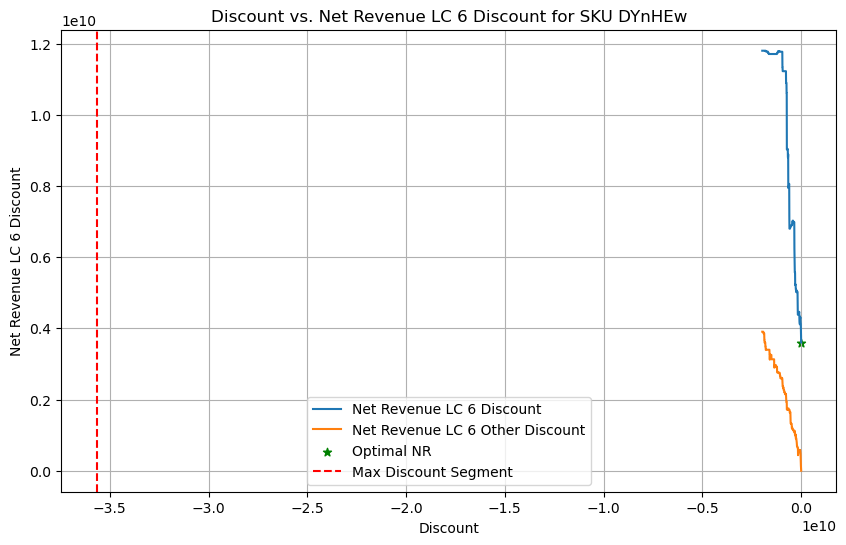

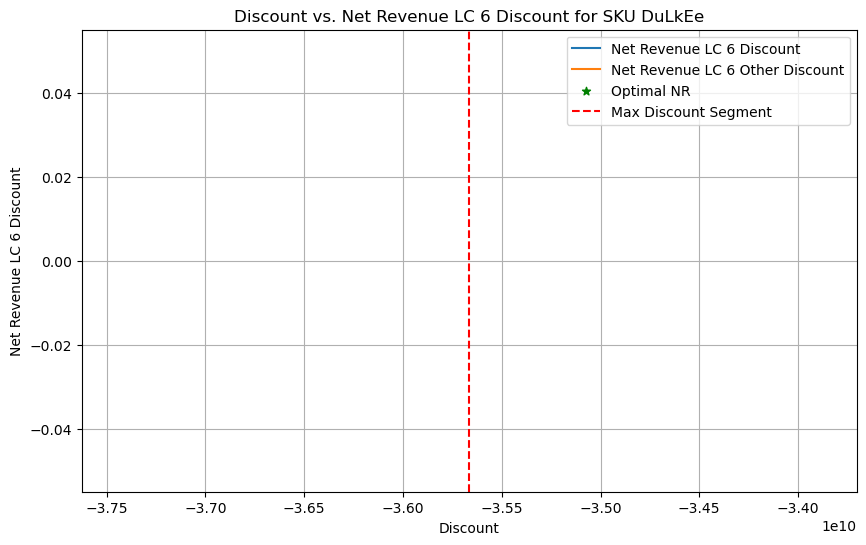

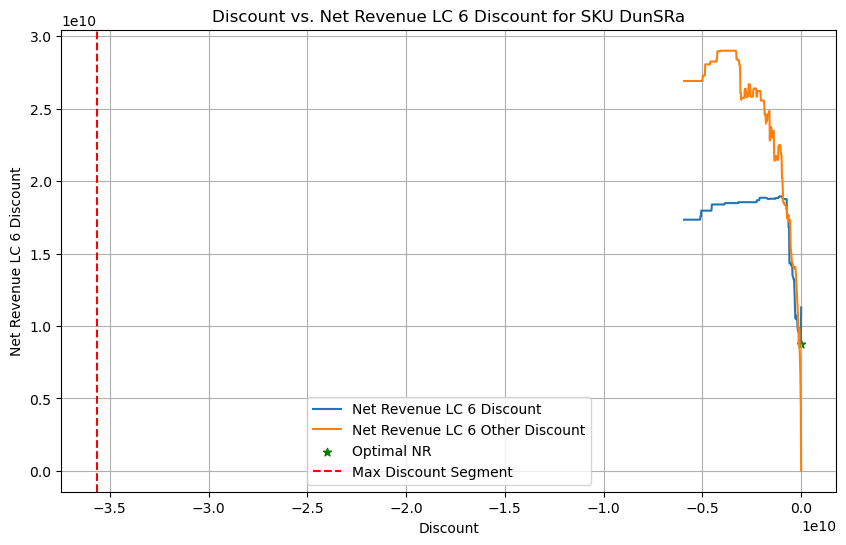

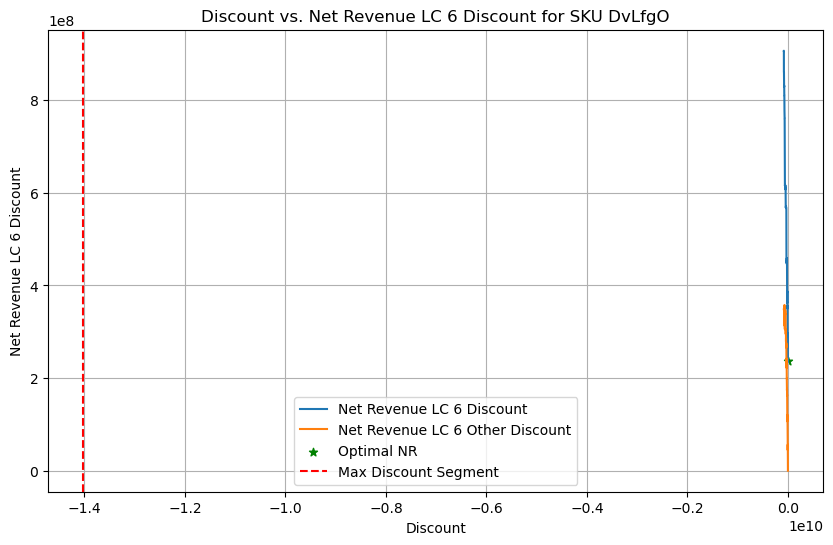

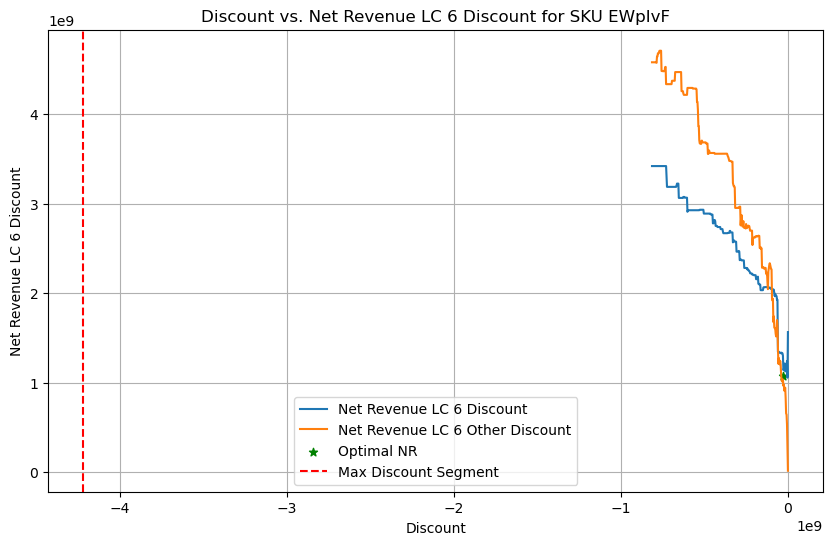

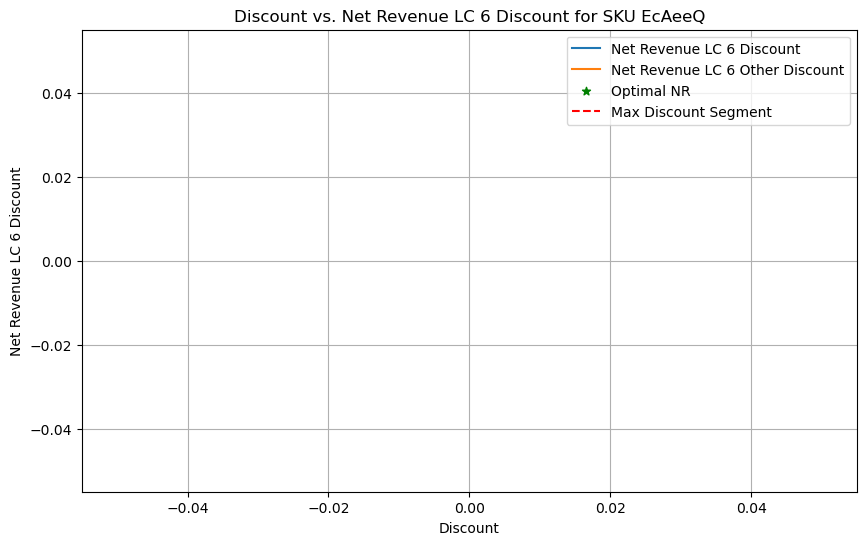

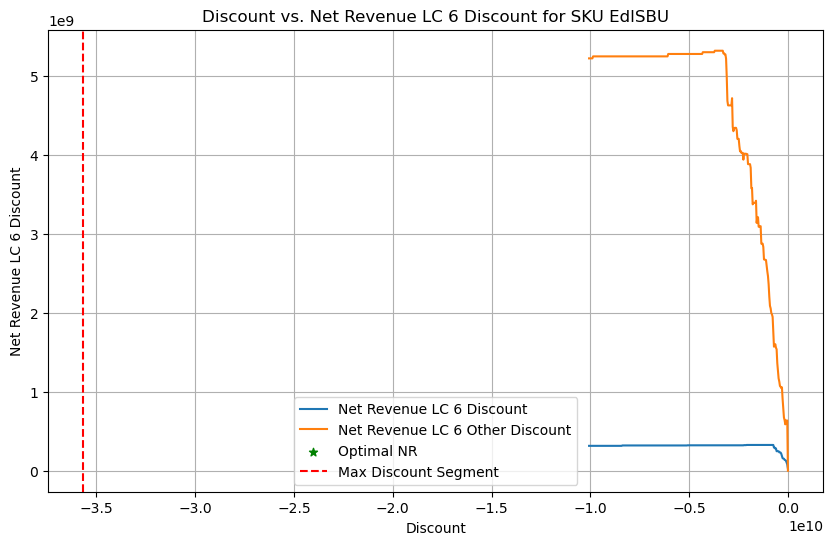

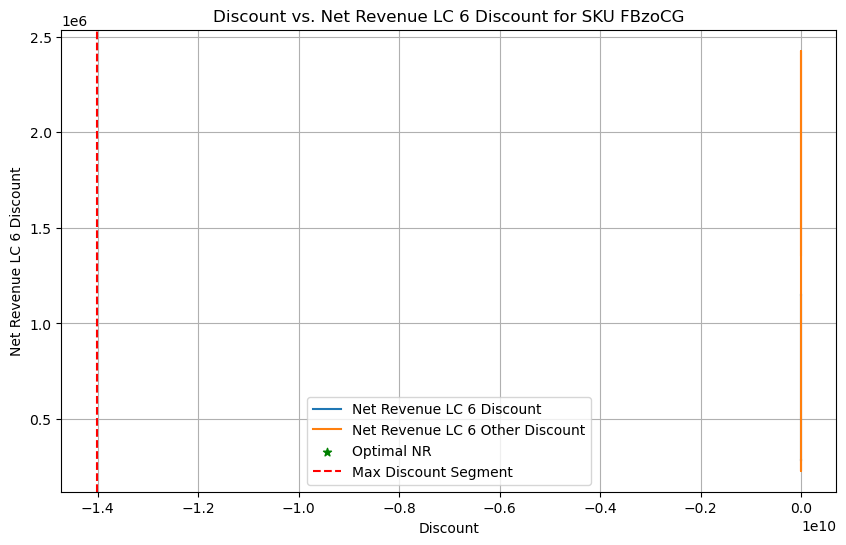

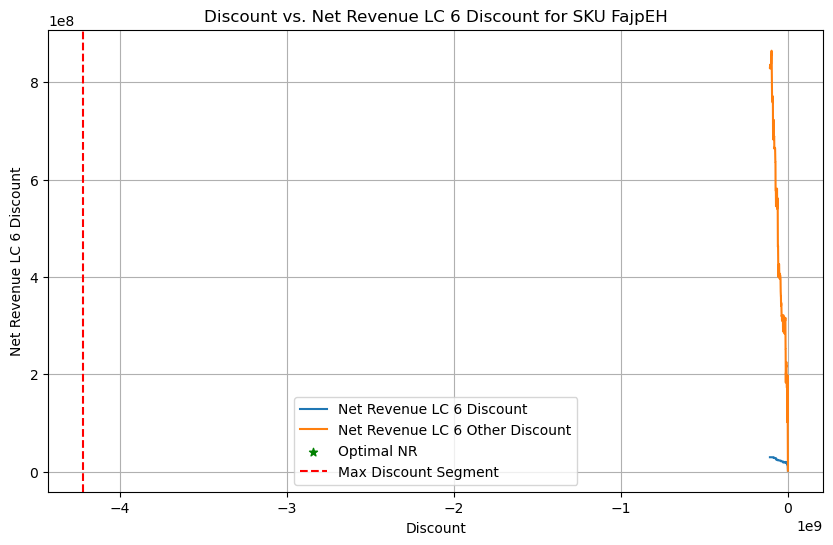

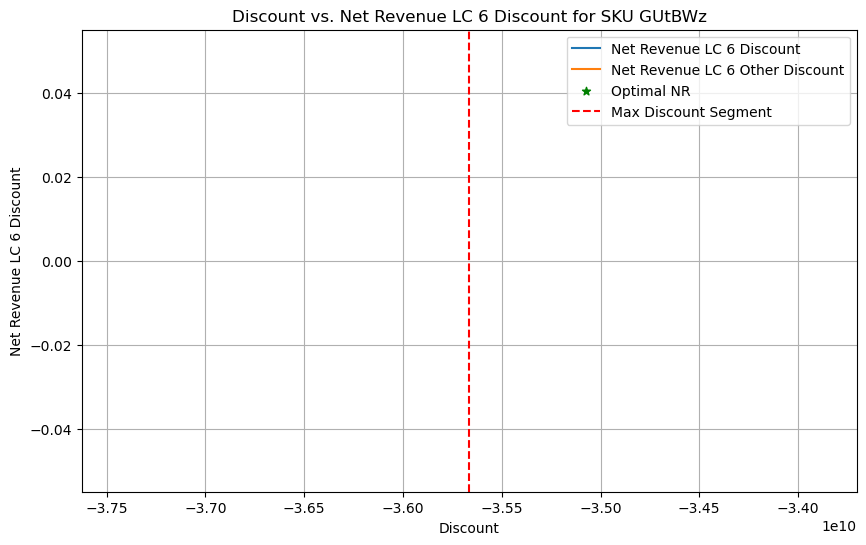

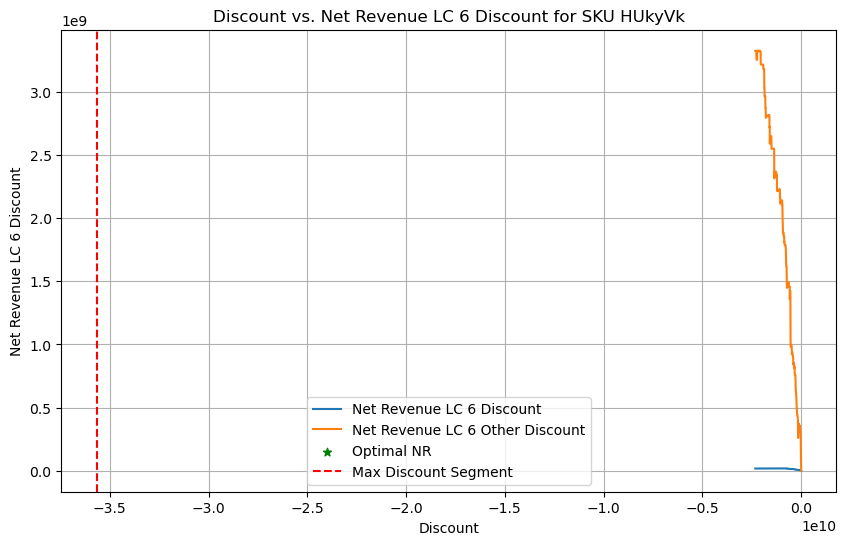

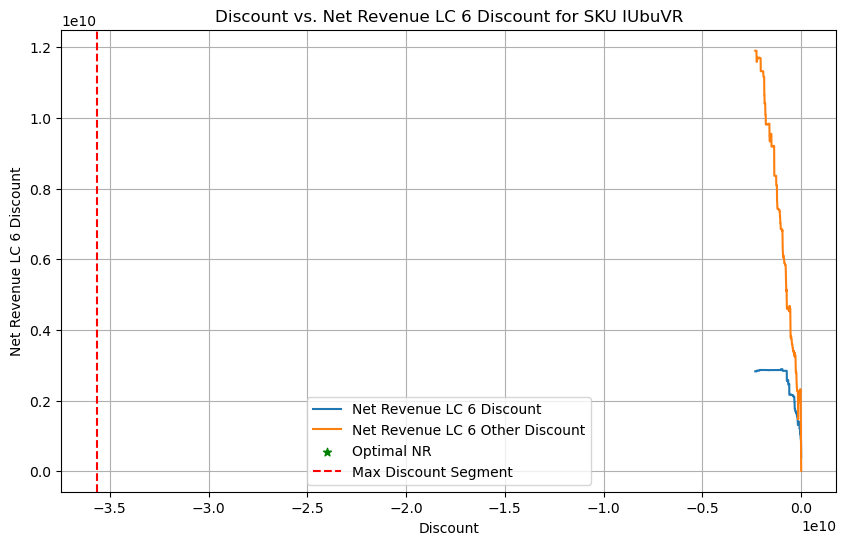

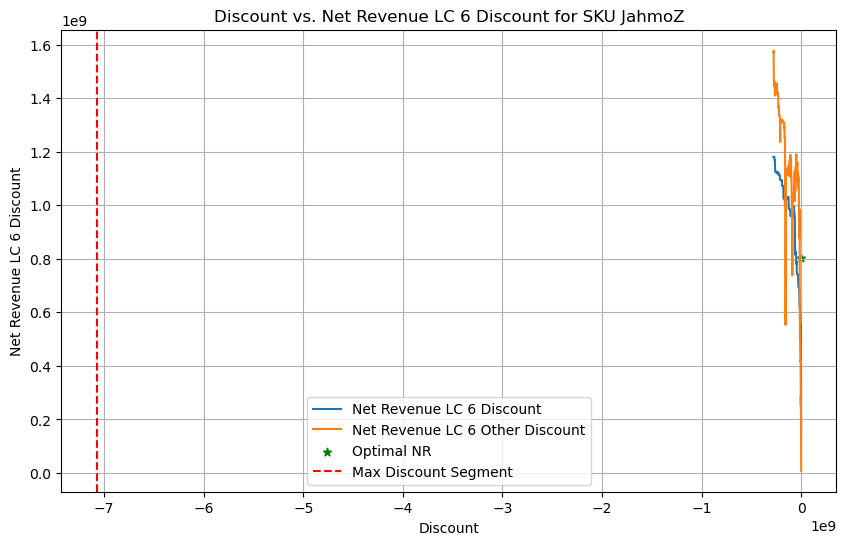

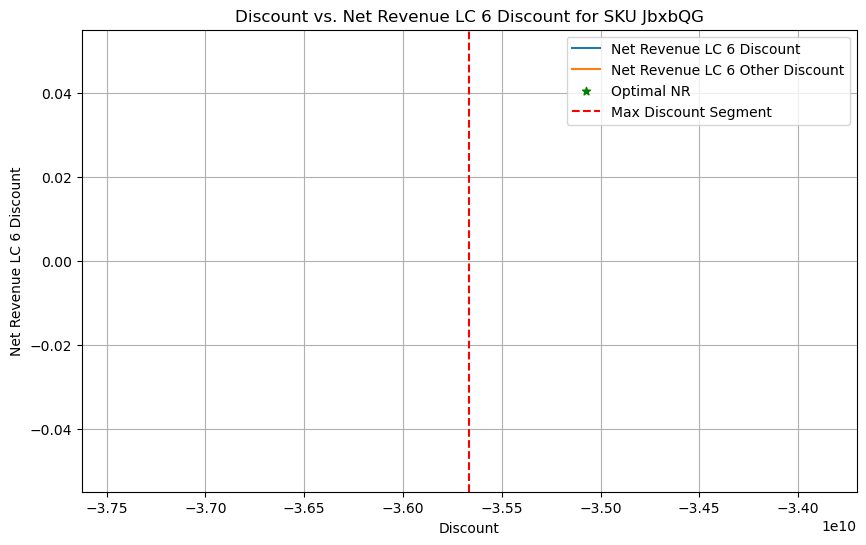

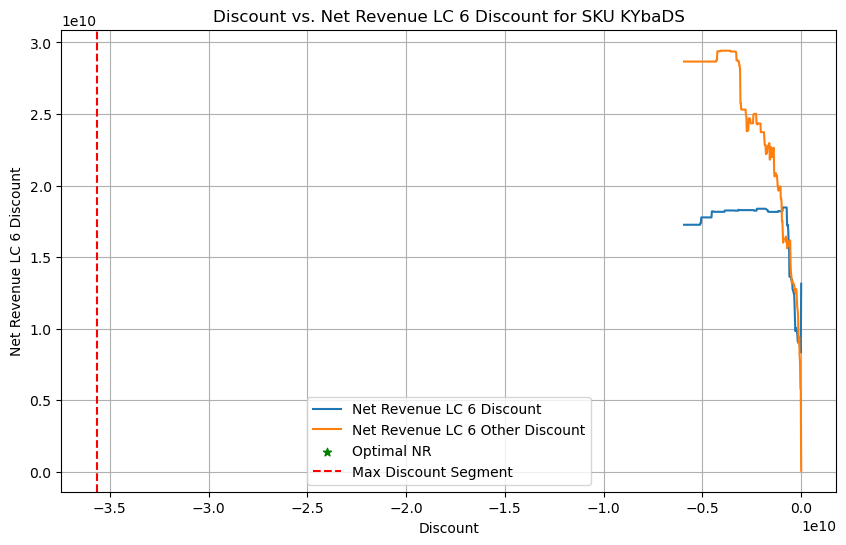

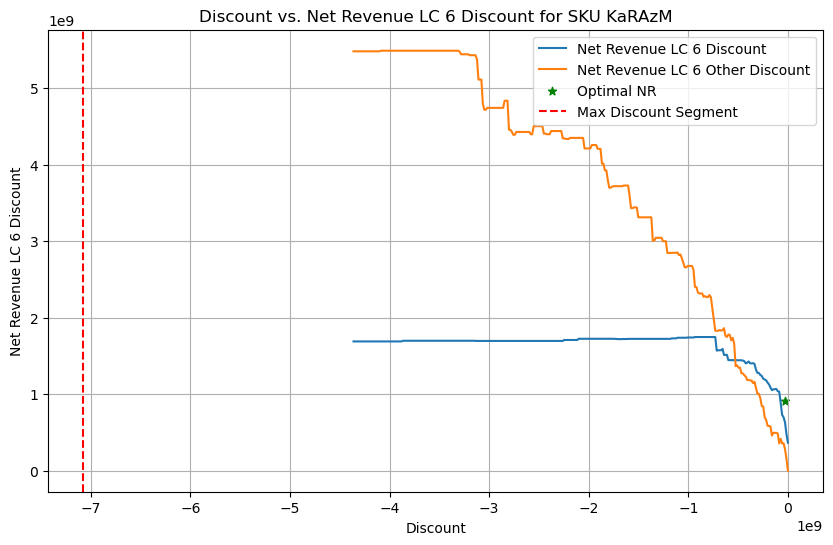

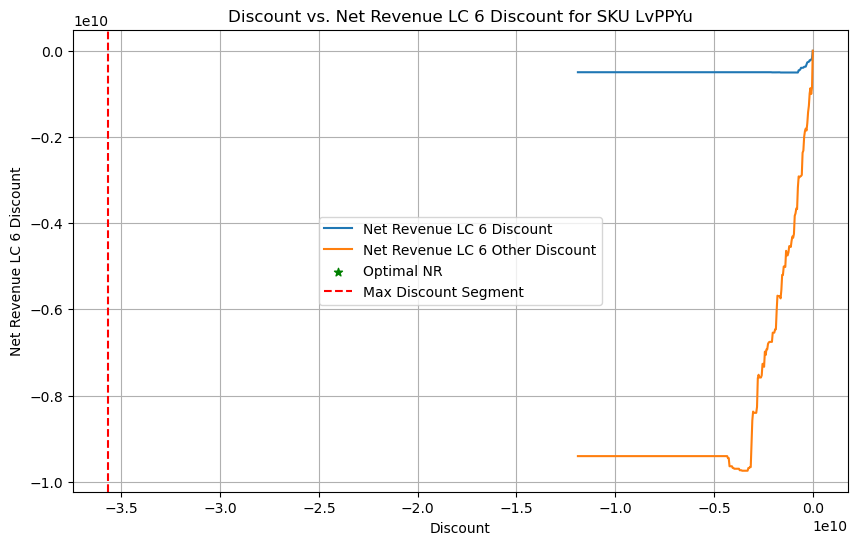

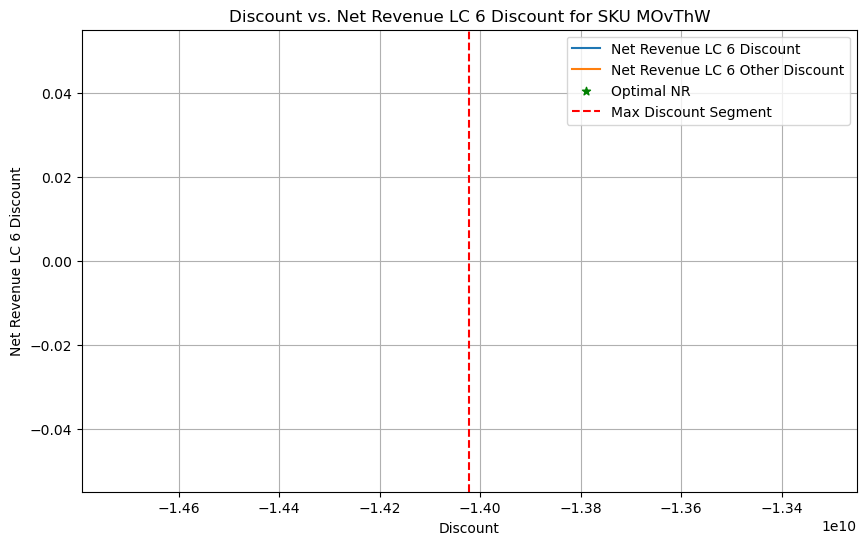

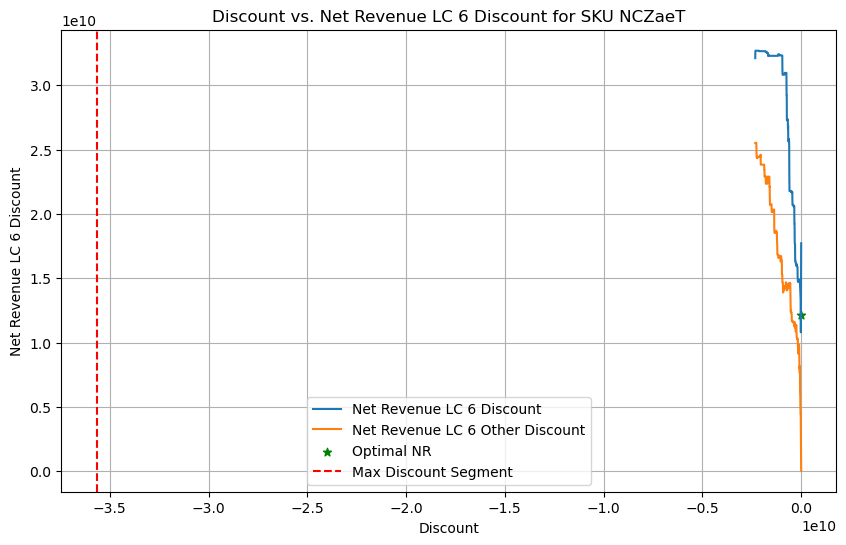

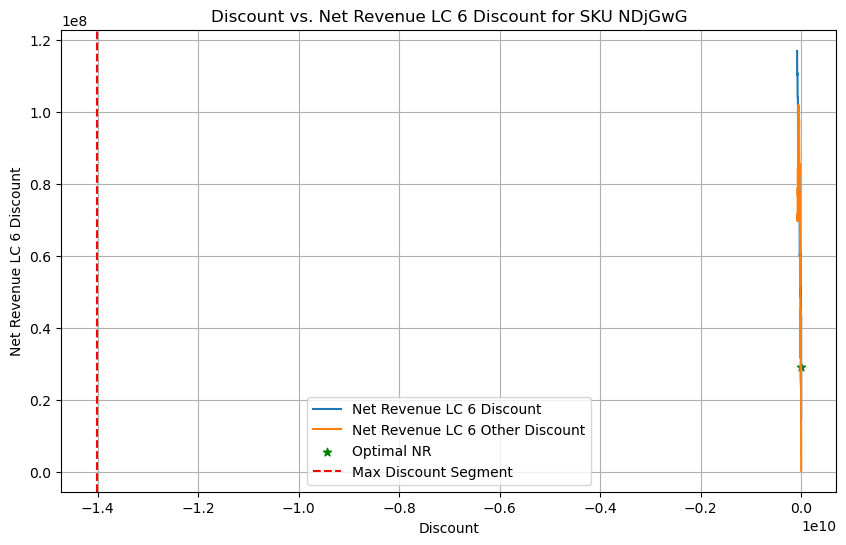

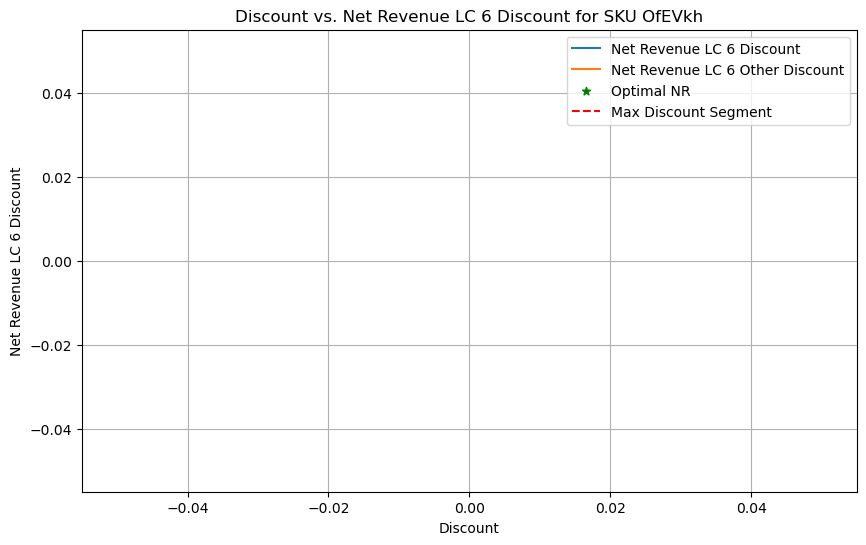

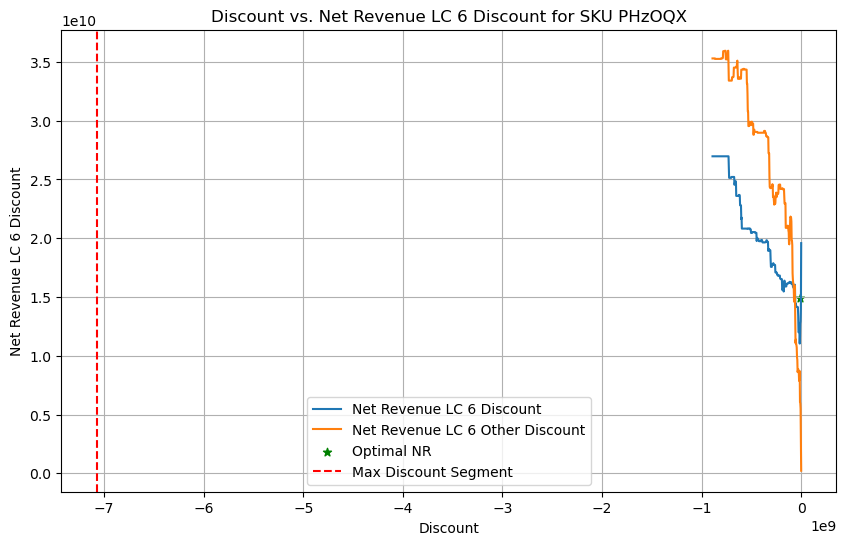

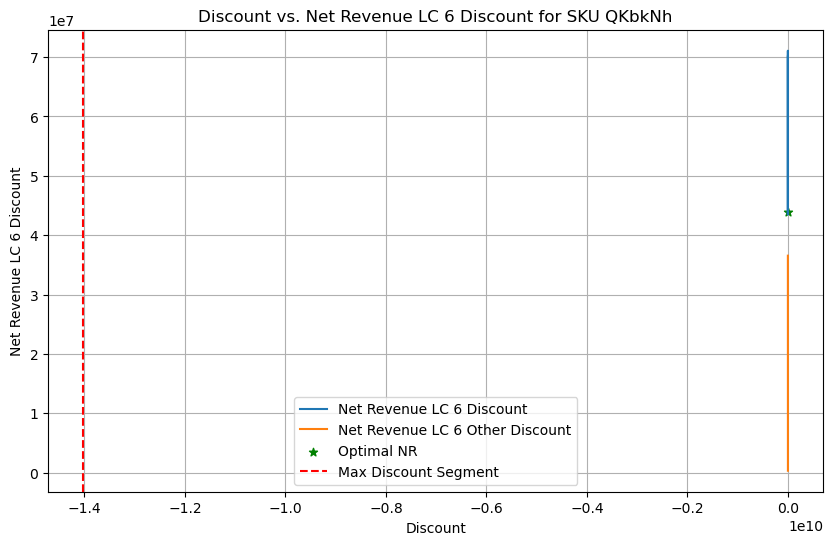

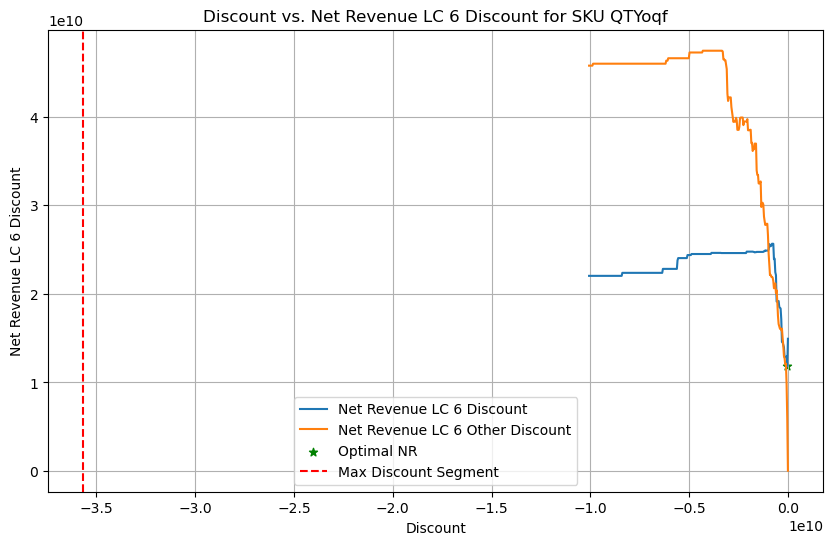

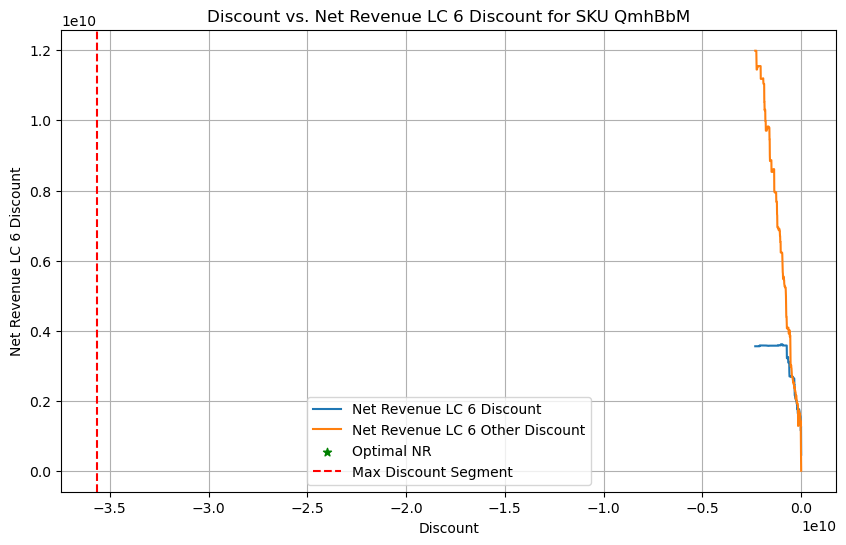

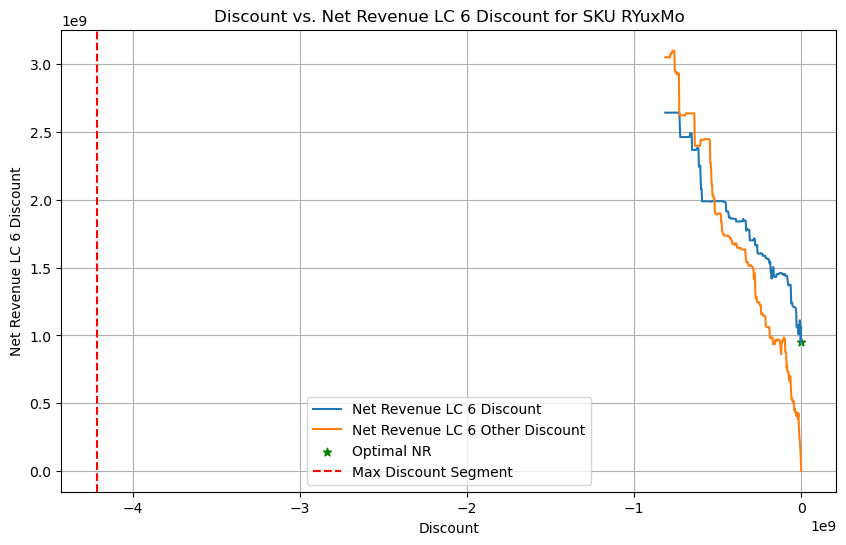

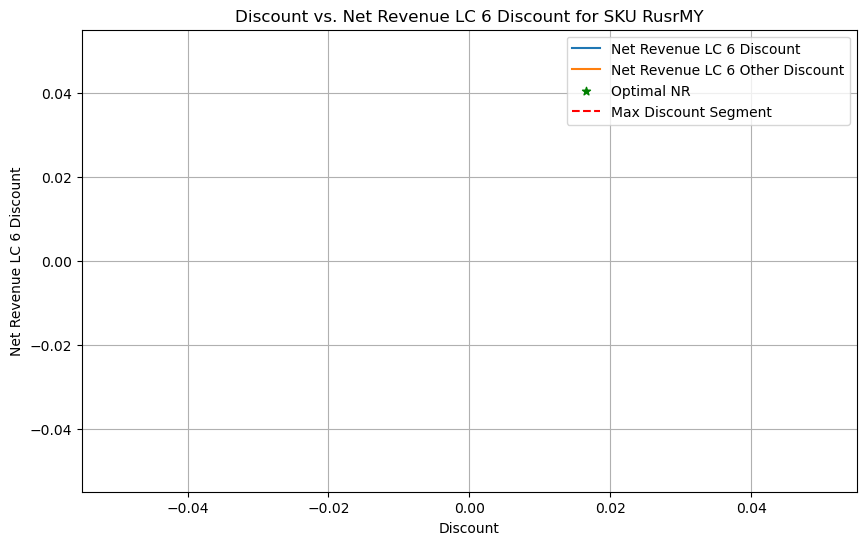

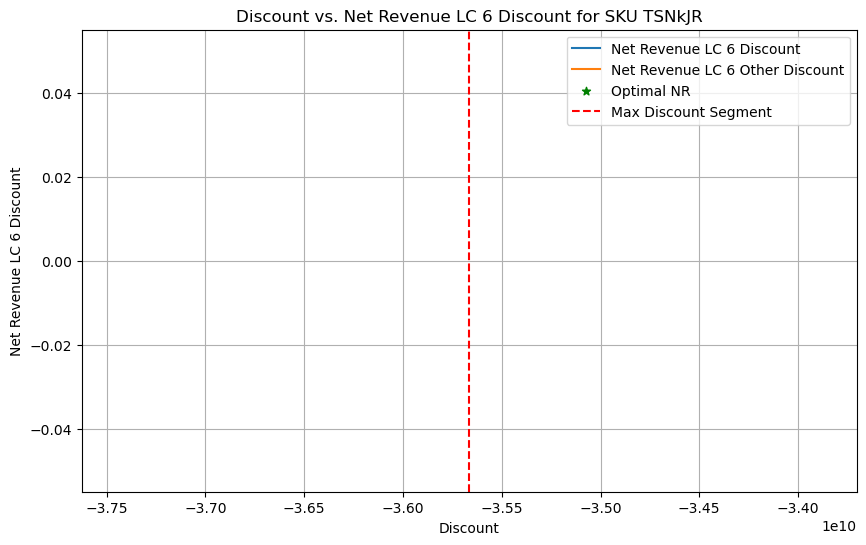

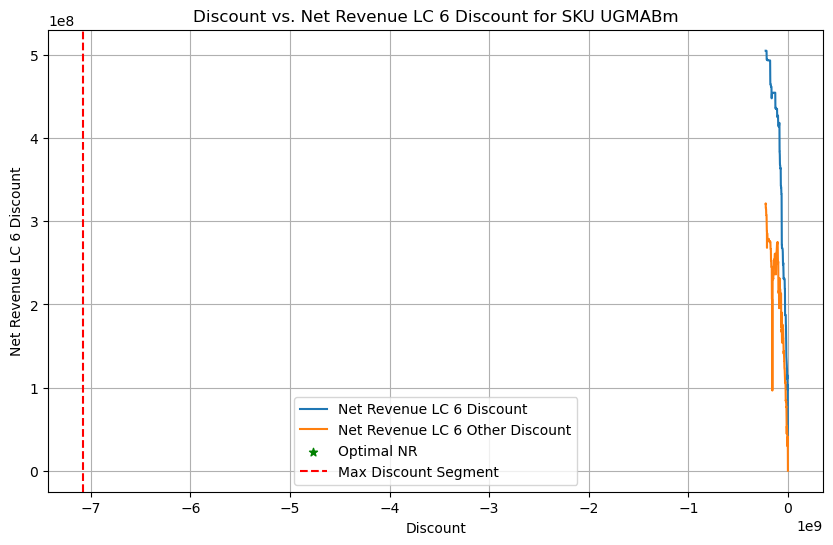

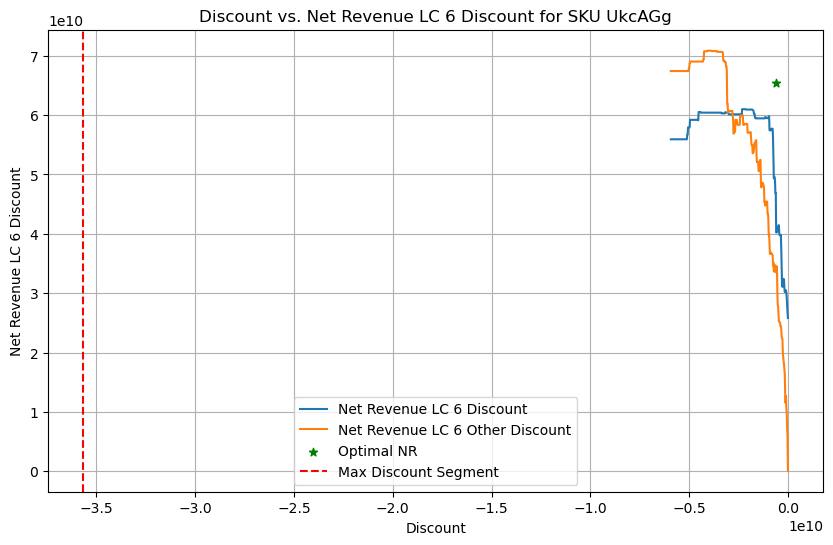

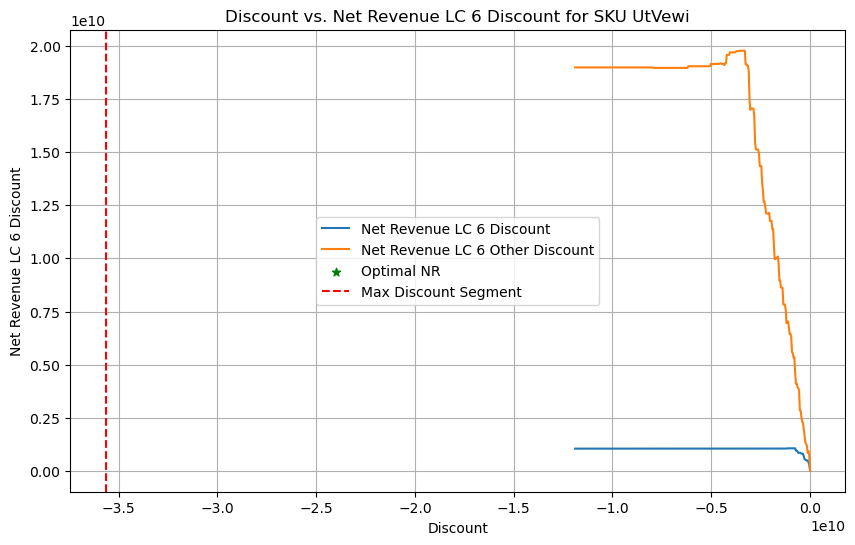

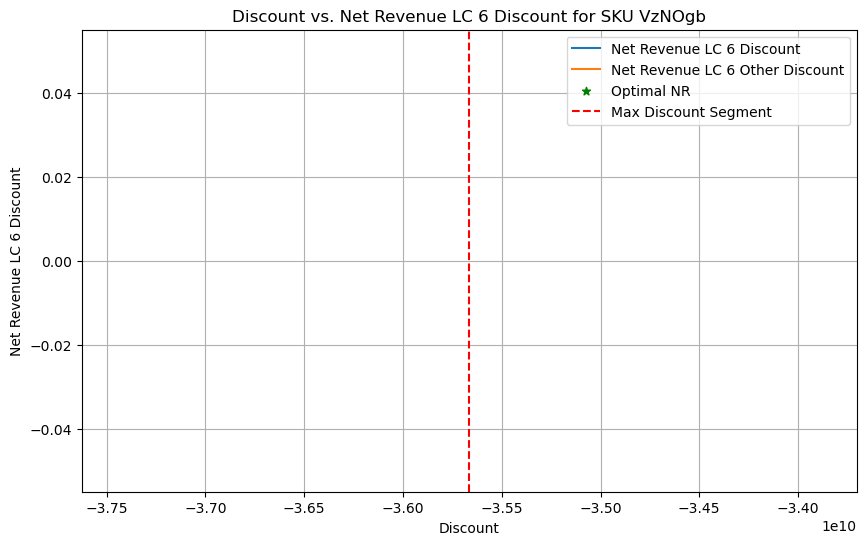

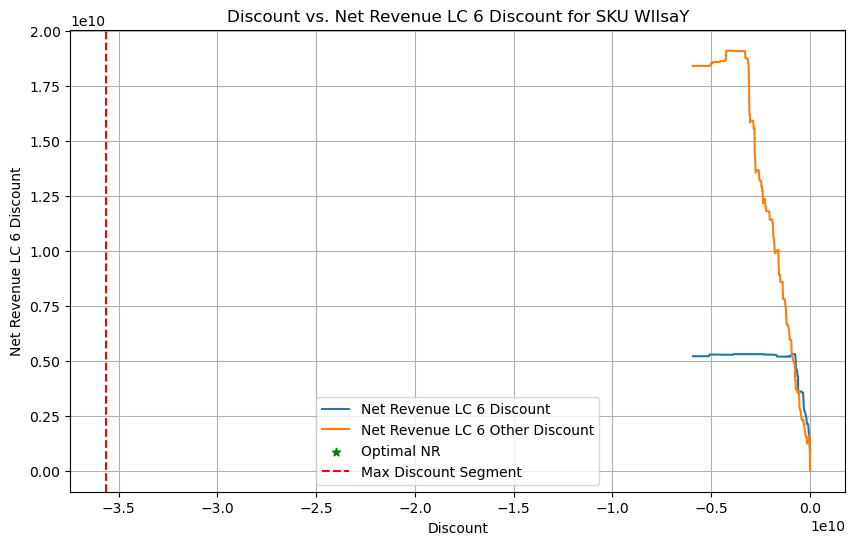

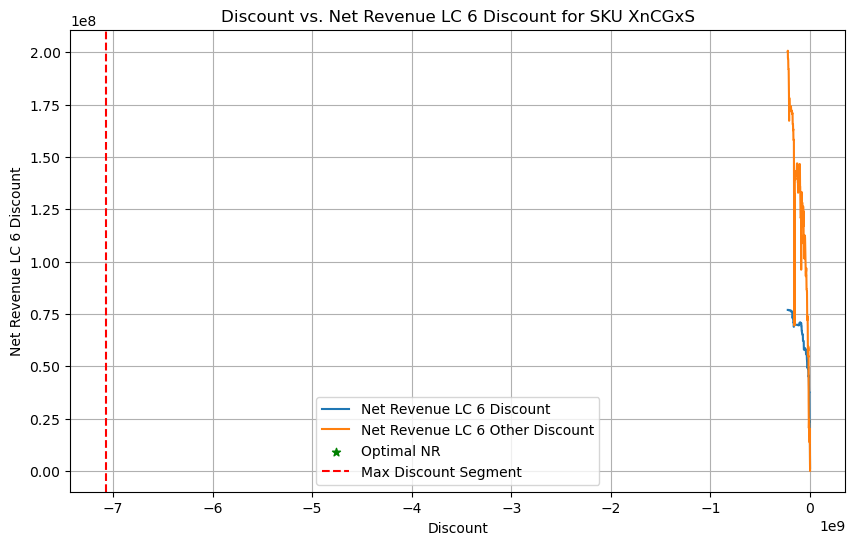

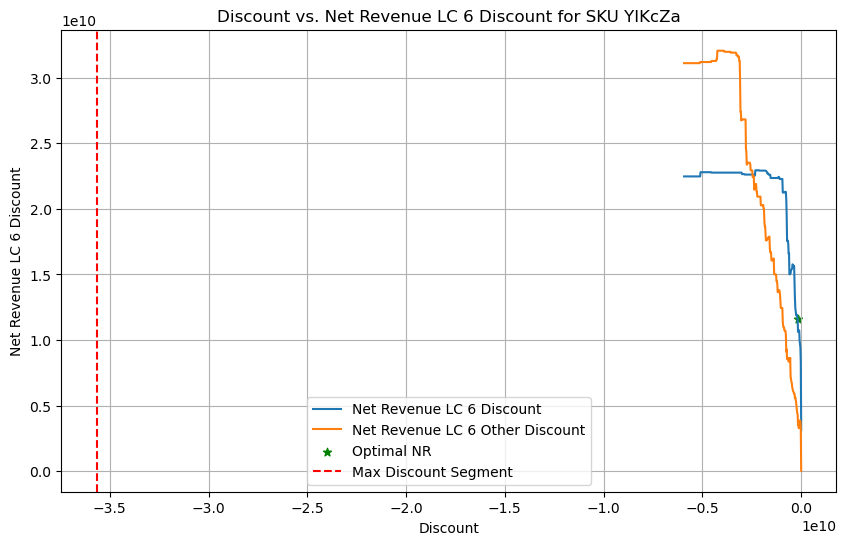

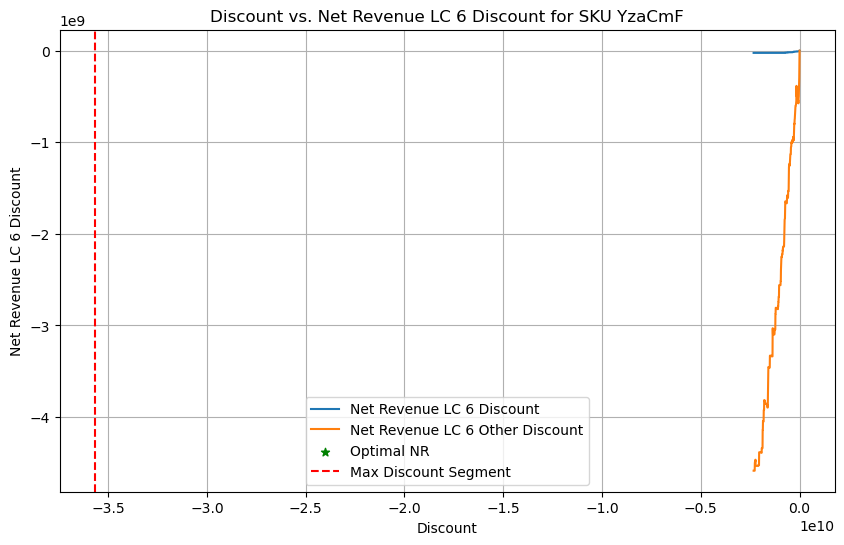

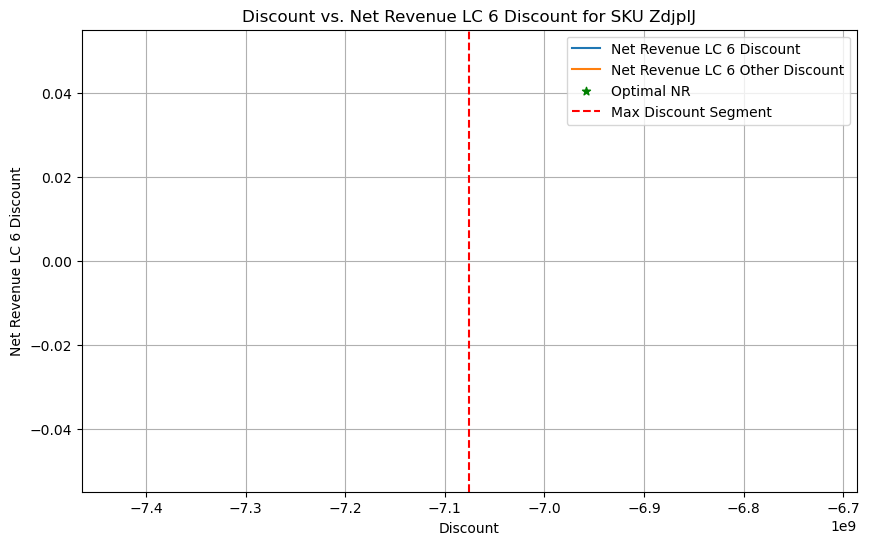

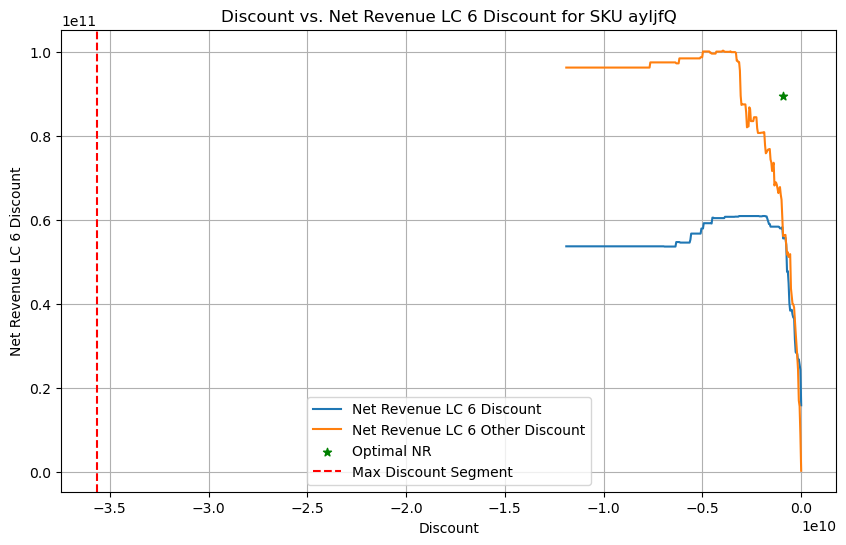

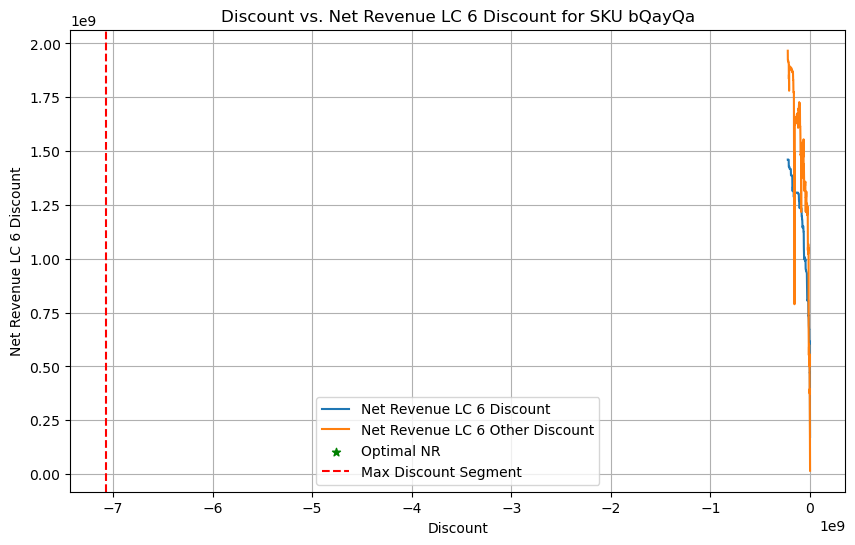

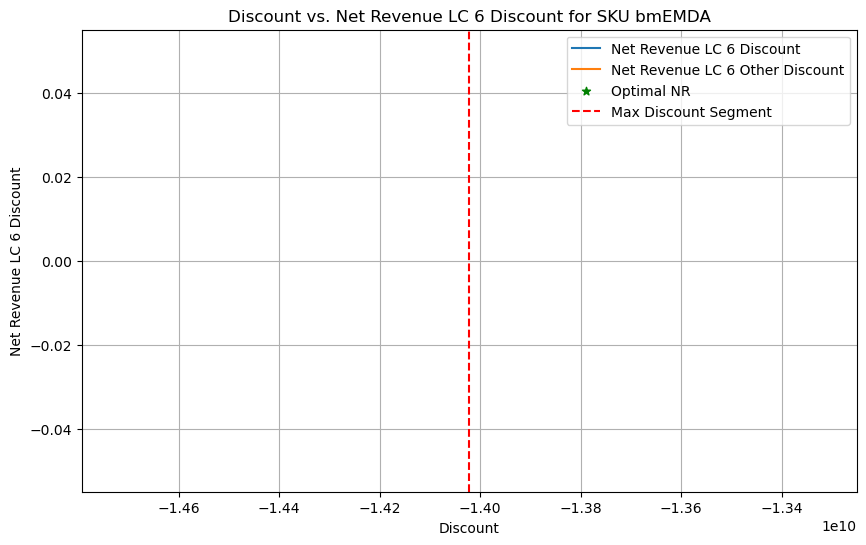

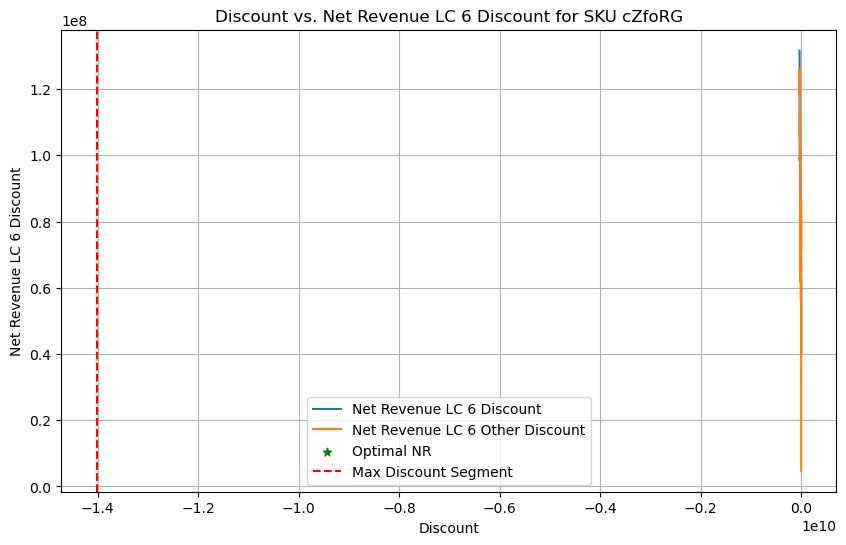

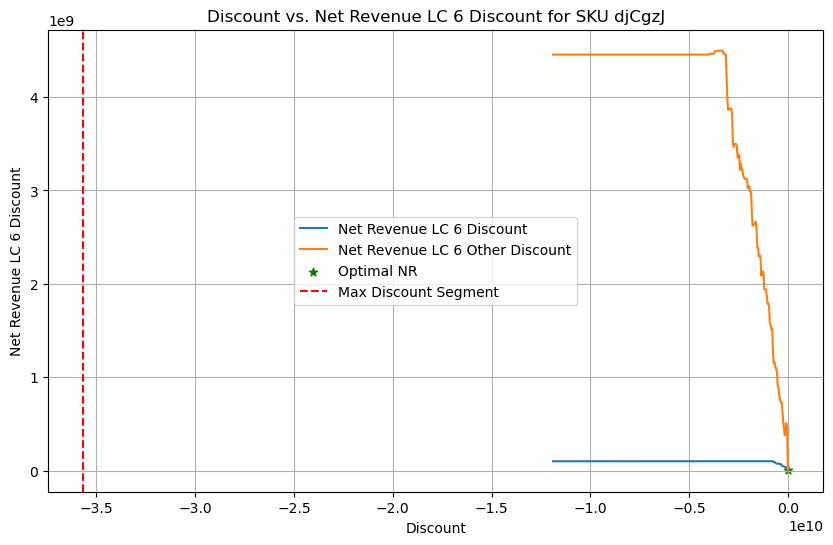

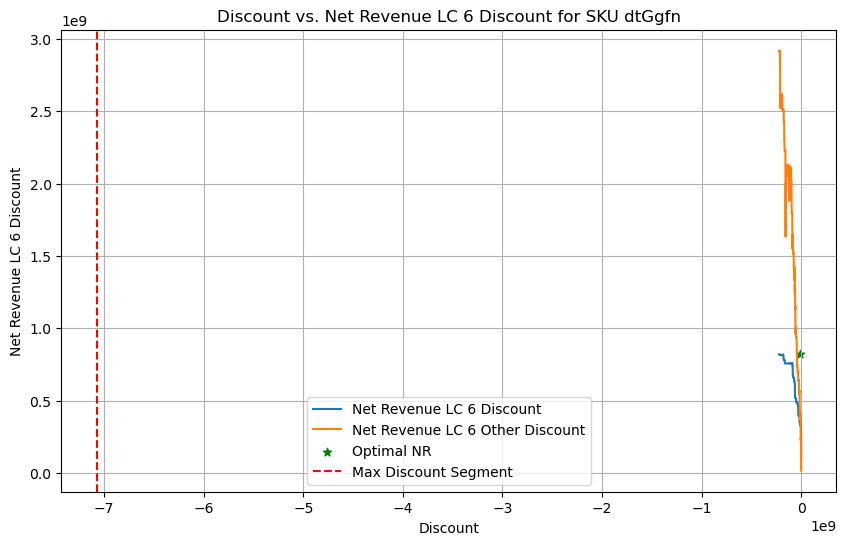

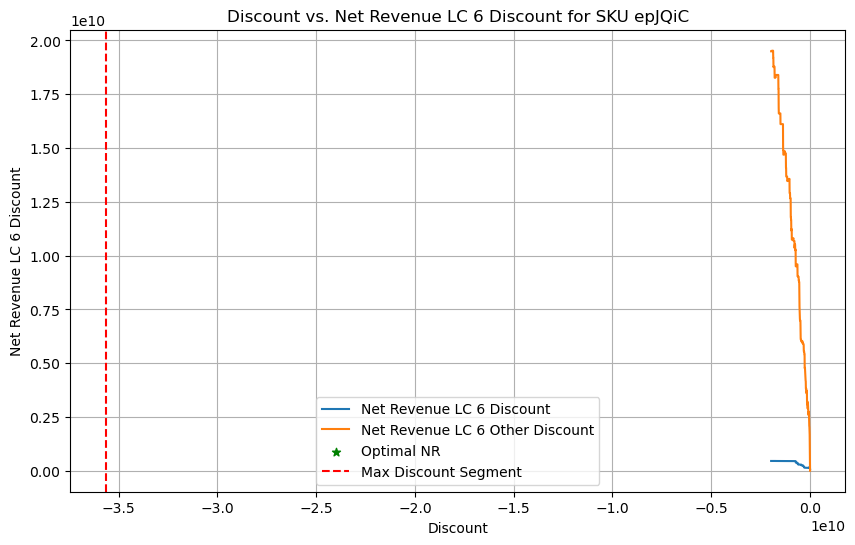

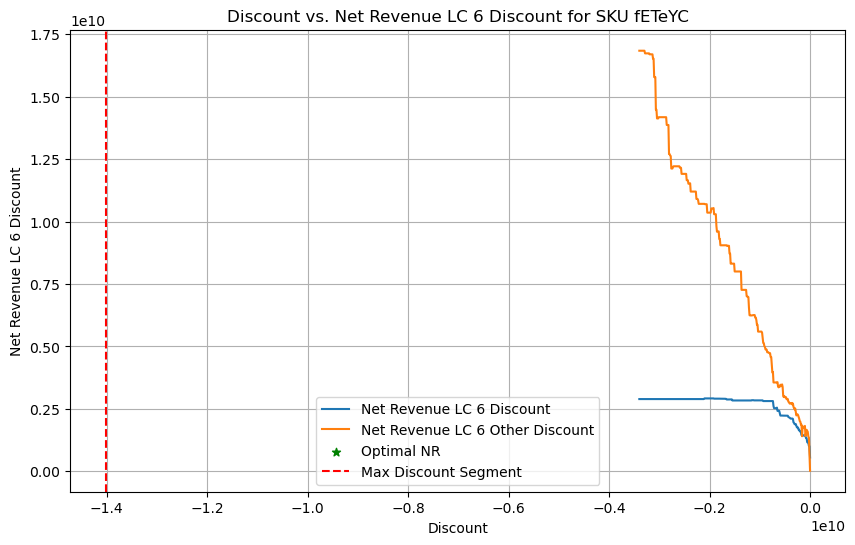

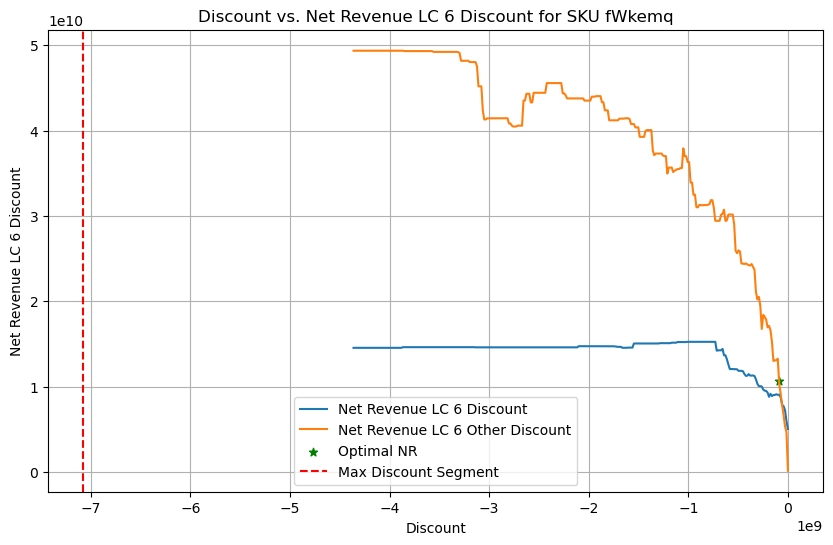

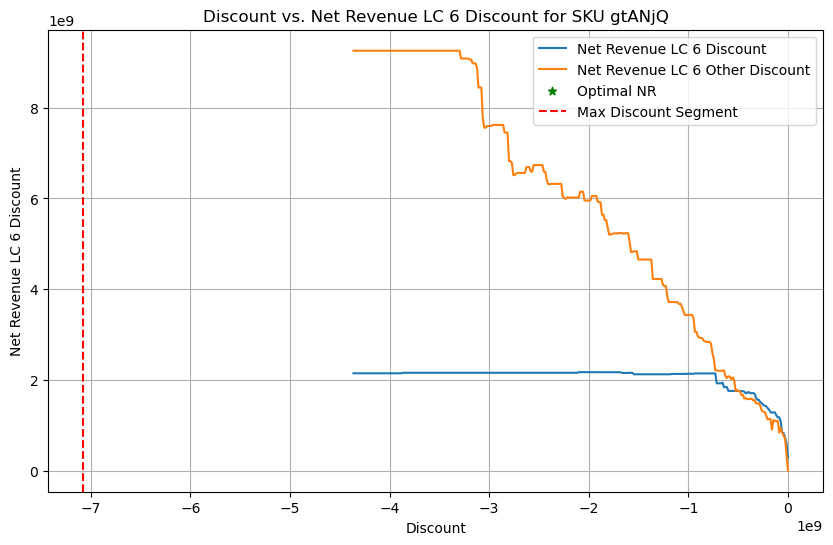

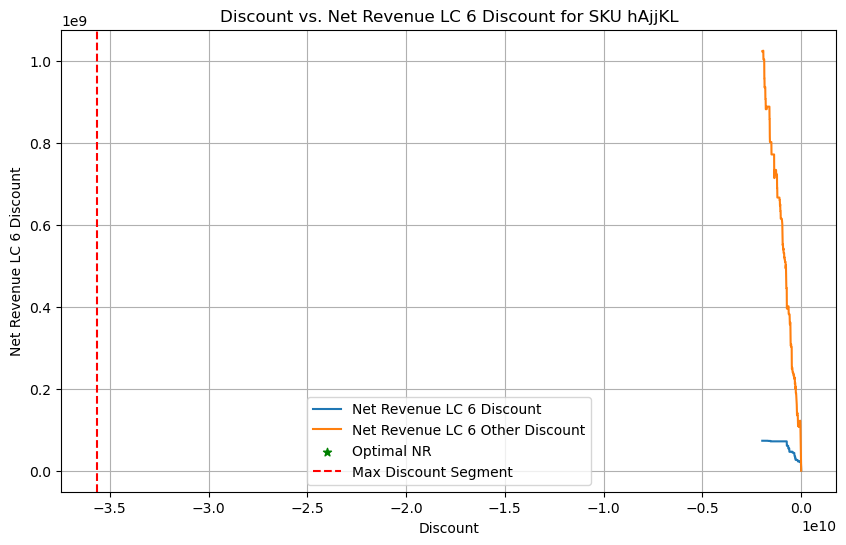

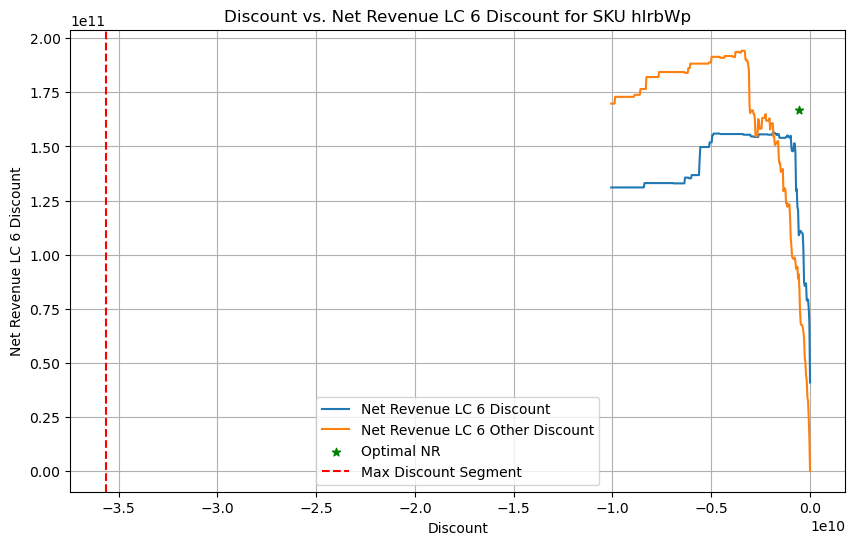

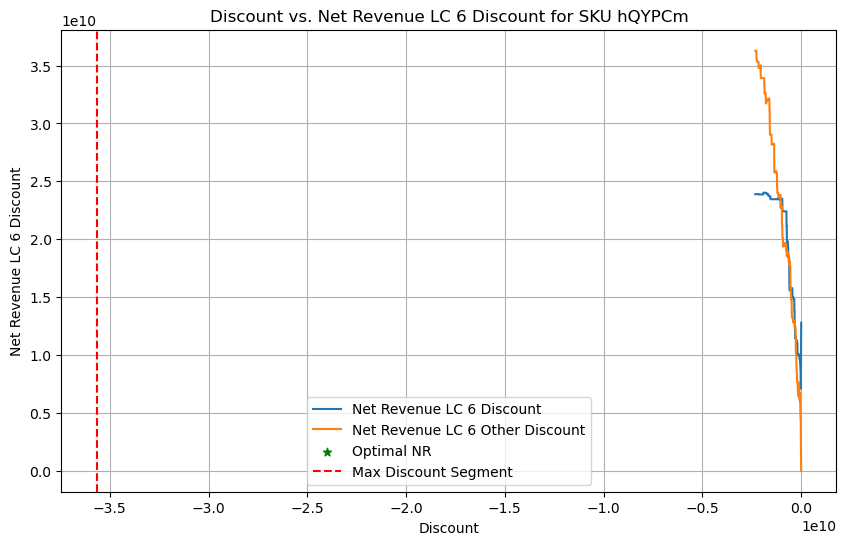

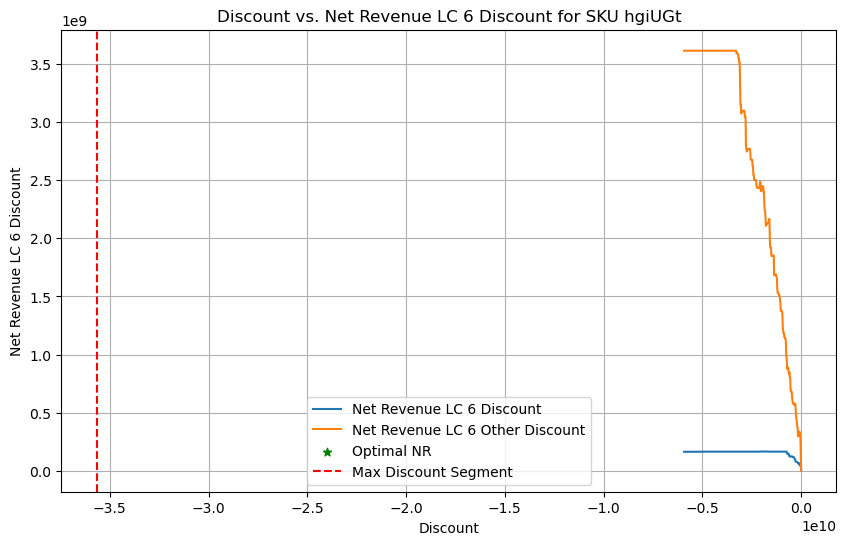

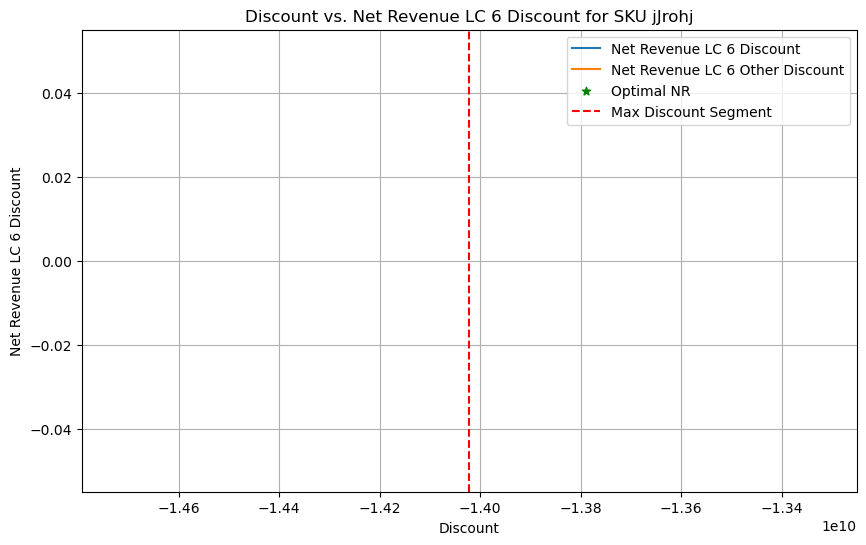

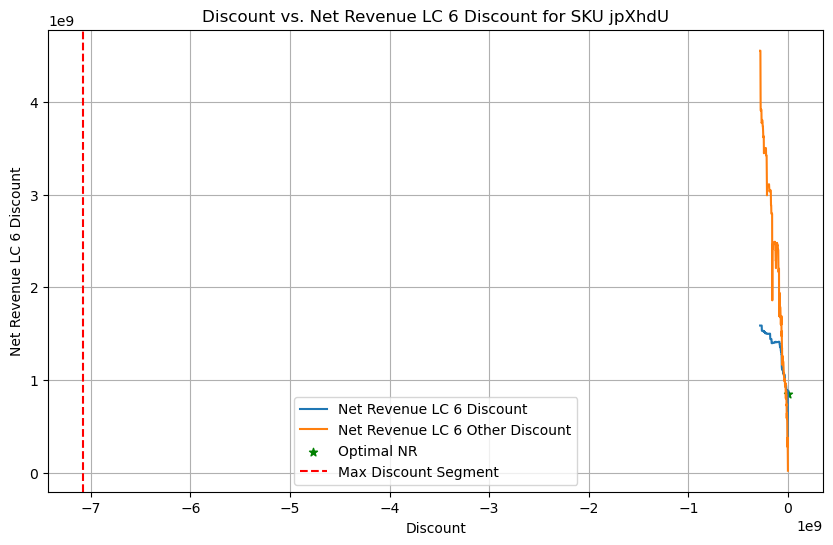

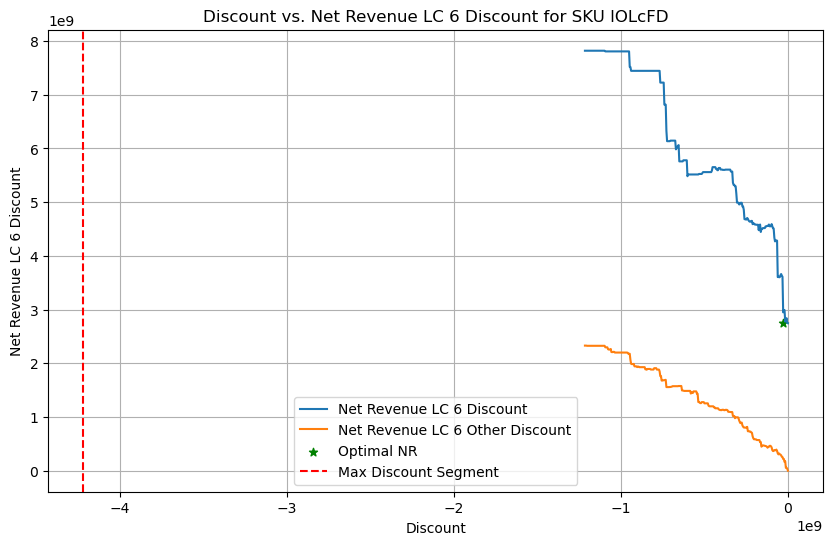

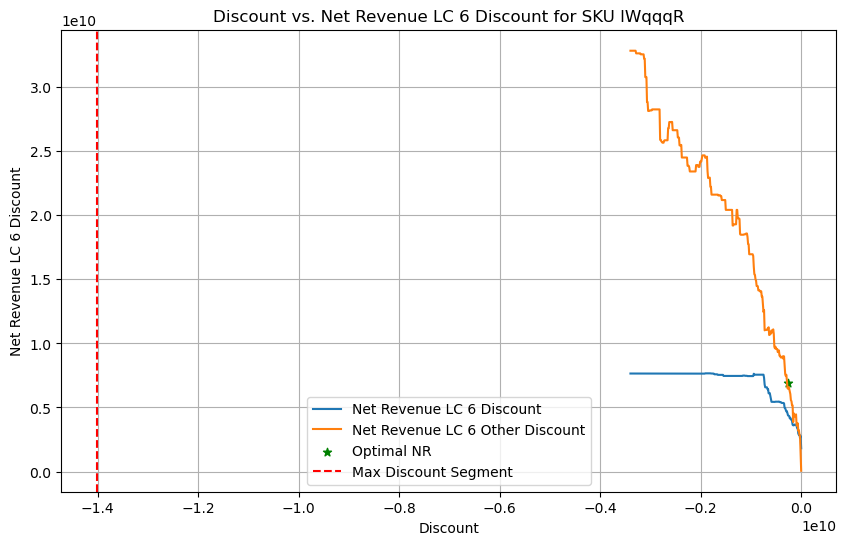

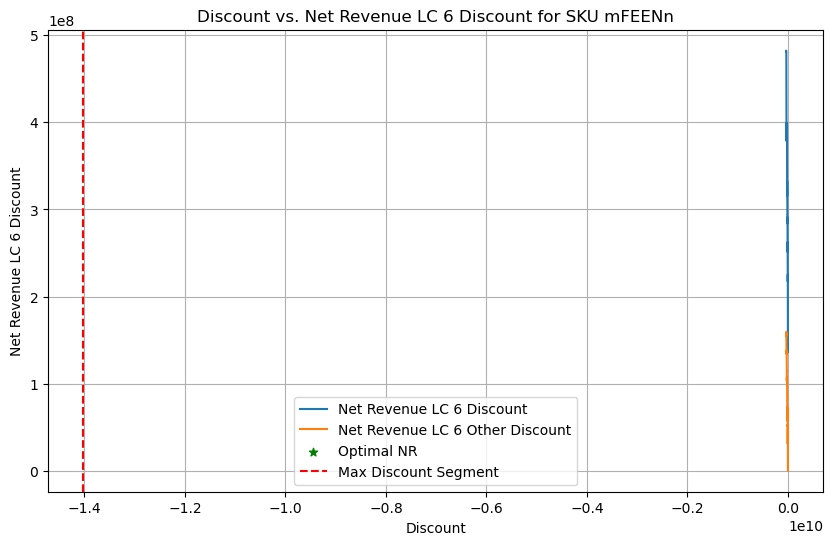

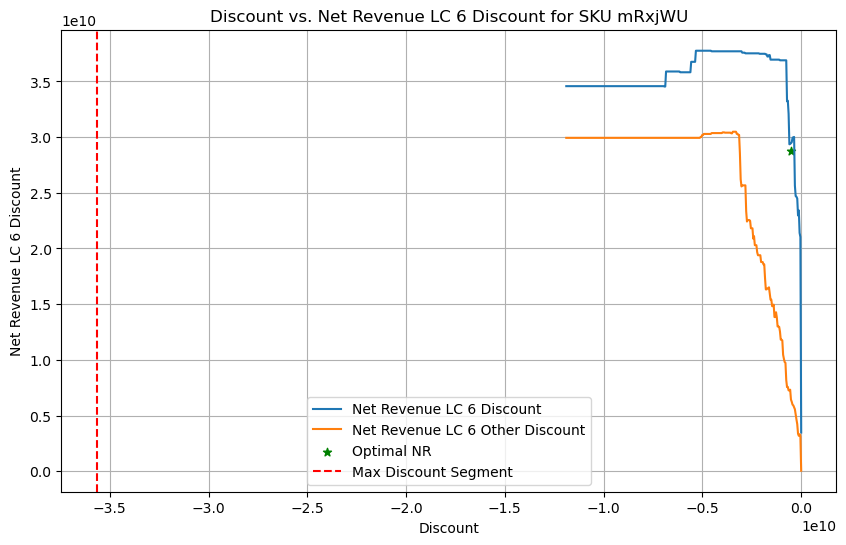

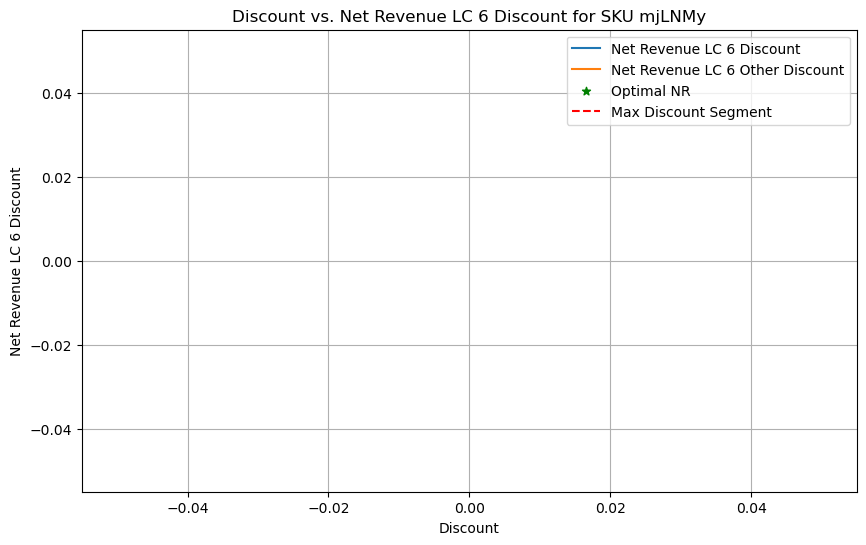

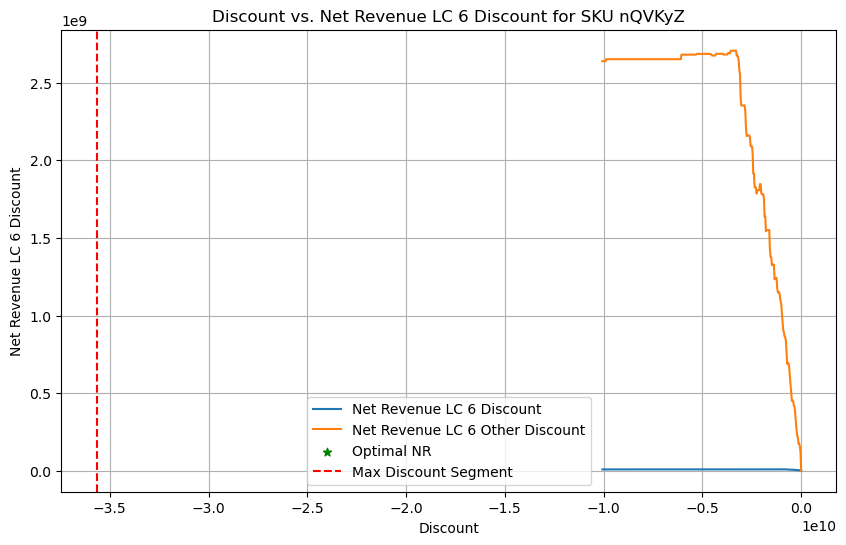

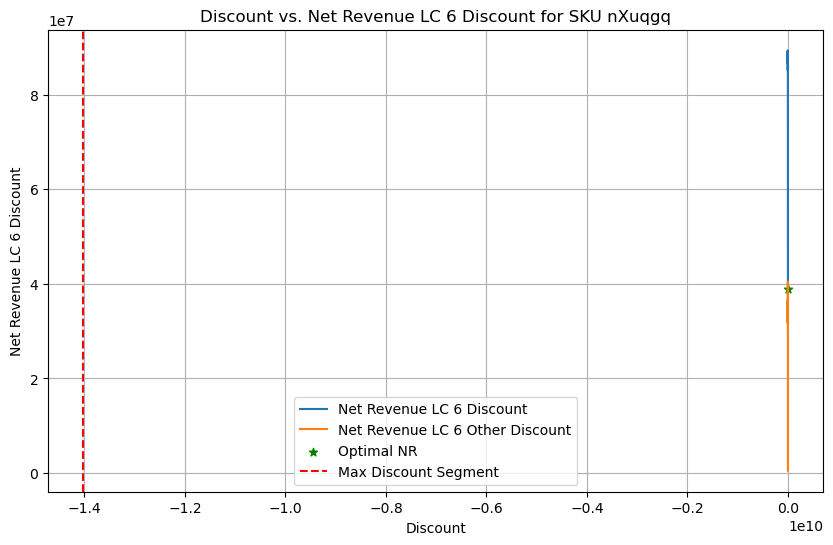

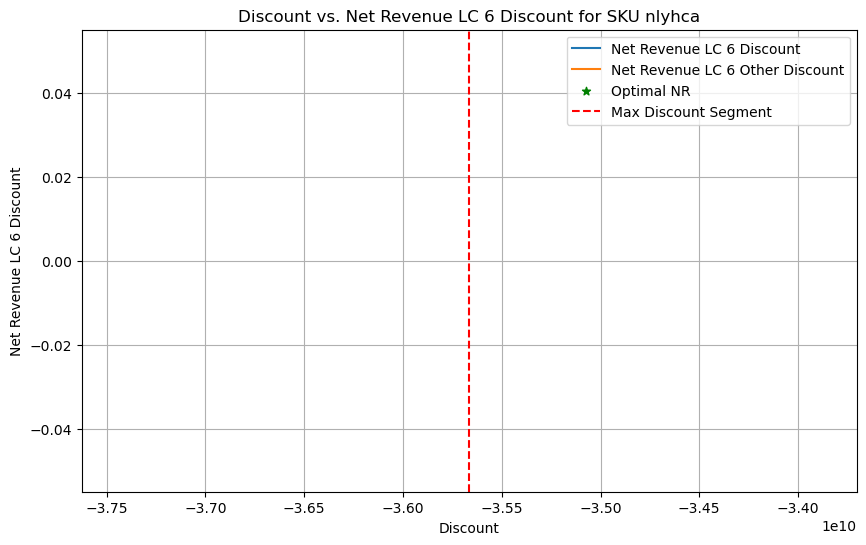

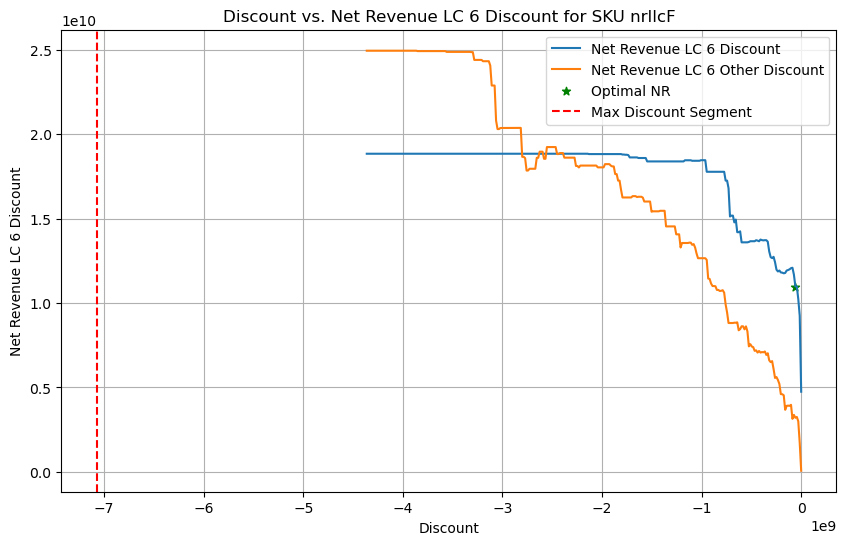

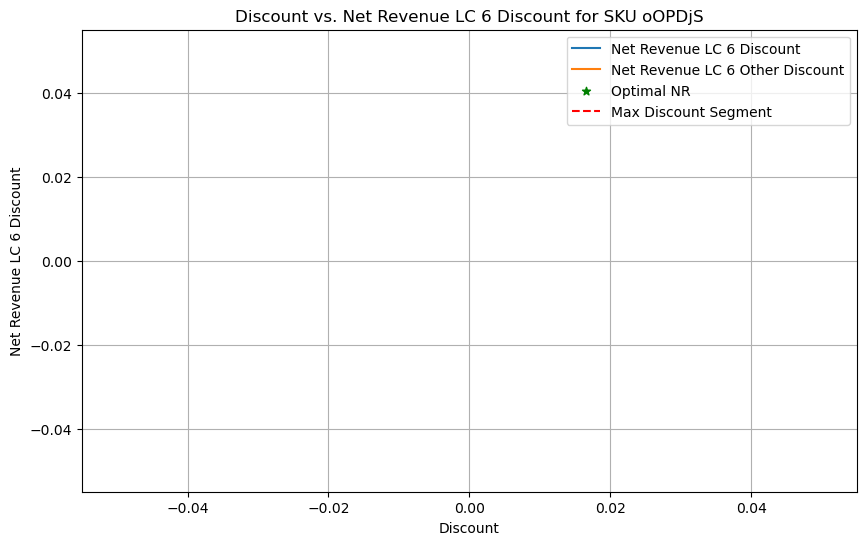

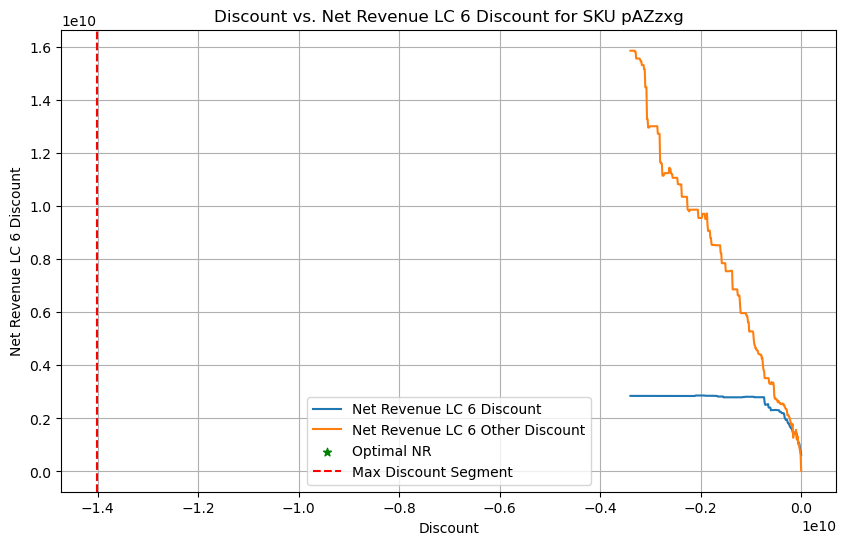

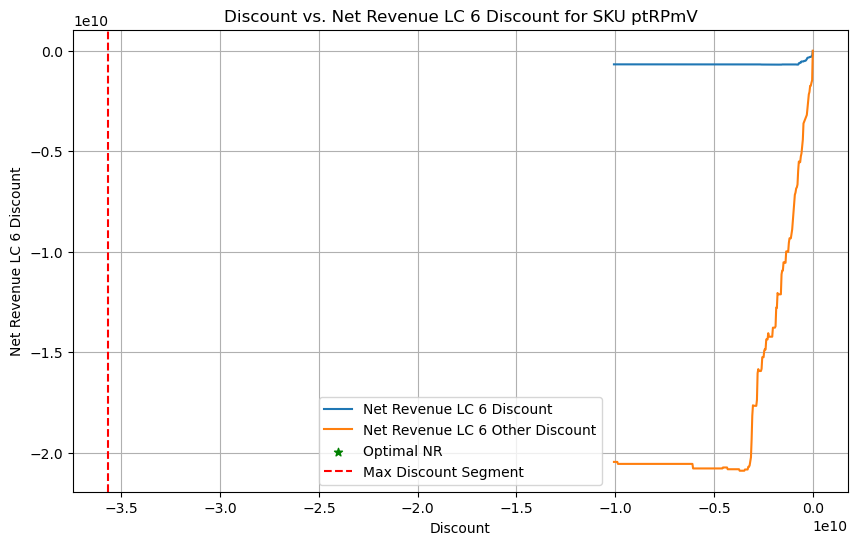

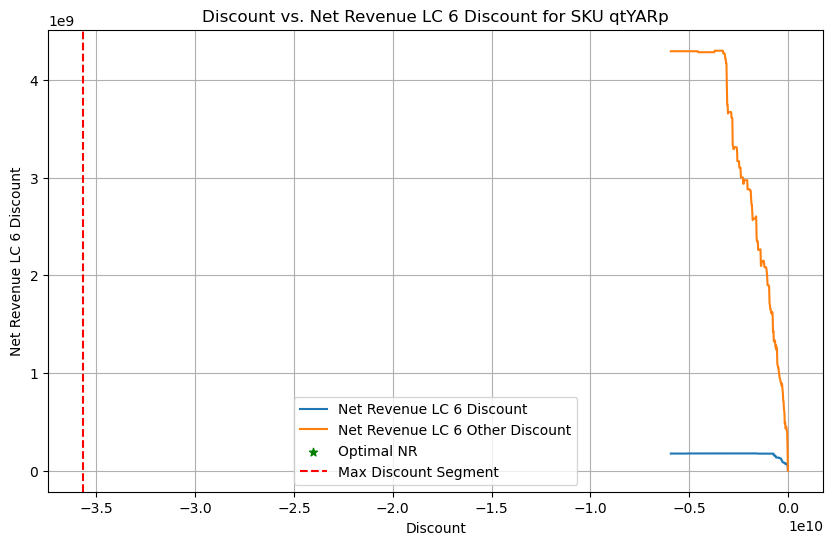

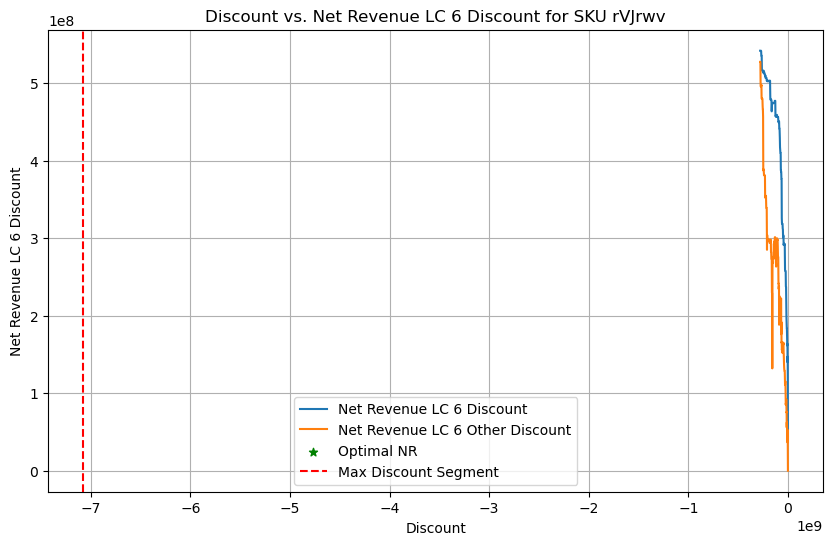

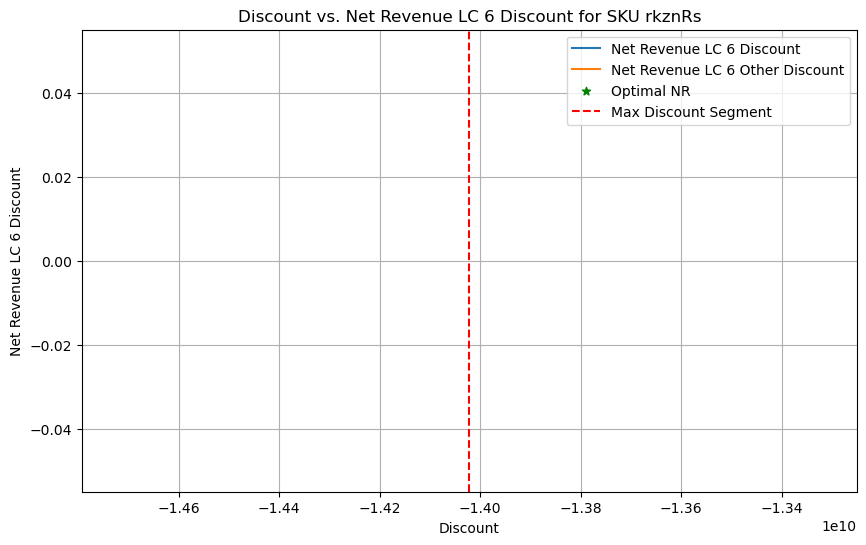

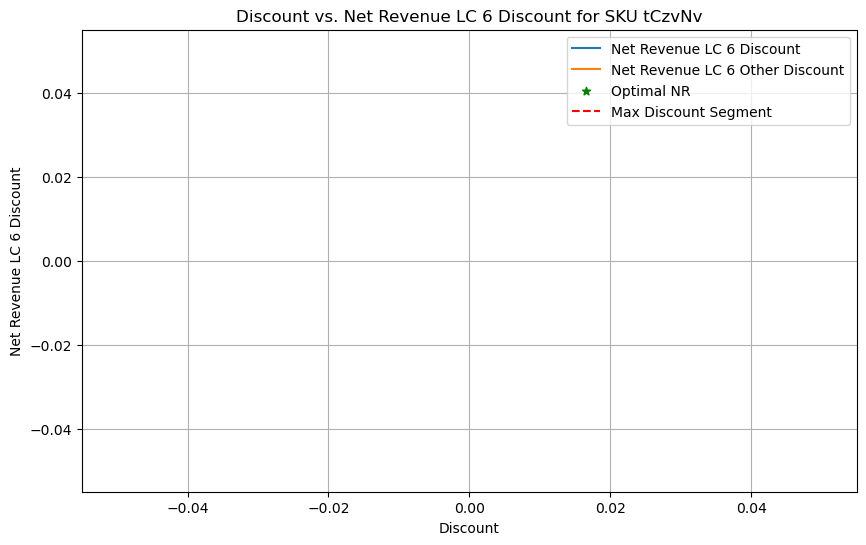

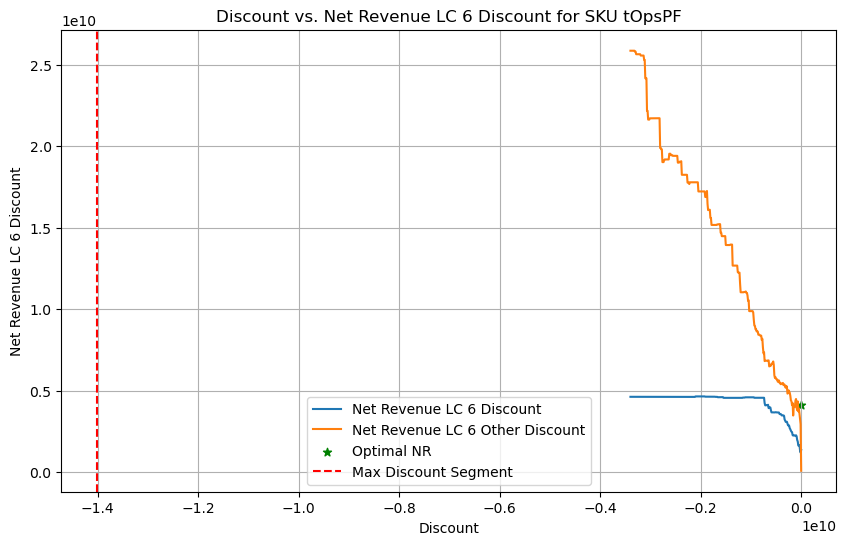

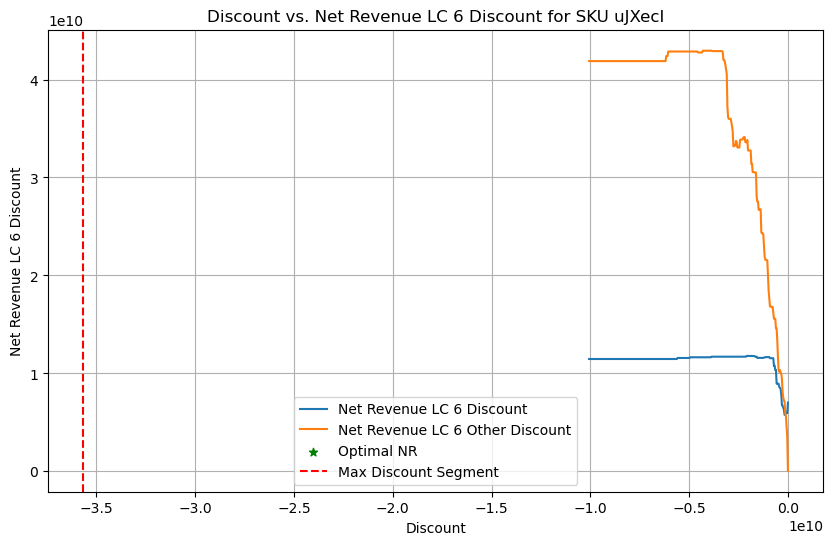

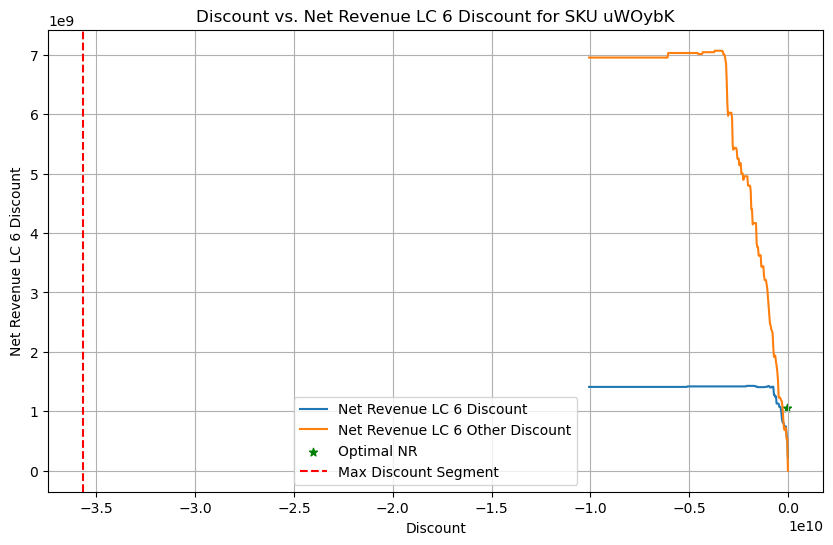

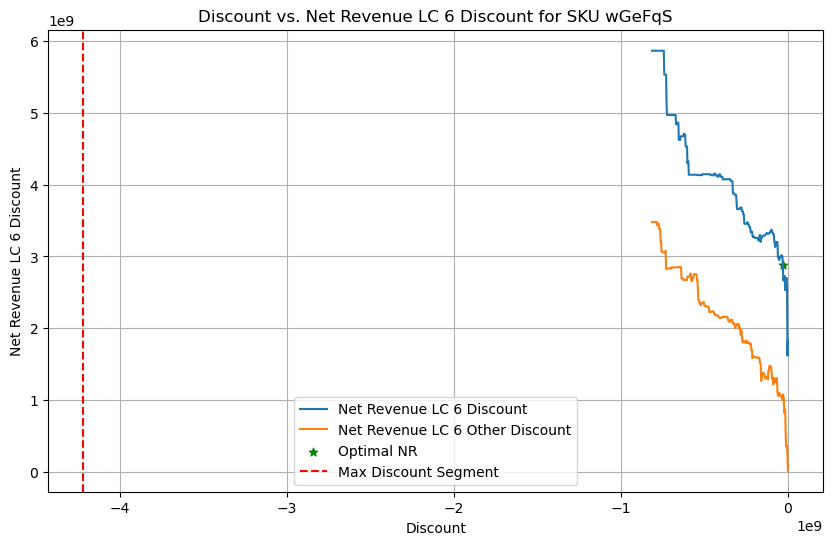

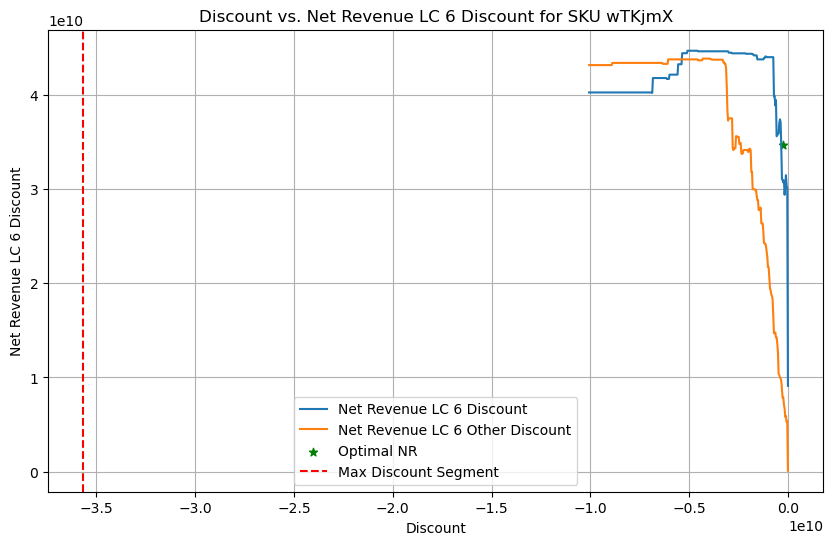

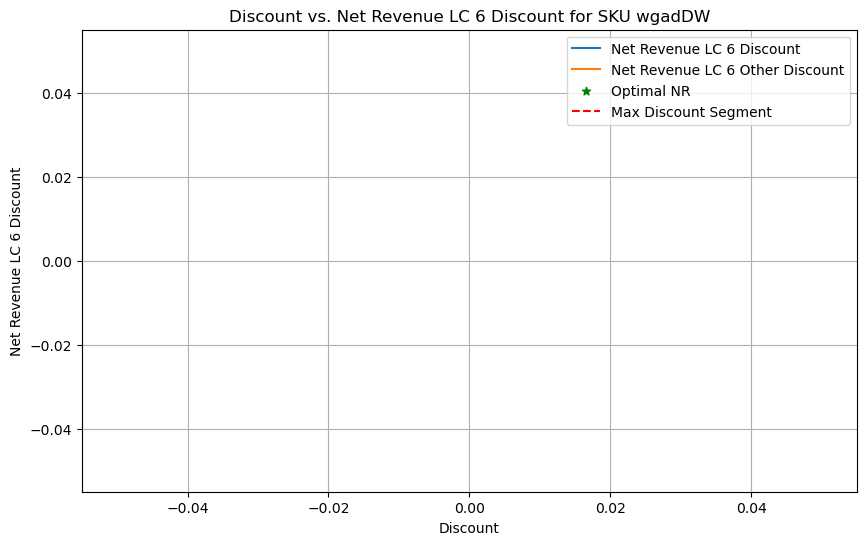

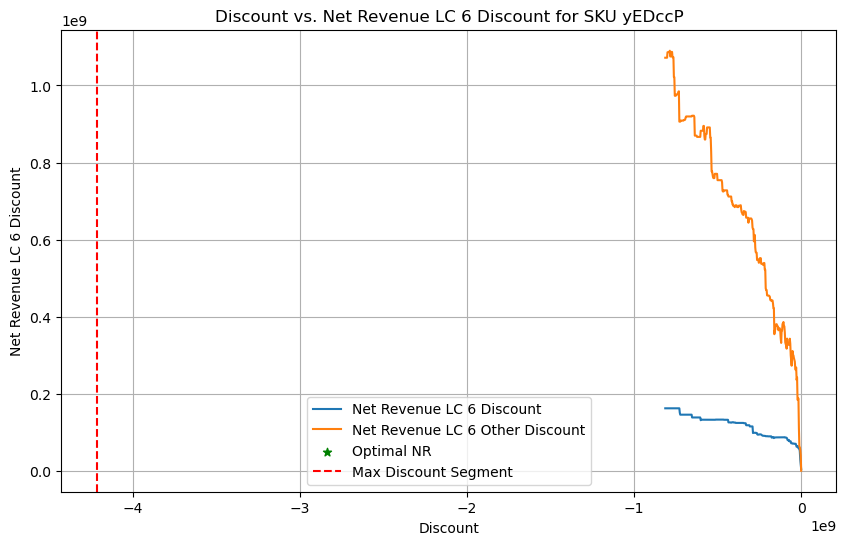

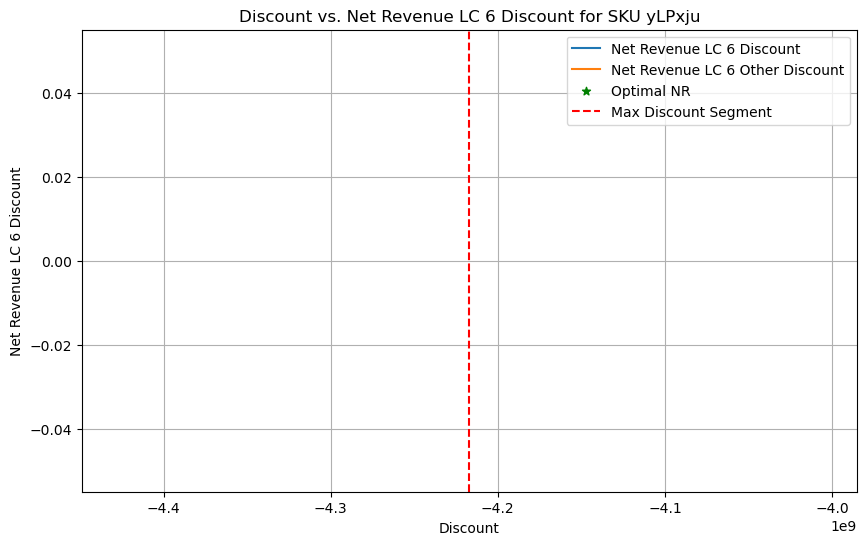

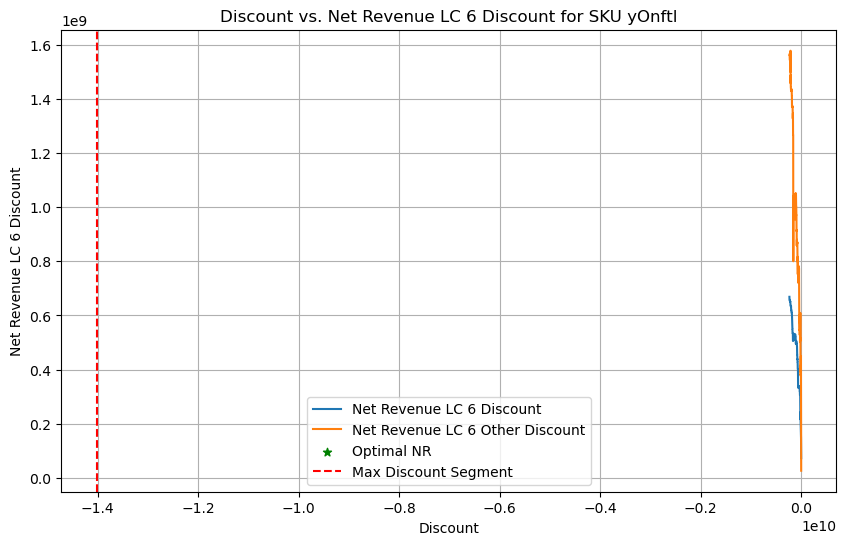

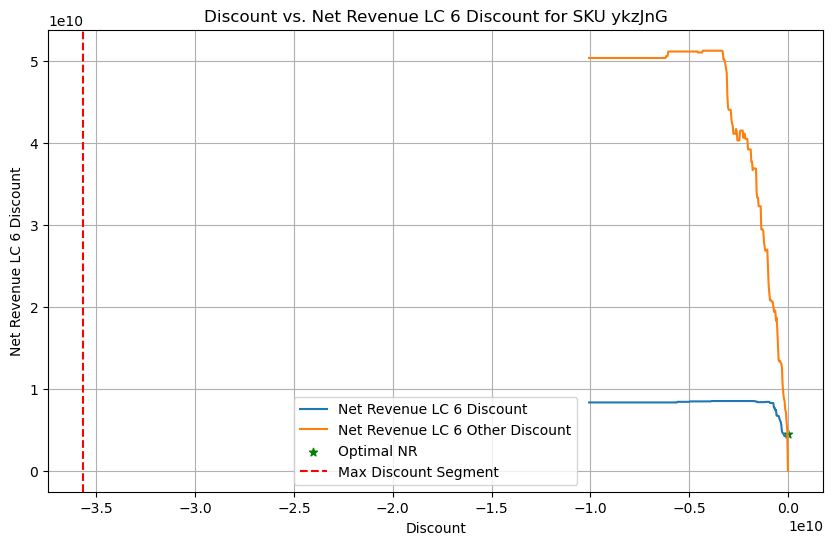

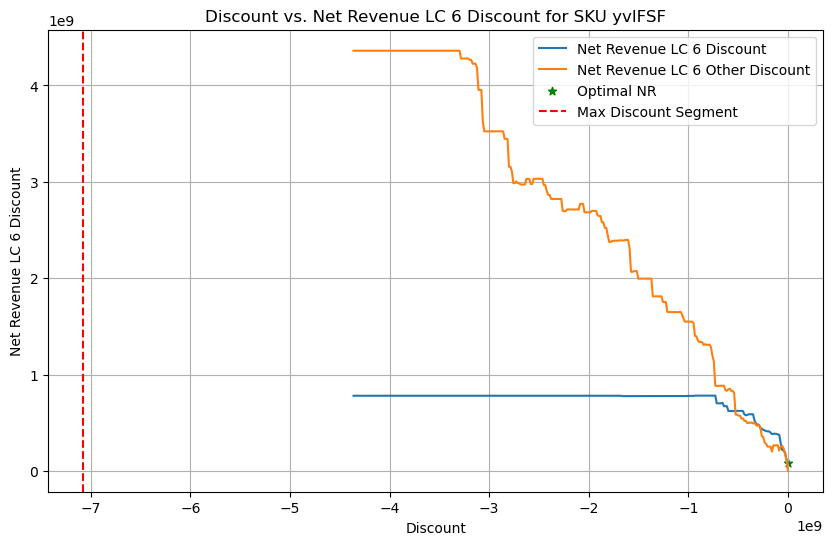

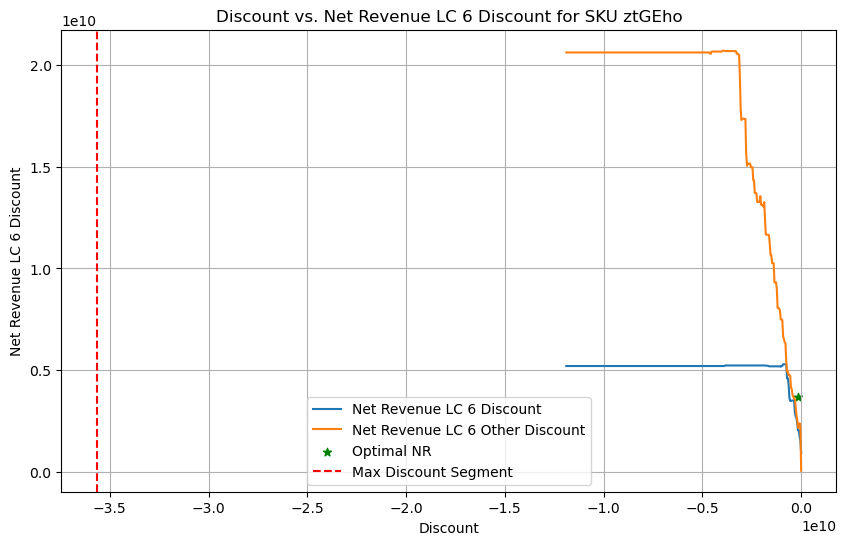

In [22]:
for sku in sku_list:
    # Filter the data for SKU current
    barrier_df4= barrier_df3[barrier_df3.SKU == sku]
    sku_filter = output_format_month_6['SKU'] == sku
    filtered_df = output_format_month_6[sku_filter]

    discount = barrier_df4['discount']
    net_revenue_discount = barrier_df4['Net_Revenue_LC_6_discount']
    net_revenue_other_discount = barrier_df4['Net_Revenue_LC_6_other_discount']
    Optimal_Net_Revenue = filtered_df['Optimal_Net_Revenue']
    optimal_amount_discount = filtered_df['Optimal_Promotional_Discount'] + filtered_df['Optimal_Other_Discount']

    plt.figure(figsize=(10, 6))
    plt.plot(discount, net_revenue_discount, label='Net Revenue LC 6 Discount')
    plt.plot(discount, net_revenue_other_discount, label='Net Revenue LC 6 Other Discount')

    plt.scatter(optimal_amount_discount, Optimal_Net_Revenue, c='green', marker='*', label='Optimal NR')
    max_discount_segment = barrier_df4[barrier_df4['SKU'] == sku]['max_discount_segment'].values[0]
    plt.axvline(x=max_discount_segment, color='red', linestyle='--', label='Max Discount Segment')
    plt.xlabel('Discount')
    plt.ylabel('Net Revenue LC 6 Discount')
    plt.title(f'Discount vs. Net Revenue LC 6 Discount for SKU {sku}')
    plt.legend()
    plt.grid()
    plt.show()

# Predictions df for month 7

In [23]:
barrier_df = pd.read_csv("Curves_month_7_predicton_300.csv")
barrier_df.head()

SKU  month      discount  Volume_Htls_month_6_discount  \
0  AjMMHY      7  0.000000e+00                   1779.198374   
1  AjMMHY      7 -1.459029e+07                   3091.313016   
2  AjMMHY      7 -2.918058e+07                   3482.634341   
3  AjMMHY      7 -4.377087e+07                   3752.307942   
4  AjMMHY      7 -5.836116e+07                   3760.099213   

   Volume_Htls_month_6_other_discount   Brand    Pack      Price_Htl  \
0                            0.600248  ZVDcKH  GUbqnp  580347.476104   
1                          200.299978  ZVDcKH  GUbqnp  580347.476104   
2                          414.005946  ZVDcKH  GUbqnp  580347.476104   
3                          397.951837  ZVDcKH  GUbqnp  580347.476104   
4                          396.754938  ZVDcKH  GUbqnp  580347.476104   

        VILC_LC  Net_Revenue_LC_6_discount  Net_Revenue_LC_6_other_discount  \
0  1.601311e+09               1.032553e+09                     3.483522e+05   
1  1.601311e+09               1.794036e+09                     1.162436e+08   
2  1.601311e+09               2.021138e+09                     2.402673e+08   
3  1.601311e+09               2.177642e+09                     2.309503e+08   
4  1.601311e+09               2.182164e+09                     2.302557e+08   

   MACO_LC_6_discount  MACO_LC_6_other_discount  
0       -5.687580e+08             -1.600963e+09  
1        1.927245e+08             -1.485068e+09  
2        4.198268e+08             -1.361044e+09  
3        5.763312e+08             -1.370361e+09  
4        5.808528e+08             -1.371056e+09

In [24]:
sales_df = output_format_month_6[['SKU','Optimal_Volume']]
sales_df.rename(columns={"Optimal_Volume":"Volume_Htls_prev_month"}, inplace=True)
sales_df.head()

C:\Users\Aneur\AppData\Local\Temp\ipykernel_17364\228382577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df.rename(columns={"Optimal_Volume":"Volume_Htls_prev_month"}, inplace=True)


SKU  Volume_Htls_prev_month
0  AjMMHY             4109.445248
1  DFBEVC            33190.299892
2  DYnHEw             9161.806878
3  DunSRa            26652.339222
4  DvLfgO              293.895271

In [25]:
barrier_df = barrier_df.merge(sales_df[['SKU','Volume_Htls_prev_month']], how="left", on="SKU")
barrier_df['actual_volume_variation'] = ((barrier_df['Volume_Htls_month_6_discount']+barrier_df['Volume_Htls_month_6_other_discount'])-barrier_df['Volume_Htls_prev_month']) / barrier_df['Volume_Htls_prev_month']
barrier_df.head()

SKU  month      discount  Volume_Htls_month_6_discount  \
0  AjMMHY      7  0.000000e+00                   1779.198374   
1  AjMMHY      7 -1.459029e+07                   3091.313016   
2  AjMMHY      7 -2.918058e+07                   3482.634341   
3  AjMMHY      7 -4.377087e+07                   3752.307942   
4  AjMMHY      7 -5.836116e+07                   3760.099213   

   Volume_Htls_month_6_other_discount   Brand    Pack      Price_Htl  \
0                            0.600248  ZVDcKH  GUbqnp  580347.476104   
1                          200.299978  ZVDcKH  GUbqnp  580347.476104   
2                          414.005946  ZVDcKH  GUbqnp  580347.476104   
3                          397.951837  ZVDcKH  GUbqnp  580347.476104   
4                          396.754938  ZVDcKH  GUbqnp  580347.476104   

        VILC_LC  Net_Revenue_LC_6_discount  Net_Revenue_LC_6_other_discount  \
0  1.601311e+09               1.032553e+09                     3.483522e+05   
1  1.601311e+09               1.794036e+09                     1.162436e+08   
2  1.601311e+09               2.021138e+09                     2.402673e+08   
3  1.601311e+09               2.177642e+09                     2.309503e+08   
4  1.601311e+09               2.182164e+09                     2.302557e+08   

   MACO_LC_6_discount  MACO_LC_6_other_discount  Volume_Htls_prev_month  \
0       -5.687580e+08             -1.600963e+09             4109.445248   
1        1.927245e+08             -1.485068e+09             4109.445248   
2        4.198268e+08             -1.361044e+09             4109.445248   
3        5.763312e+08             -1.370361e+09             4109.445248   
4        5.808528e+08             -1.371056e+09             4109.445248   

   actual_volume_variation  
0                -0.566901  
1                -0.199013  
2                -0.051784  
3                 0.009932  
4                 0.011537

In [26]:
barrier_df2 = barrier_df.merge(vol_var_const_df[['SKU','Size','Minimum Volume Variation',
                                                 "Maximum Volume Variation"]], 
                                how="left", on="SKU")
barrier_df2.rename(columns={'Minimum Volume Variation':'min_vol_variation_constraint',
                            "Maximum Volume Variation":'max_vol_variation_constraint'},inplace=True)

# Fill na values from the volume variation dataset
barrier_df2['min_vol_variation_constraint'] = barrier_df2['min_vol_variation_constraint'].fillna(0) # Ensure a positive outlook on volume variation

max_percentage = 0.091
barrier_df2['max_vol_variation_constraint'] = barrier_df2['max_vol_variation_constraint'].apply(lambda x: min(x, max_percentage))
barrier_df2['max_vol_variation_constraint'].fillna(max_percentage, inplace=True)

barrier_df2['Size'] = barrier_df2['Size'].fillna("")
barrier_df2

SKU  month      discount  Volume_Htls_month_6_discount  \
0      AjMMHY      7  0.000000e+00                   1779.198374   
1      AjMMHY      7 -1.459029e+07                   3091.313016   
2      AjMMHY      7 -2.918058e+07                   3482.634341   
3      AjMMHY      7 -4.377087e+07                   3752.307942   
4      AjMMHY      7 -5.836116e+07                   3760.099213   
...       ...    ...           ...                           ...   
22805  ztGEho      7 -1.173146e+10                  10153.875488   
22806  ztGEho      7 -1.177123e+10                  10153.875488   
22807  ztGEho      7 -1.181099e+10                  10153.875488   
22808  ztGEho      7 -1.185076e+10                  10153.875488   
22809  ztGEho      7 -1.189053e+10                  10153.875488   

       Volume_Htls_month_6_other_discount   Brand    Pack      Price_Htl  \
0                                0.600248  ZVDcKH  GUbqnp  580347.476104   
1                              200.299978  ZVDcKH  GUbqnp  580347.476104   
2                              414.005946  ZVDcKH  GUbqnp  580347.476104   
3                              397.951837  ZVDcKH  GUbqnp  580347.476104   
4                              396.754938  ZVDcKH  GUbqnp  580347.476104   
...                                   ...     ...     ...            ...   
22805                        40488.962116  oKraYa  GUbqnp  512090.249806   
22806                        40488.962116  oKraYa  GUbqnp  512090.249806   
22807                        40488.962116  oKraYa  GUbqnp  512090.249806   
22808                        40488.962116  oKraYa  GUbqnp  512090.249806   
22809                        40488.962116  oKraYa  GUbqnp  512090.249806   

            VILC_LC  Net_Revenue_LC_6_discount  \
0      1.601311e+09               1.032553e+09   
1      1.601311e+09               1.794036e+09   
2      1.601311e+09               2.021138e+09   
3      1.601311e+09               2.177642e+09   
4      1.601311e+09               2.182164e+09   
...             ...                        ...   
22805  1.884897e+09               5.199701e+09   
22806  1.884897e+09               5.199701e+09   
22807  1.884897e+09               5.199701e+09   
22808  1.884897e+09               5.199701e+09   
22809  1.884897e+09               5.199701e+09   

       Net_Revenue_LC_6_other_discount  MACO_LC_6_discount  \
0                         3.483522e+05       -5.687580e+08   
1                         1.162436e+08        1.927245e+08   
2                         2.402673e+08        4.198268e+08   
3                         2.309503e+08        5.763312e+08   
4                         2.302557e+08        5.808528e+08   
...                                ...                 ...   
22805                     2.073400e+10        3.314803e+09   
22806                     2.073400e+10        3.314803e+09   
22807                     2.073400e+10        3.314803e+09   
22808                     2.073400e+10        3.314803e+09   
22809                     2.073400e+10        3.314803e+09   

       MACO_LC_6_other_discount  Volume_Htls_prev_month  \
0                 -1.600963e+09             4109.445248   
1                 -1.485068e+09             4109.445248   
2                 -1.361044e+09             4109.445248   
3                 -1.370361e+09             4109.445248   
4                 -1.371056e+09             4109.445248   
...                         ...                     ...   
22805              1.884911e+10             7196.609742   
22806              1.884911e+10             7196.609742   
22807              1.884911e+10             7196.609742   
22808              1.884911e+10             7196.609742   
22809              1.884911e+10             7196.609742   

       actual_volume_variation    Size  min_vol_variation_constraint  \
0                    -0.566901                              0.000000   
1                    -0.199013                              0.000000   
2        

In [27]:
max_discount_const_brand = pd.read_excel("Input Data/maximum_discount_constraint_hackathon.xlsx", sheet_name="Brand")
max_discount_const_brand.rename(columns={"max_discount":"max_discount_brand"}, inplace=True)
max_discount_const_pack = pd.read_excel("Input Data/maximum_discount_constraint_hackathon.xlsx", sheet_name="Pack")
max_discount_const_pack.rename(columns={"max_discount":"max_discount_pack"}, inplace=True)
max_discount_const_price_segment = pd.read_excel("Input Data/maximum_discount_constraint_hackathon.xlsx", sheet_name="PriceSegment")
max_discount_const_price_segment.rename(columns={"max_discount":"max_discount_segment"}, inplace=True)
brand_price_segment = pd.read_excel("Input Data/brand_segment_mapping_hackathon.xlsx")
max_discount_const_brand = max_discount_const_brand.merge(brand_price_segment, how='left')
max_discount_const_brand = max_discount_const_brand.merge(max_discount_const_price_segment, how='left')

In [28]:
max_discount_const_brand['month'] = max_discount_const_brand['Month'].astype(int)
del max_discount_const_brand['Month']
del max_discount_const_brand['Year']
barrier_df3 = barrier_df2.merge(max_discount_const_brand, how="left")
barrier_df3

SKU  month      discount  Volume_Htls_month_6_discount  \
0      AjMMHY      7  0.000000e+00                   1779.198374   
1      AjMMHY      7 -1.459029e+07                   3091.313016   
2      AjMMHY      7 -2.918058e+07                   3482.634341   
3      AjMMHY      7 -4.377087e+07                   3752.307942   
4      AjMMHY      7 -5.836116e+07                   3760.099213   
...       ...    ...           ...                           ...   
22805  ztGEho      7 -1.173146e+10                  10153.875488   
22806  ztGEho      7 -1.177123e+10                  10153.875488   
22807  ztGEho      7 -1.181099e+10                  10153.875488   
22808  ztGEho      7 -1.185076e+10                  10153.875488   
22809  ztGEho      7 -1.189053e+10                  10153.875488   

       Volume_Htls_month_6_other_discount   Brand    Pack      Price_Htl  \
0                                0.600248  ZVDcKH  GUbqnp  580347.476104   
1                              200.299978  ZVDcKH  GUbqnp  580347.476104   
2                              414.005946  ZVDcKH  GUbqnp  580347.476104   
3                              397.951837  ZVDcKH  GUbqnp  580347.476104   
4                              396.754938  ZVDcKH  GUbqnp  580347.476104   
...                                   ...     ...     ...            ...   
22805                        40488.962116  oKraYa  GUbqnp  512090.249806   
22806                        40488.962116  oKraYa  GUbqnp  512090.249806   
22807                        40488.962116  oKraYa  GUbqnp  512090.249806   
22808                        40488.962116  oKraYa  GUbqnp  512090.249806   
22809                        40488.962116  oKraYa  GUbqnp  512090.249806   

            VILC_LC  Net_Revenue_LC_6_discount  ...  MACO_LC_6_discount  \
0      1.601311e+09               1.032553e+09  ...       -5.687580e+08   
1      1.601311e+09               1.794036e+09  ...        1.927245e+08   
2      1.601311e+09               2.021138e+09  ...        4.198268e+08   
3      1.601311e+09               2.177642e+09  ...        5.763312e+08   
4      1.601311e+09               2.182164e+09  ...        5.808528e+08   
...             ...                        ...  ...                 ...   
22805  1.884897e+09               5.199701e+09  ...        3.314803e+09   
22806  1.884897e+09               5.199701e+09  ...        3.314803e+09   
22807  1.884897e+09               5.199701e+09  ...        3.314803e+09   
22808  1.884897e+09               5.199701e+09  ...        3.314803e+09   
22809  1.884897e+09               5.199701e+09  ...        3.314803e+09   

       MACO_LC_6_other_discount  Volume_Htls_prev_month  \
0                 -1.600963e+09             4109.445248   
1                 -1.485068e+09             4109.445248   
2                 -1.361044e+09             4109.445248   
3                 -1.370361e+09             4109.445248   
4                 -1.371056e+09             4109.445248   
...                         ...                     ...   
22805              1.884911e+10             7196.609742   
22806              1.884911e+10             7196.609742   
22807              1.884911e+10             7196.609742   
22808              1.884911e+10             7196.609742   
22809              1.884911e+10             7196.609742   

       actual_volume_variation    Size min_vol_variation_constraint  \
0                    -0.566901                             0.000000   
1                    -0.199013                             0.000000   
2                    -0.051784                             0.000000   
3                     0.009932                             0.000000   
4                     0.011537                             0.000000   
...                        ...     ...                          ...   
22805                 6.037041  drgWuE                    -0.541302   
22806                 6.037041  drgWuE                    -0.541302   
22807                 6.037041 

In [29]:
barrier_df3.columns

Index(['SKU', 'month', 'discount', 'Volume_Htls_month_6_discount',
       'Volume_Htls_month_6_other_discount', 'Brand', 'Pack', 'Price_Htl',
       'VILC_LC', 'Net_Revenue_LC_6_discount',
       'Net_Revenue_LC_6_other_discount', 'MACO_LC_6_discount',
       'MACO_LC_6_other_discount', 'Volume_Htls_prev_month',
       'actual_volume_variation', 'Size', 'min_vol_variation_constraint',
       'max_vol_variation_constraint', 'max_discount_brand', 'PriceSegment',
       'max_discount_segment'],
      dtype='object')

In [30]:
barrier_df3[['discount', 'Volume_Htls_month_6_discount',
   'Volume_Htls_month_6_other_discount', 'Price_Htl',
   'VILC_LC', 'Net_Revenue_LC_6_discount',
   'Net_Revenue_LC_6_other_discount']] = barrier_df3[['discount', 'Volume_Htls_month_6_discount',
   'Volume_Htls_month_6_other_discount', 'Price_Htl',
   'VILC_LC', 'Net_Revenue_LC_6_discount',
   'Net_Revenue_LC_6_other_discount']].replace('#NAME?', 0).astype(float)

In [31]:
sku_list = barrier_df3.SKU.unique()
output_format_df_list = []

for sku in sku_list:
    df = barrier_df3.copy()
    df = df[df.SKU == sku]
    # Impose some constraints by brute force since sometimes COBYLA does not converge to an optimal solution
    df = df[(df.actual_volume_variation >= df.min_vol_variation_constraint) & (df.actual_volume_variation <= df.max_vol_variation_constraint) & \
            (df.discount >= df.max_discount_brand)]

    # Define the objective function to maximize net revenue while penalizing large values of total discount.
    def objective(x):
        ''' Definition of the objective function to maximize net revenue and minimize investment.
        TODO: Try implementing the constraints as a log barrier to the objective function (INTERIOR POINT METHOD).
        '''
        discount, Volume_Htls_log_6_discount, Volume_Htls_log_6_other_discount, Net_Revenue_LC_6_discount, Net_Revenue_LC_6_other_discount = x    
        # Calculate net revenue for the entire DataFrame
        net_revenue = (df['Net_Revenue_LC_6_discount'] + df['Net_Revenue_LC_6_other_discount']).sum()
        net_revenue = net_revenue - (0.1 * df['discount'].sum())
        return -net_revenue

    # Define the inequality constraint function
    def constraints(x):
        discount, _, _, _, _ = x
        prob_bound = discount - df['max_discount_brand'].values
        return prob_bound

    # Initial guess for the variables
    min_discount = df['discount'].min()
    min_volume_discount = df['Volume_Htls_month_6_discount'].min()
    min_volume_other_discount = df['Volume_Htls_month_6_other_discount'].min()
    min_nr_discount = df['Net_Revenue_LC_6_discount'].min()
    min_nr_other_discount = df['Net_Revenue_LC_6_other_discount'].min()

    x0 = [min_discount, min_volume_discount, min_volume_other_discount, min_nr_discount, min_nr_other_discount]

    # Define bounds for the variables
    bounds = [(0, 0), (0, df['Volume_Htls_month_6_discount'].max()), (0, df['Volume_Htls_month_6_other_discount'].max()),
            (0, df['Net_Revenue_LC_6_discount'].max()), (0, df['Net_Revenue_LC_6_other_discount'].max())]

    constraints = [{'type': 'ineq', 'fun': constraints}]

    # Solve the optimization problem
    result = minimize(objective, x0, method='COBYLA', bounds=bounds, constraints=constraints, options={'maxiter': 1000})

    # Extract optimal values
    optimal_discount, optimal_Volume_Htls_log_6_discount, optimal_Volume_Htls_log_6_other_discount, \
    optimal_Net_Revenue_LC_6_discount, optimal_Net_Revenue_LC_6_other_discount = result.x

    df_to_stack_discounts = df[['month','SKU','Brand', 'Pack', 'Size']].drop_duplicates()
    df_to_stack_discounts['Optimal_Promotional_Discount'] = optimal_discount * (optimal_Volume_Htls_log_6_discount/(optimal_Volume_Htls_log_6_discount+optimal_Volume_Htls_log_6_other_discount))
    df_to_stack_discounts['Optimal_Other_Discount'] = optimal_discount * (optimal_Volume_Htls_log_6_other_discount/(optimal_Volume_Htls_log_6_discount+optimal_Volume_Htls_log_6_other_discount))
    df_to_stack_discounts['Optimal_Volume'] = optimal_Volume_Htls_log_6_discount + optimal_Volume_Htls_log_6_other_discount
    df_to_stack_discounts['Optimal_Net_Revenue'] = optimal_Net_Revenue_LC_6_discount + optimal_Net_Revenue_LC_6_other_discount
    output_format_df_list.append(df_to_stack_discounts)

In [32]:
output_format_month_7 = pd.concat(output_format_df_list, ignore_index=True)

In [55]:
output_format_month = pd.concat([output_format_month_6, output_format_month_7], ignore_index=True)
output_format_month['Year'] = 2023
output_format_month.head()

month     SKU   Brand    Pack    Size  Optimal_Promotional_Discount  \
0      6  AjMMHY  ZVDcKH  GUbqnp                         -5.239968e+07   
1      6  DFBEVC  oKraYa  mmgsXK  LnpBuL                  0.000000e+00   
2      6  DYnHEw  JKAQQU  GUbqnp  StircS                 -1.975987e+07   
3      6  DunSRa  ZWPpTt  mmgsXK  WbVFEW                 -1.980423e+07   
4      6  DvLfgO  aYZJQW  gydWlH  StircS                 -5.397149e+05   

   Optimal_Other_Discount  Optimal_Volume  Optimal_Net_Revenue  Year  
0           -5.960486e+06     4109.445248         2.384906e+09  2023  
1            0.000000e+00    33190.299892         1.285181e+10  2023  
2           -1.691648e+03     9161.806878         3.601806e+09  2023  
3           -1.958302e+04    26652.339222         8.789636e+09  2023  
4           -1.683799e+03      293.895271         2.363927e+08  2023

In [54]:
df_pred = pd.read_csv("df_pred_.csv")
df_pred.head()

SKU  month  Promotional_Discount_LC   Volume_Htls_log   Volume_Htls   \
0  AjMMHY      7        (4,362,496,863.23)             6.89        985.69    
1  CPXipv      7        (3,397,812,694.50)             6.98      1,072.29    
2  CpWPBT      7                       NaN               NaN           NaN   
3  DFBEVC      7       (11,890,528,023.73)            10.92     55,352.20    
4  DGeaFa      7        (4,362,496,863.23)             2.89         18.01    

    Brand    Pack    Price_Htl             VILC_LC                   NR   \
0  ZVDcKH  GUbqnp   580,347.48    1,601,311,252.69       572,044,405.90    
1  ZfEWxz  GUbqnp   655,962.38      237,176,202.20       703,380,305.85    
2  erVQIv  GUbqnp   564,723.21          (32,897.14)                  NaN   
3  oKraYa  mmgsXK   387,215.72    4,344,674,304.18    21,433,239,941.80    
4  ZVDcKH  GUbqnp   715,774.66        4,899,112.54        12,891,017.57    

              MACO_LC   
0   (1,029,266,846.79)  
1      466,204,103.65   
2                  NaN  
3   17,088,565,637.62   
4        7,991,905.03

In [50]:
df_pred.columns

Index(['SKU', 'month', ' Promotional_Discount_LC ', ' Volume_Htls_log ',
       ' Volume_Htls ', 'Brand', 'Pack', ' Price_Htl ', ' VILC_LC ', ' NR ',
       ' MACO_LC '],
      dtype='object')

In [56]:
df_pred.rename(columns={' Volume_Htls ':"Volume_Estimate",
                        ' NR ':"Net_Revenue_estimate"}, inplace=True)
output_format_month = output_format_month.merge(df_pred[['SKU','month',
                                                         'Volume_Estimate','Net_Revenue_estimate']], how="left")
output_format_month

month     SKU   Brand    Pack    Size  Optimal_Promotional_Discount  \
0       6  AjMMHY  ZVDcKH  GUbqnp                         -5.239968e+07   
1       6  DFBEVC  oKraYa  mmgsXK  LnpBuL                  0.000000e+00   
2       6  DYnHEw  JKAQQU  GUbqnp  StircS                 -1.975987e+07   
3       6  DunSRa  ZWPpTt  mmgsXK  WbVFEW                 -1.980423e+07   
4       6  DvLfgO  aYZJQW  gydWlH  StircS                 -5.397149e+05   
5       6  EWpIvF  ddBknG  mmgsXK  StircS                 -2.685090e+07   
6       6  JahmoZ  LoYUOg  GUbqnp                         -2.566456e+06   
7       6  KaRAzM  ZVDcKH  gydWlH                         -2.017652e+07   
8       6  NCZaeT  XVgSwQ  mmgsXK  StircS                 -1.379212e+07   
9       6  NDjGwG  aYZJQW  VmwBmS  pKILVK                 -4.544109e+05   
10      6  PHzOQX  czPDot  mmgsXK  NjMiGQ                 -9.285711e+06   
11      6  QKbkNh  ZWPqNN  gydWlH                          0.000000e+00   
12      6  QTYoqf  OmUaam  mmgsXK  WbVFEW                 -3.354440e+07   
13      6  RYuxMo  ddBknG  rwGJlW  isvUwn                 -2.711373e+06   
14      6  UkcAGg  ZWPpTt  mmgsXK  StircS                 -3.653724e+08   
15      6  YIKcZa  ZWPpTt  GUbqnp  StircS                 -1.138142e+08   
16      6  ayIjfQ  oKraYa  mmgsXK  StircS                 -3.919107e+08   
17      6  djCgzJ  oKraYa  GUbqnp  drgWuE                  0.000000e+00   
18      6  dtGgfn  VXgxLc  mmgsXK                         -6.021076e+06   
19      6  fWkemq  ZVDcKH  mmgsXK  StircS                 -4.912879e+07   
20      6  hIrbWp  OmUaam  mmgsXK  StircS                 -3.509725e+08   
21      6  jpXhdU  LoYUOg  mmgsXK  StircS                 -7.941097e+05   
22      6  lOLcFD  pspMdo  GUbqnp  StircS                 -2.843878e+07   
23      6  lWqqqR  ZfEWxz  GUbqnp  XotyGb                 -1.265926e+08   
24      6  mRxjWU  oKraYa  GUbqnp  StircS                 -4.408685e+08   
25      6  nXuqgq  tcqKyp  gydWlH  StircS                 -6.073686e+05   
26      6  nrllcF  ZVDcKH  GUbqnp  StircS                 -4.922332e+07   
27      6  tOpsPF  ZfEWxz  gydWlH  LlylGT                 -3.279448e+06   
28      6  uWOybK  OmUaam  gydWlH                         -3.303984e+07   
29      6  wGeFqS  ddBknG  GUbqnp  StircS                 -2.385819e+07   
30      6  wTKjmX  OmUaam  GUbqnp  StircS                 -2.284951e+08   
31      6  ykzJnG  OmUaam  mmgsXK  CTOGzl                  0.000000e+00   
32      6  yvlFSF  ZVDcKH  VmwBmS  pKILVK                  0.000000e+00   
33      6  ztGEho  oKraYa  GUbqnp  drgWuE                 -6.610156e+07   
34      7  AjMMHY  ZVDcKH  GUbqnp                         -5.277946e+07   
35      7  DFBEVC  oKraYa  mmgsXK  LnpBuL                  0.000000e+00   
36      7  DYnHEw  JKAQQU  GUbqnp  StircS                 -6.585979e+06   
37      7  DvLfgO  aYZJQW  gydWlH  StircS                 -5.397608e+05   
38      7  NDjGwG  aYZJQW  VmwBmS  pKILVK                 -2.282840e+05   
39      7  UkcAGg  ZWPpTt  mmgsXK  StircS                 -3.137944e+08   
40      7  YIKcZa  ZWPpTt  GUbqnp  StircS                 -1.456288e+07   
41      7  ayIjfQ  oKraYa  mmgsXK  StircS                 -3.134144e+08   
42      7  djCgzJ  oKraYa  GUbqnp  drgWuE                  0.000000e+00   
43      7  dtGgfn  VXgxLc  mmgsXK                         -5.949195e+06   
44      7  fWkemq  ZVDcKH  mmgsXK  StircS                 -8.160299e+06   
45      7  hIrbWp  OmUaam  mmgsXK  StircS                 -2.765682e+08   
46      7  jpXhdU  LoYUOg  mmgsXK  StircS                 -7.955646e+05   
47      7  lOLcFD  pspMdo  GUbqnp  StircS                 -1.625043e+07   
48      7  lWqqqR  ZfEWxz  GUbqnp  XotyGb                 -4.569996e+07   
49      7  mRxjWU  oKraYa  GUbqnp  StircS                 -2.426716e+08   
50      7  nXuqgq  tcqKyp  gydWlH  StircS                  0.000000e+00   
51      7  nrllcF  ZVDcKH  GUbqnp  StircS                 -1.252599e+07   
52      7  tOpsPF  ZfEWxz  gy

In [57]:
output_format_month = output_format_month[['Year','month', 'SKU', 'Brand', 'Pack', 'Size', 
                                           'Volume_Estimate','Net_Revenue_estimate',
                                           'Optimal_Promotional_Discount',
                                           'Optimal_Other_Discount', 
                                           'Optimal_Volume', 
                                           'Optimal_Net_Revenue']]
output_format_month.sort_values(by=['SKU','month'], inplace=True)
output_format_month.to_excel("output_format_month.xlsx", index=False)

In [58]:
output_format_month.to_csv("output_format_month.csv")

### Plot optimal net revenue distributions

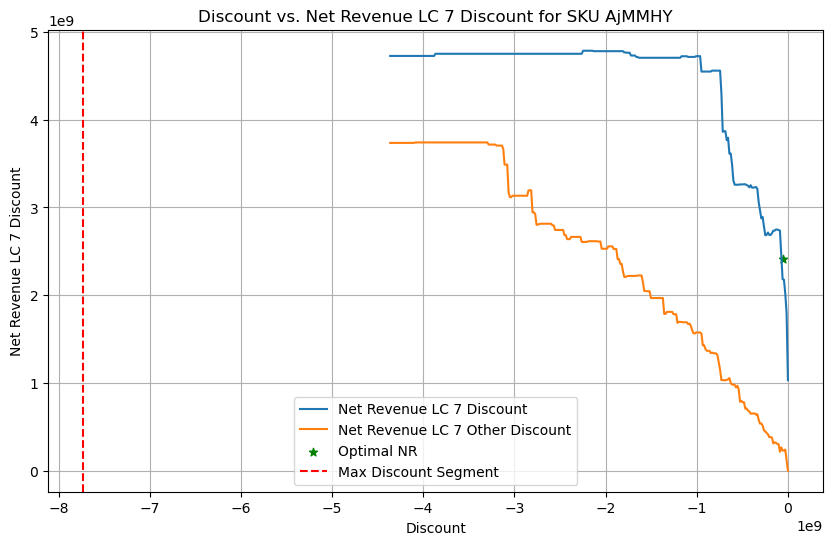

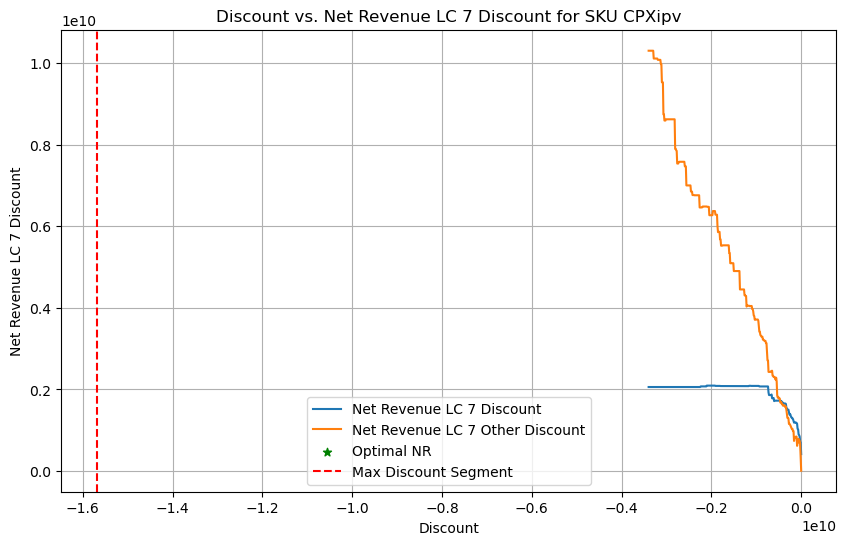

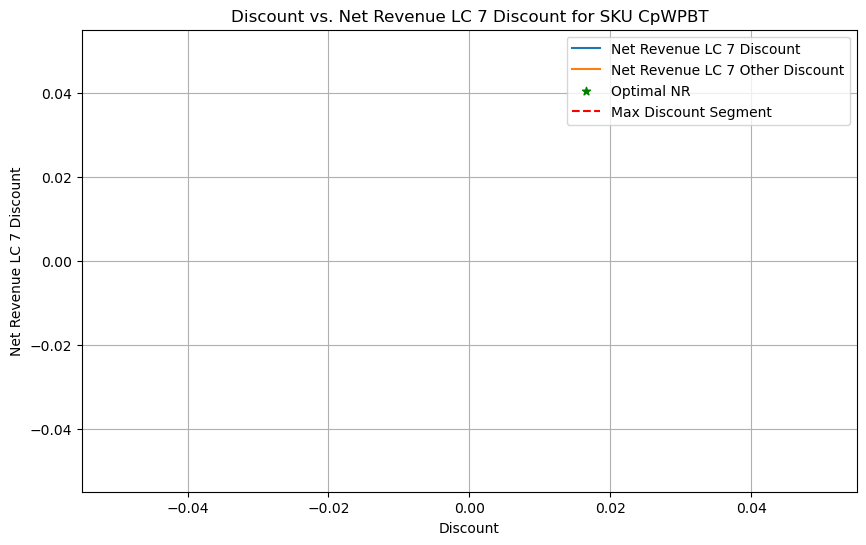

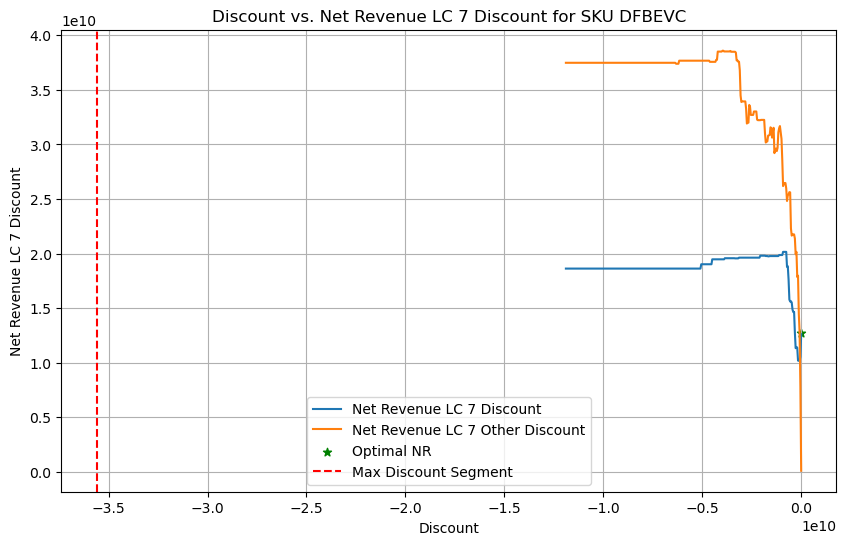

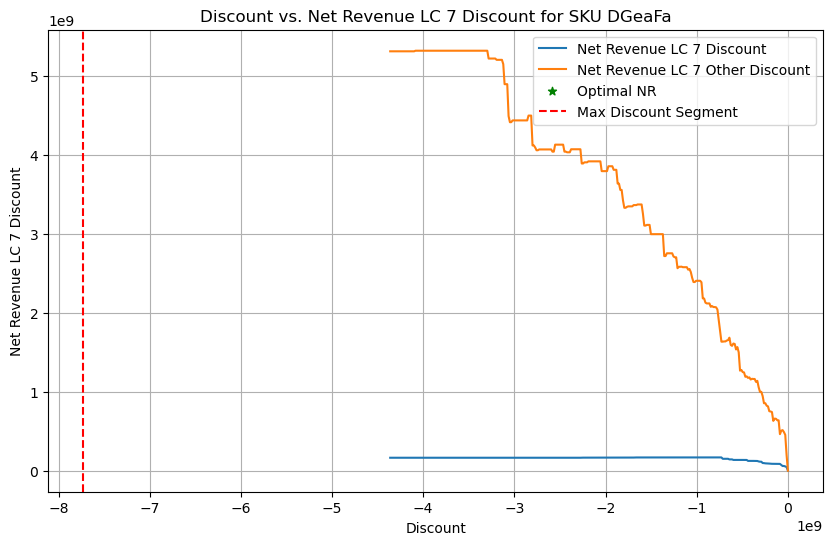

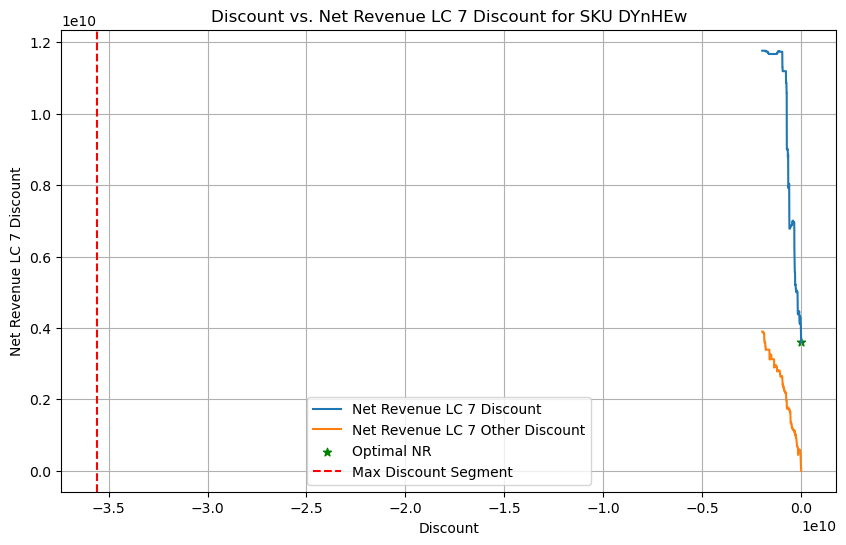

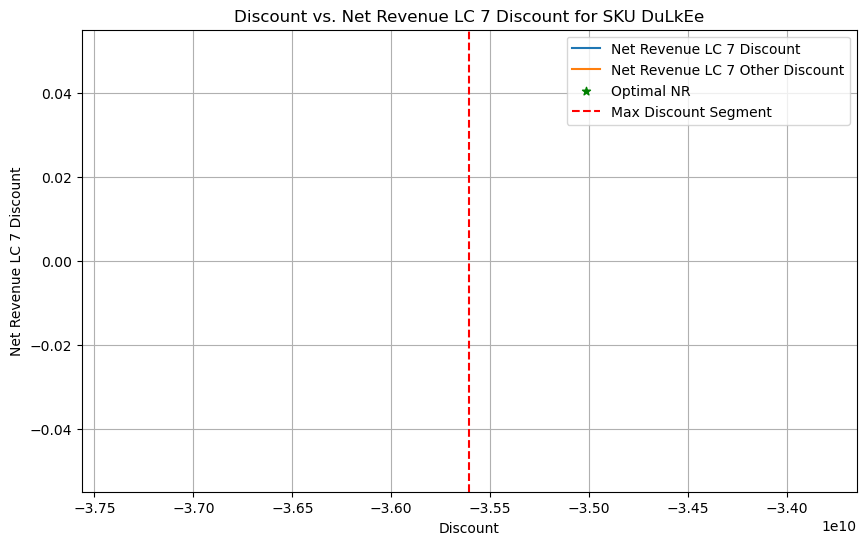

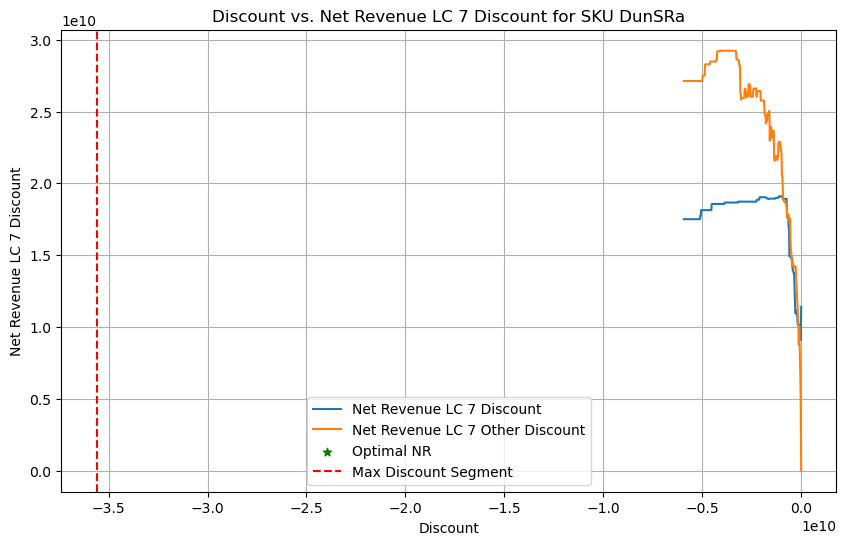

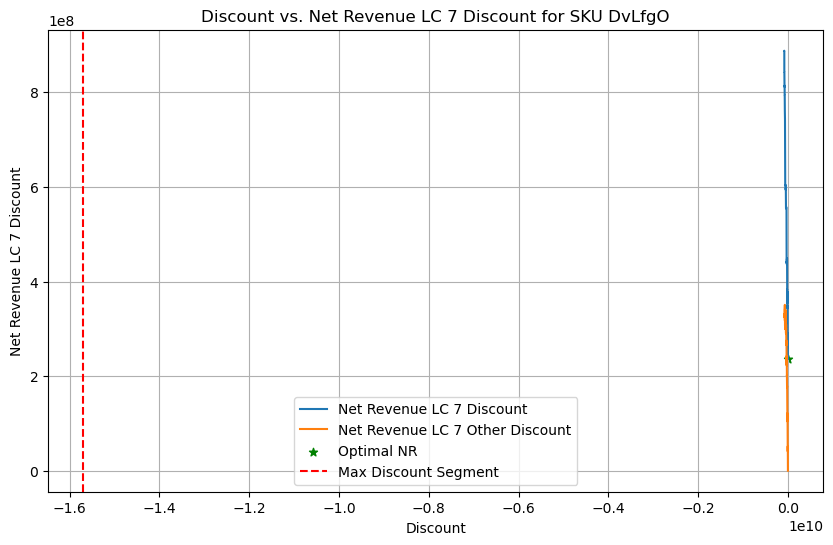

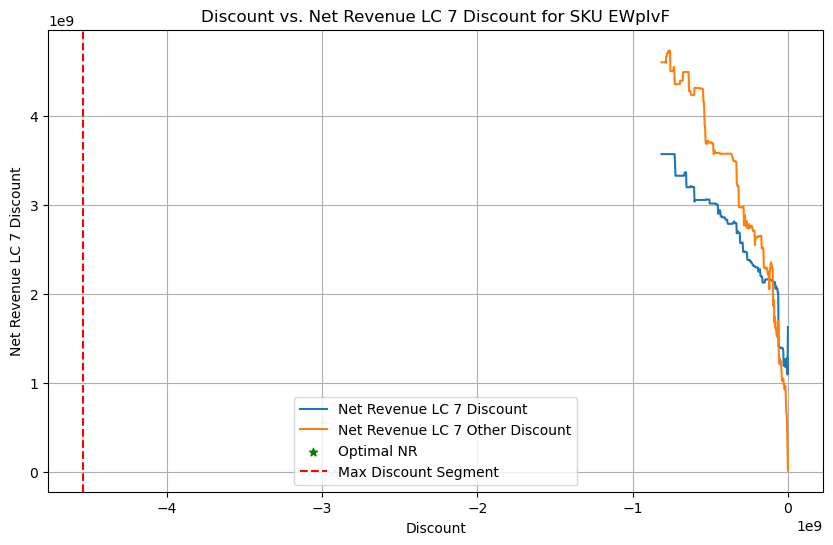

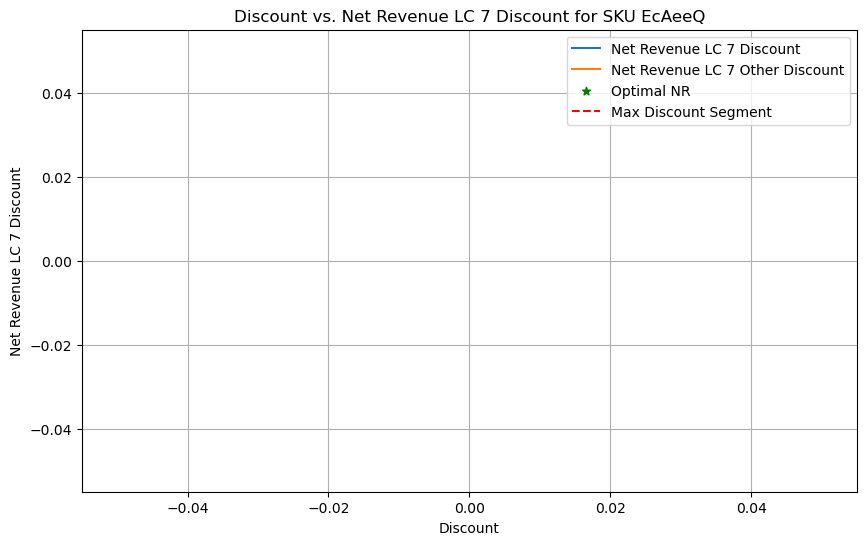

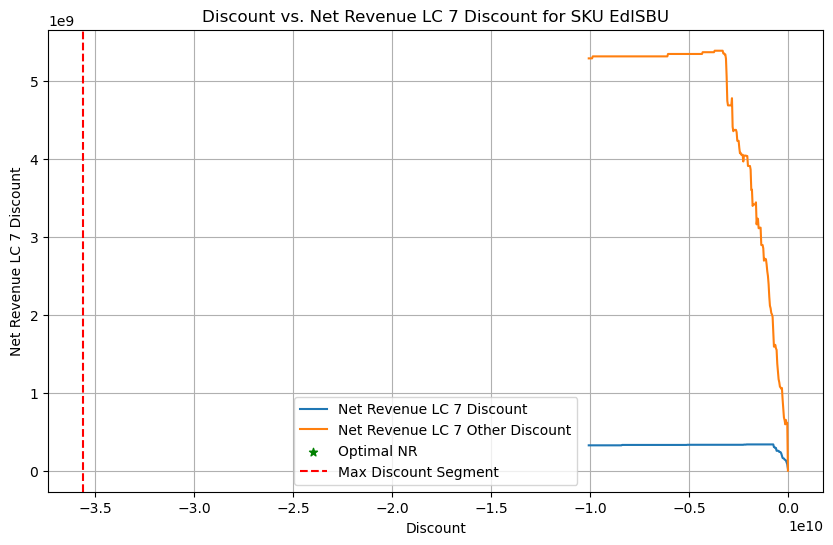

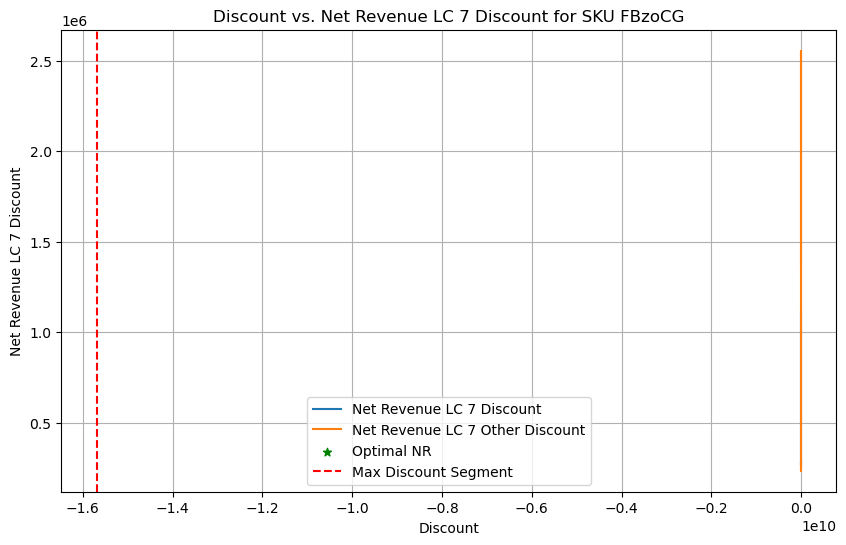

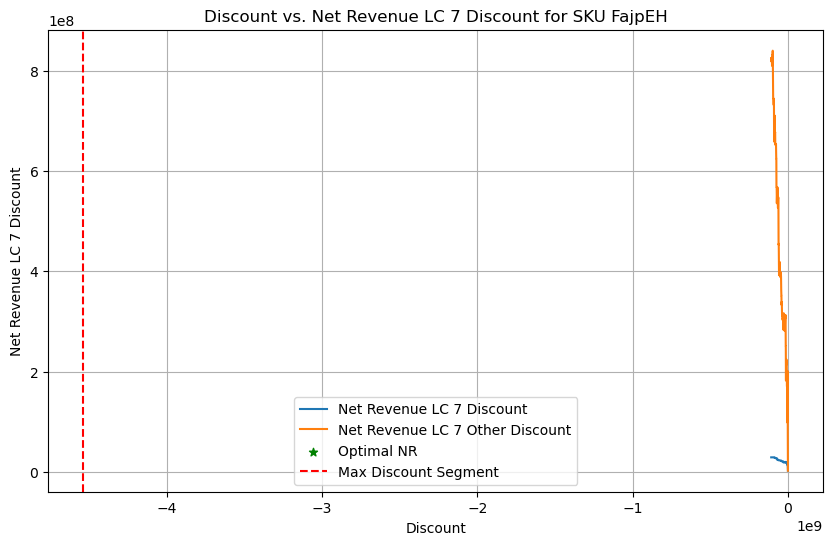

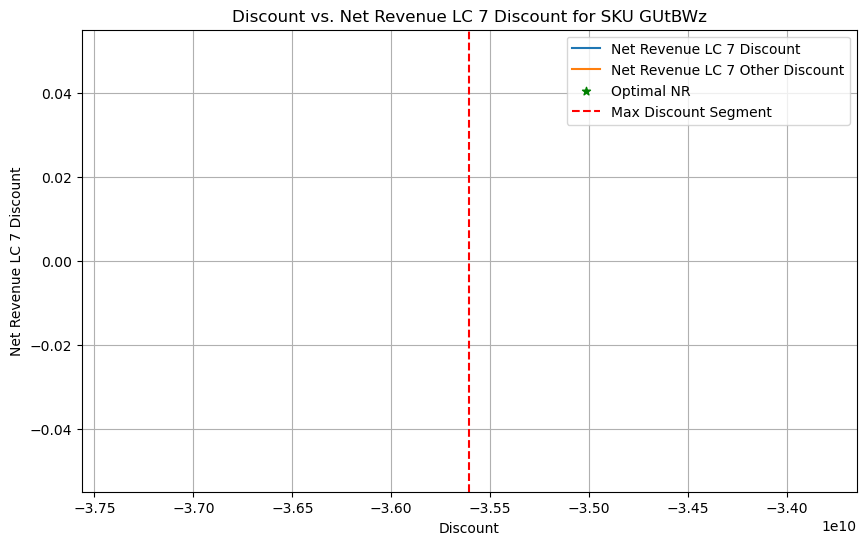

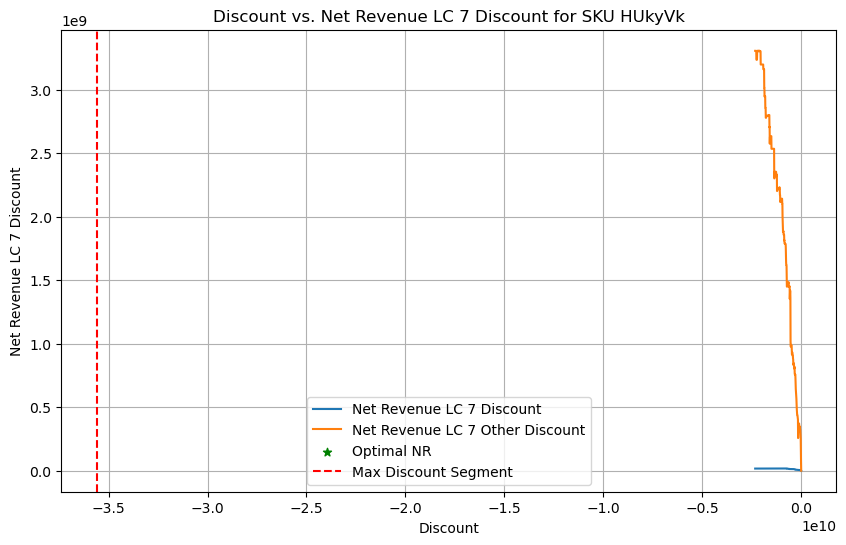

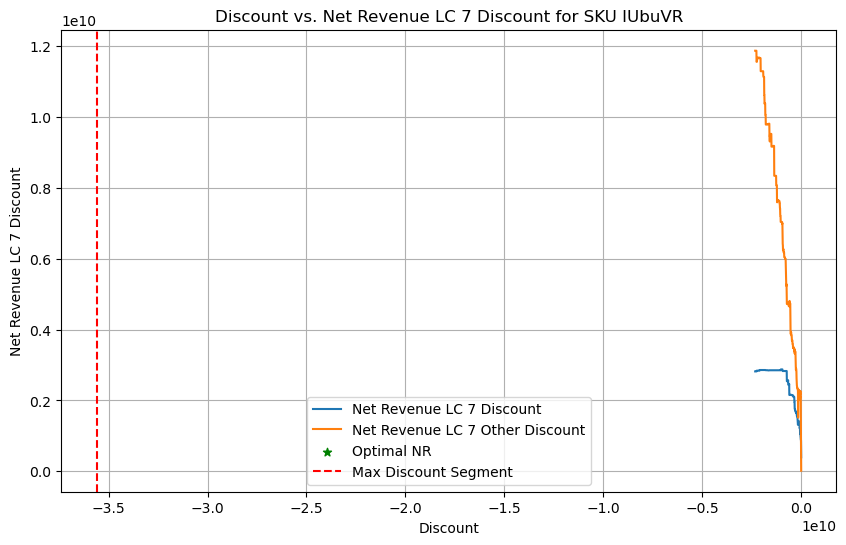

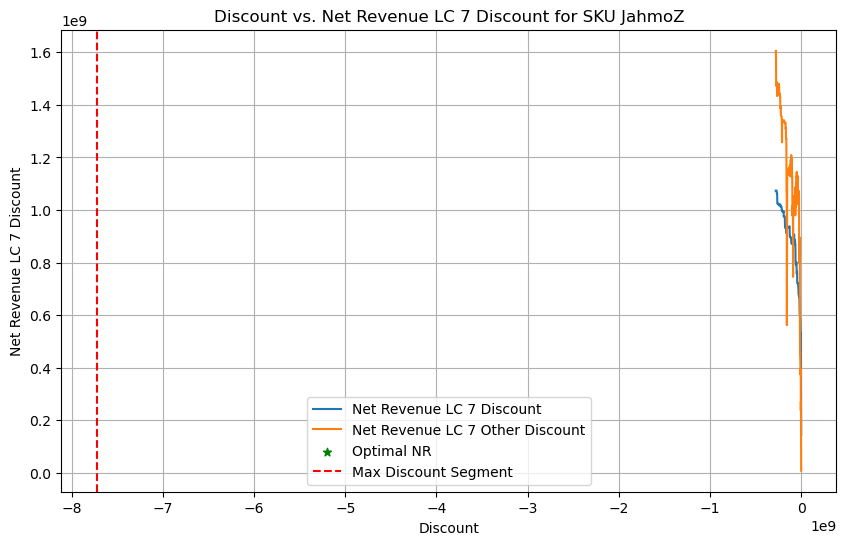

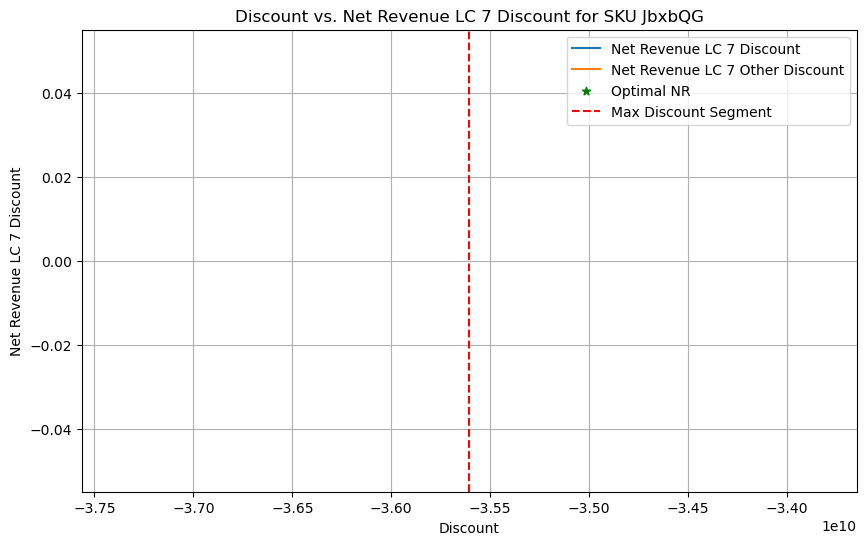

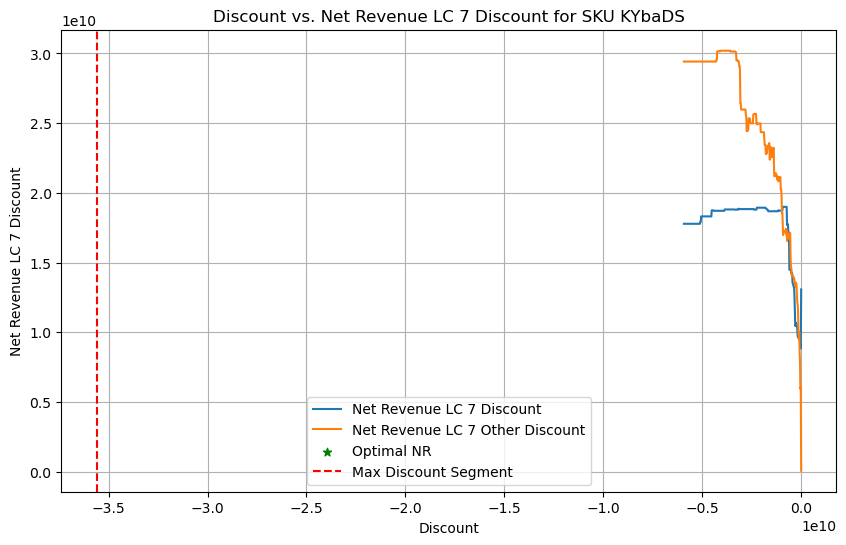

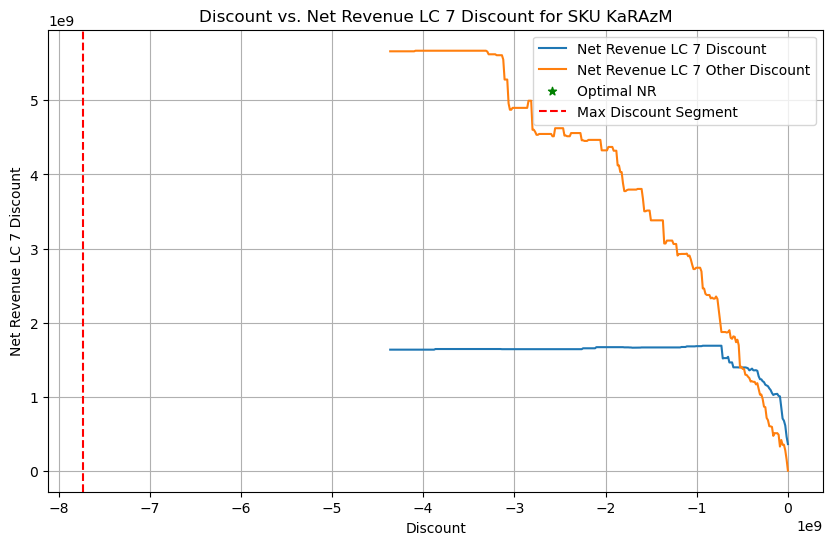

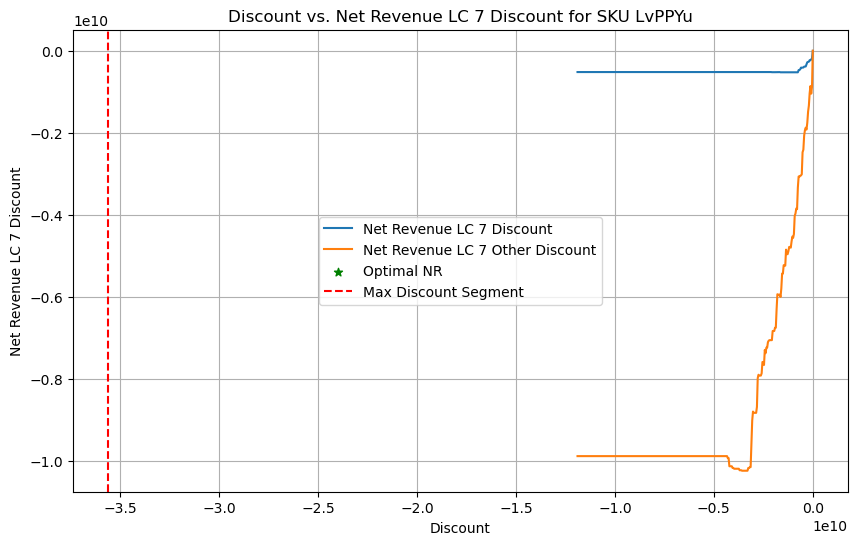

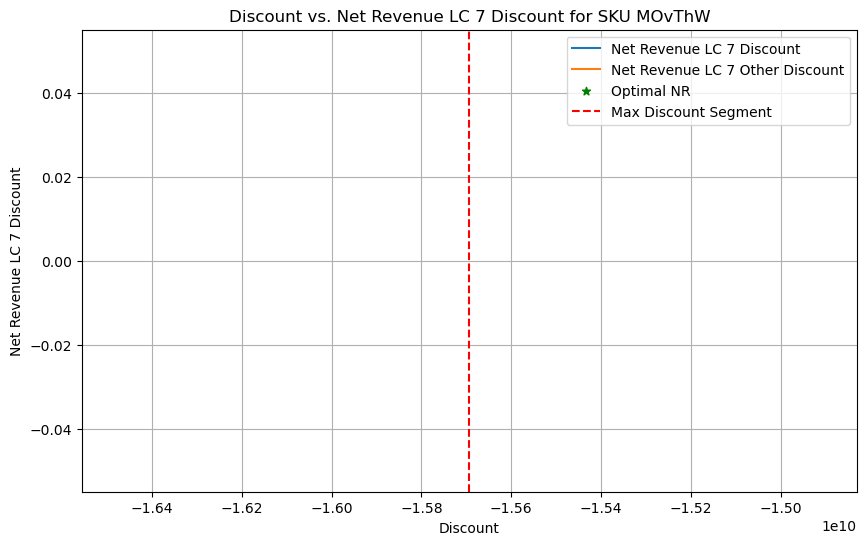

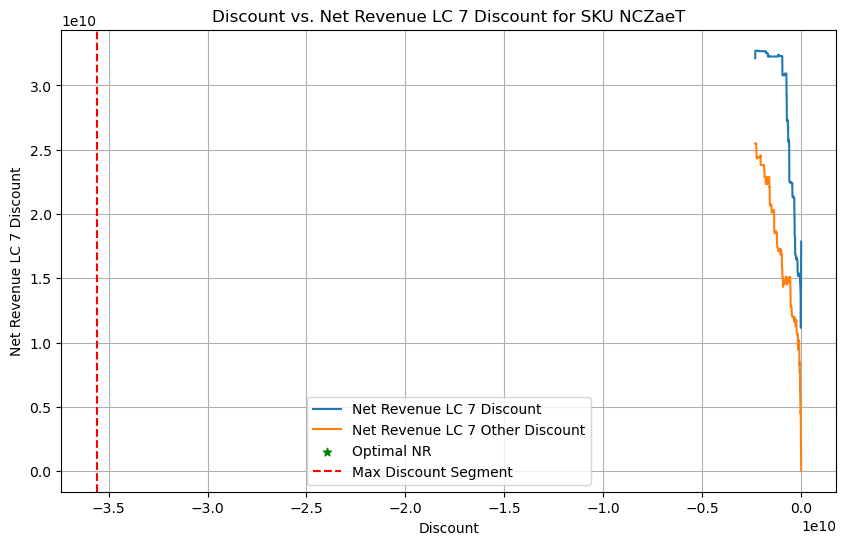

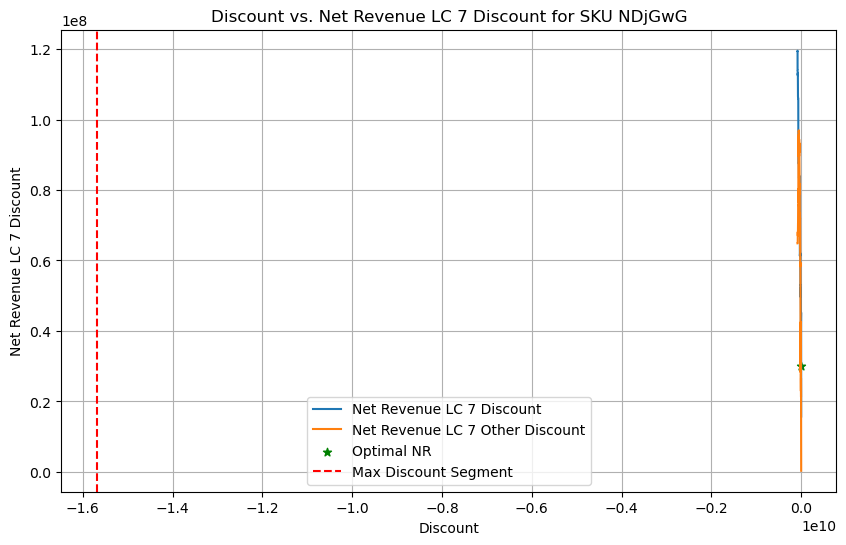

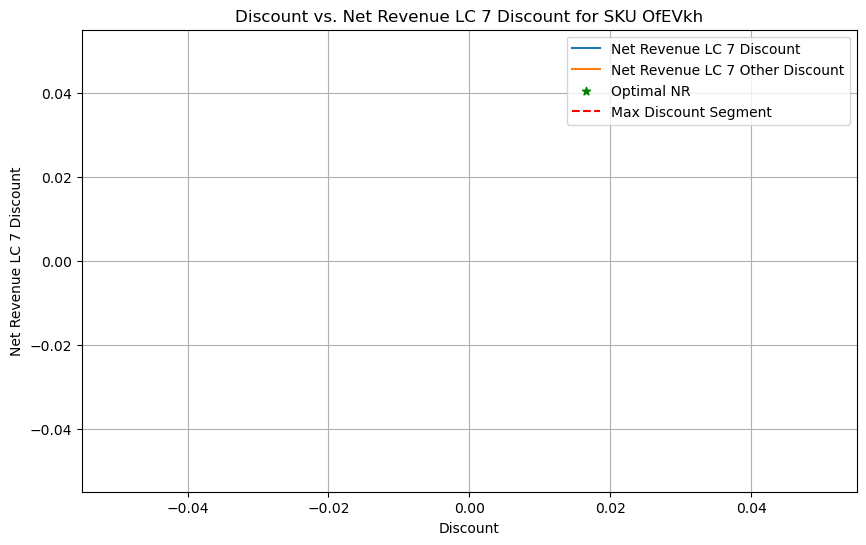

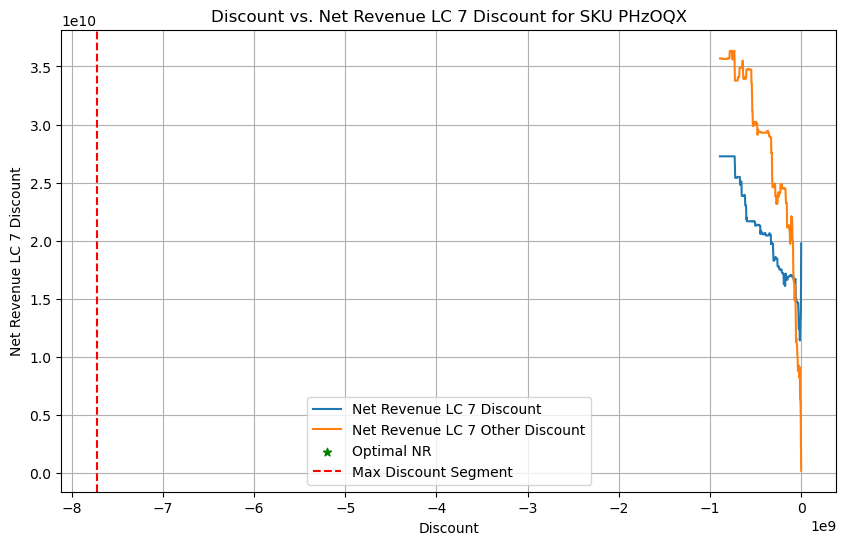

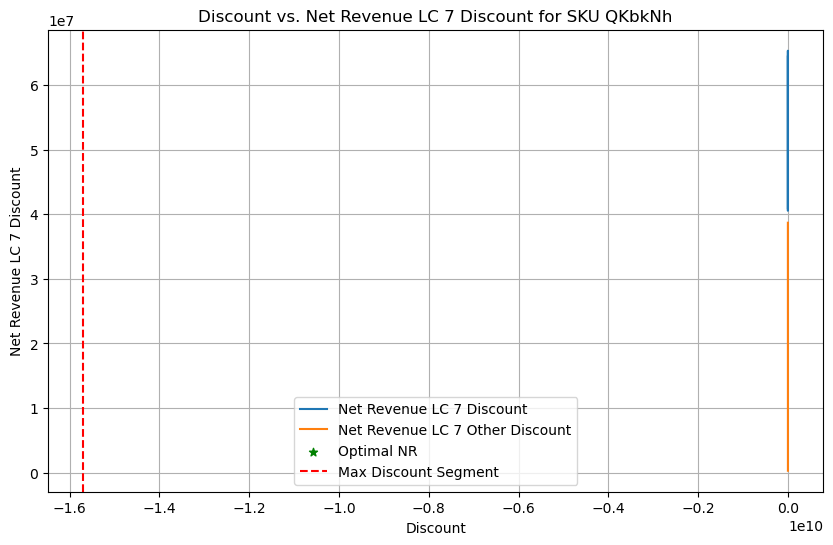

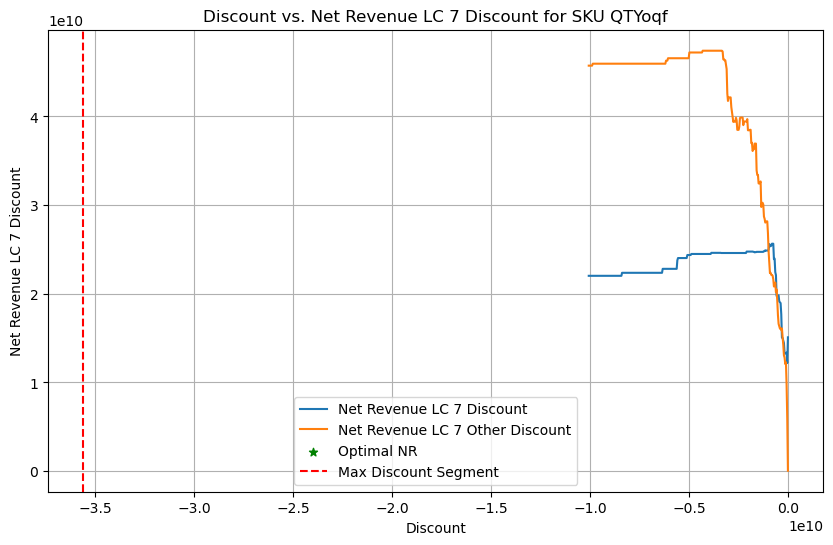

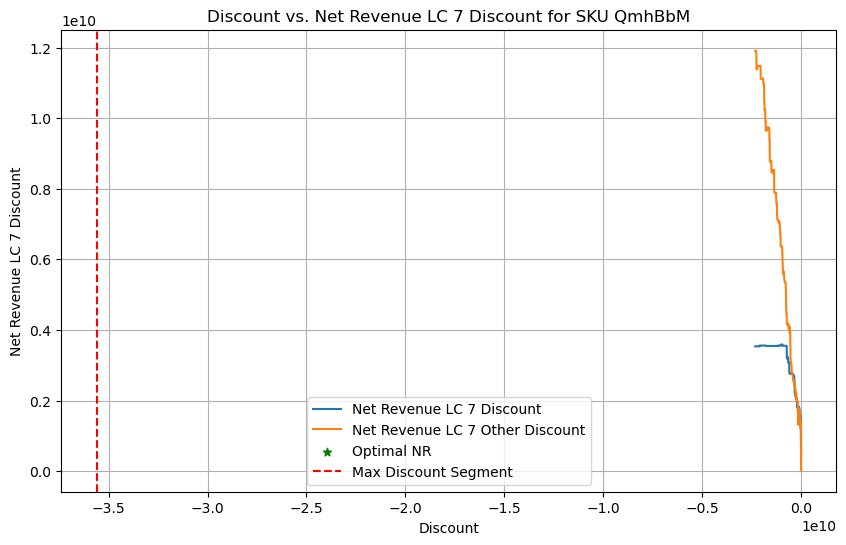

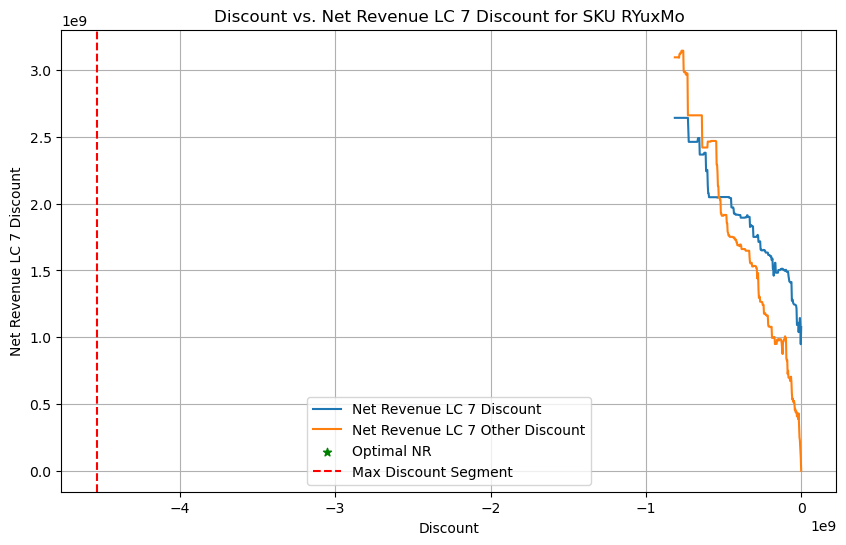

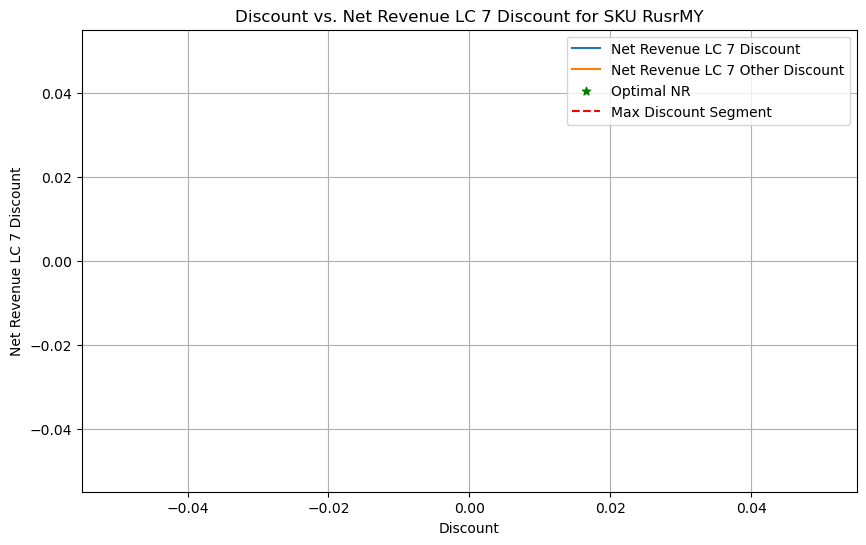

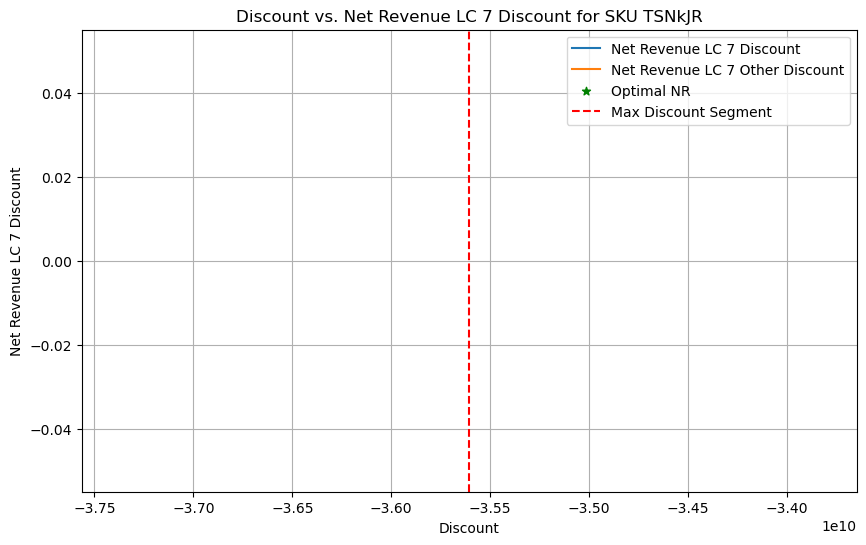

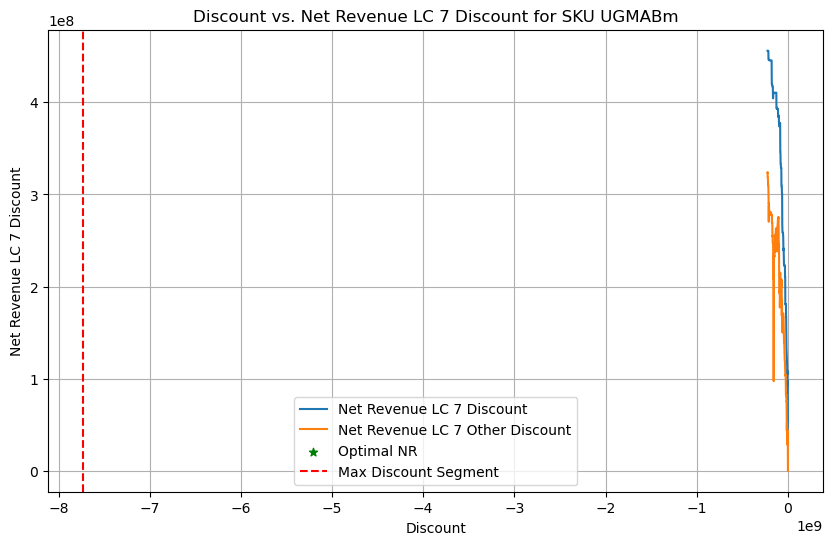

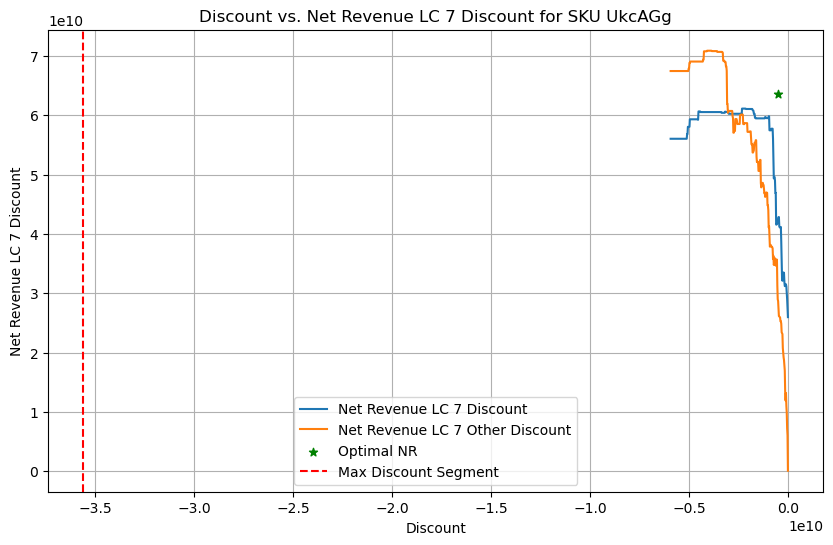

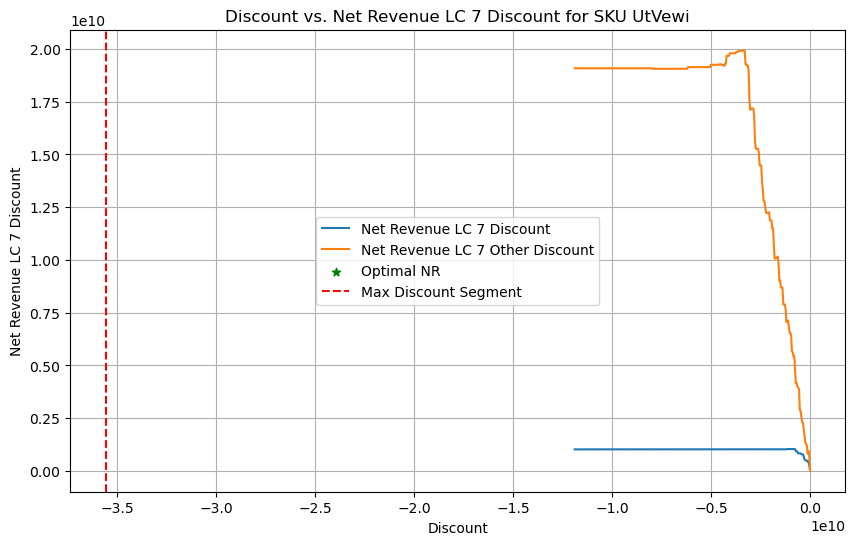

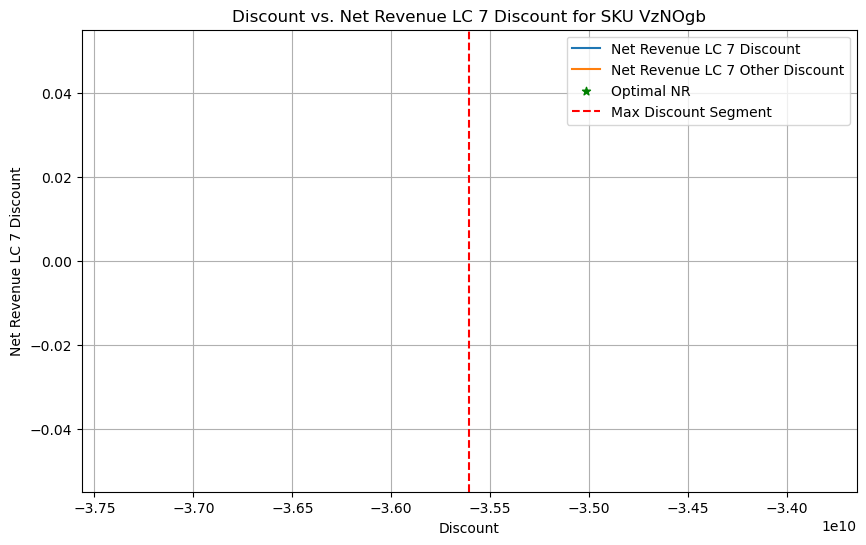

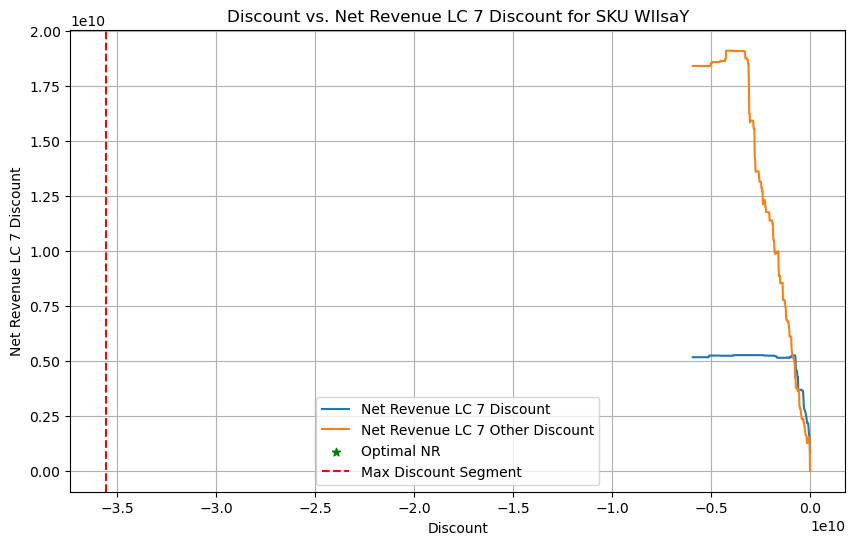

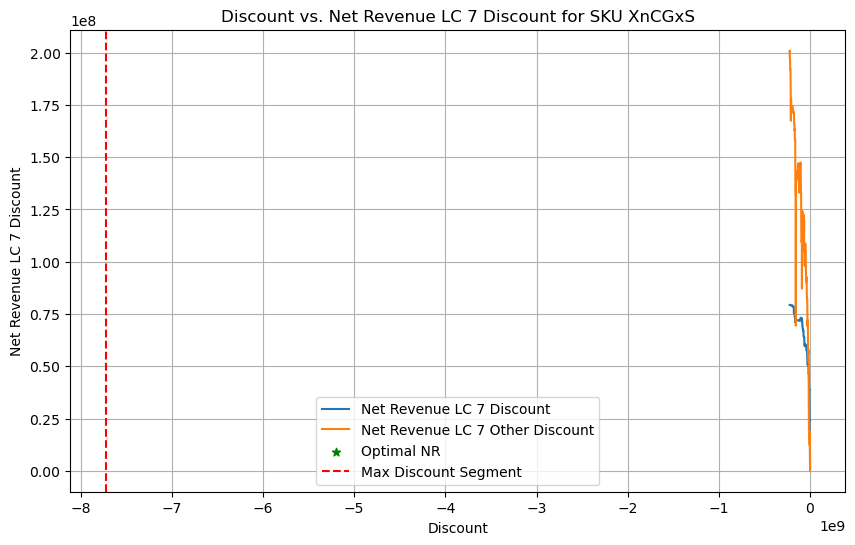

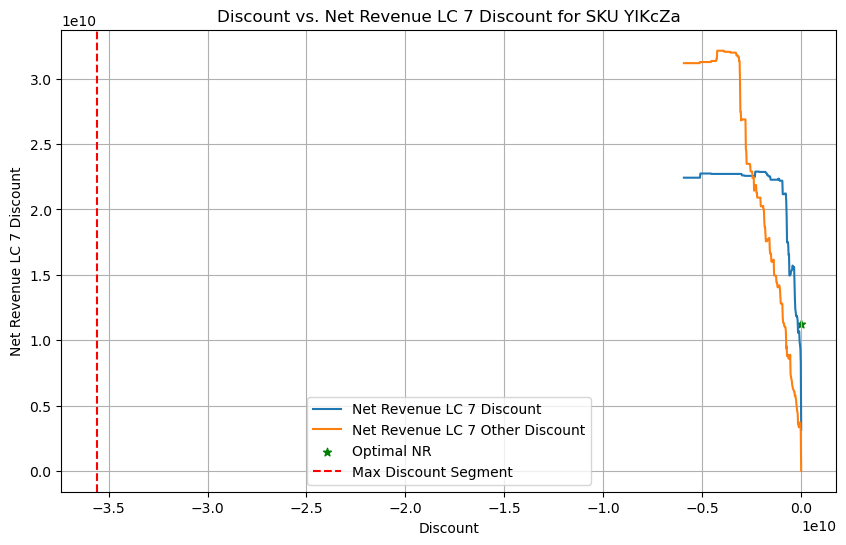

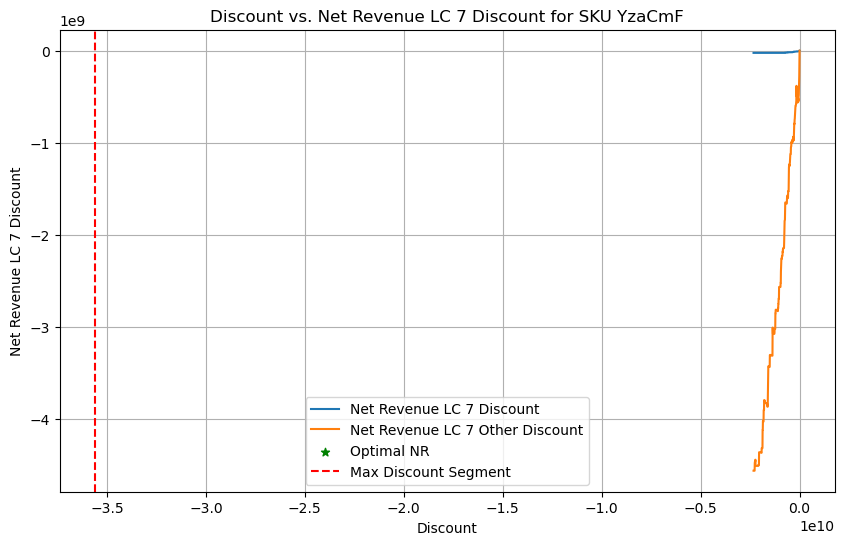

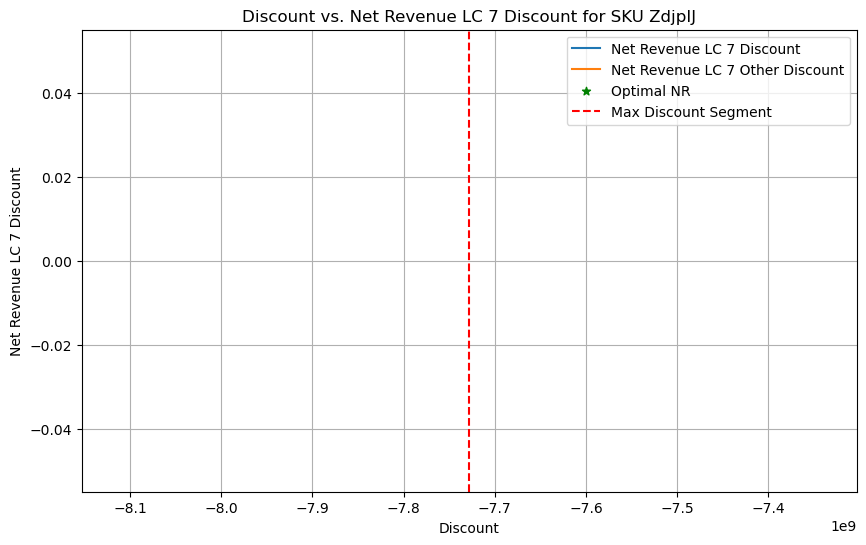

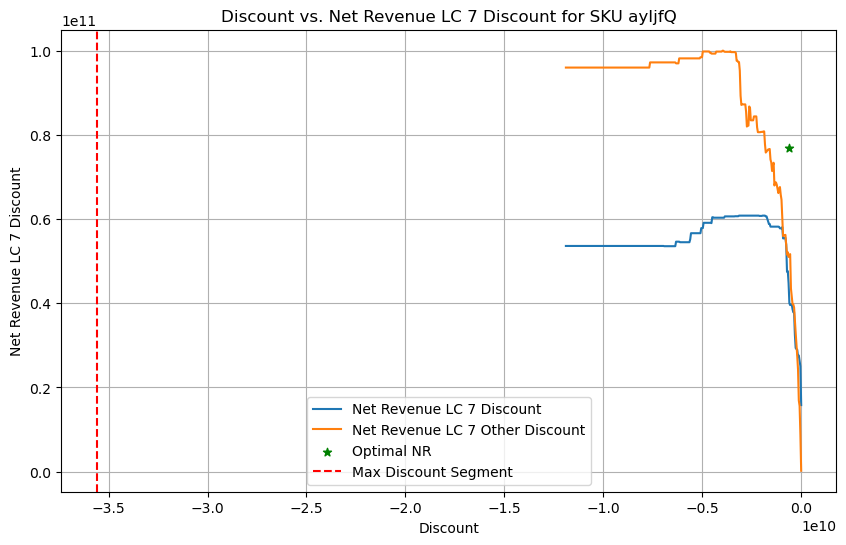

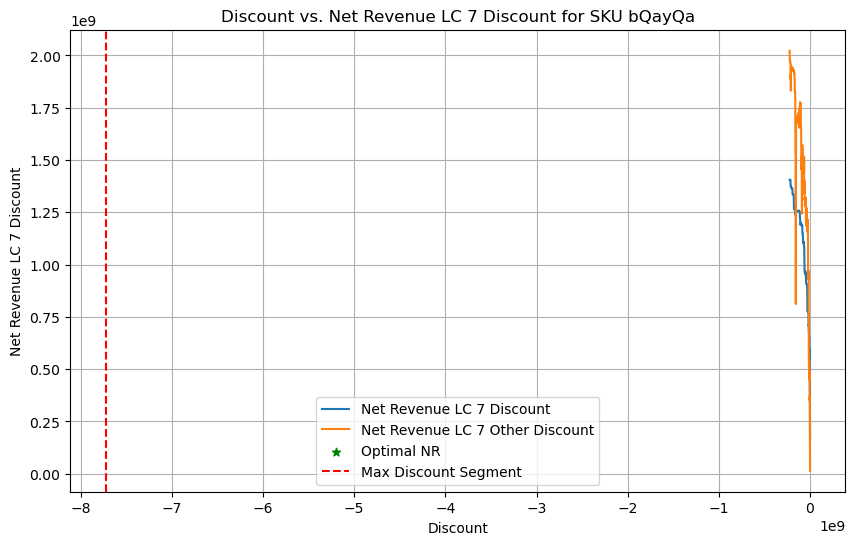

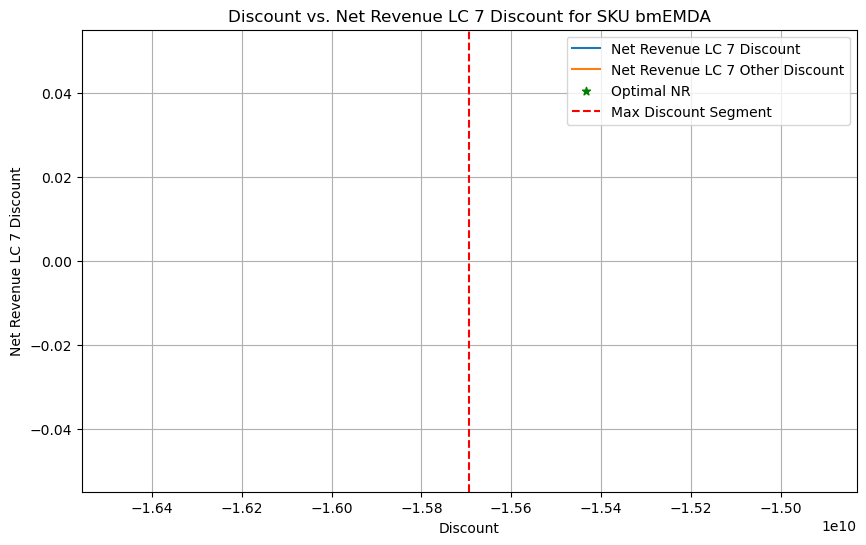

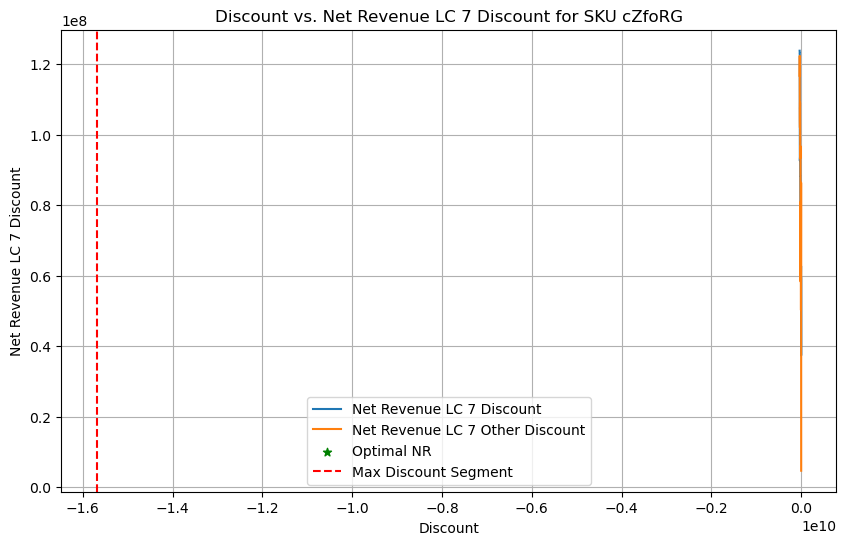

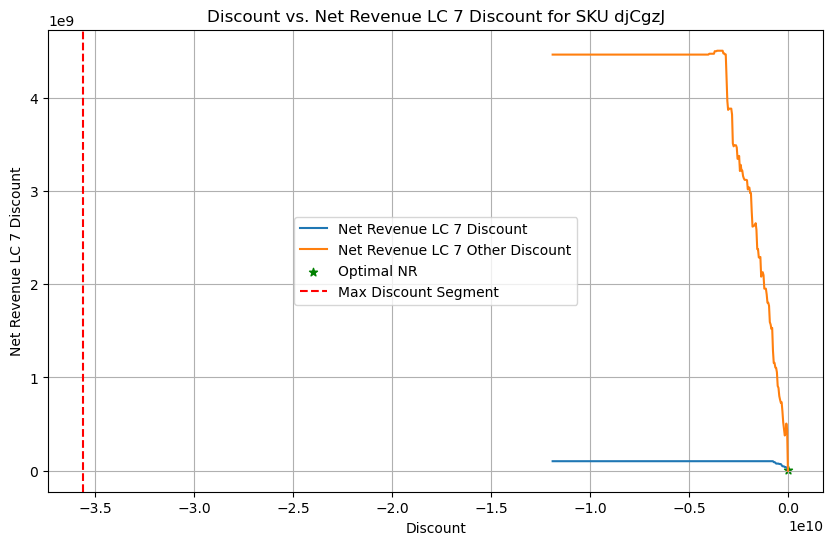

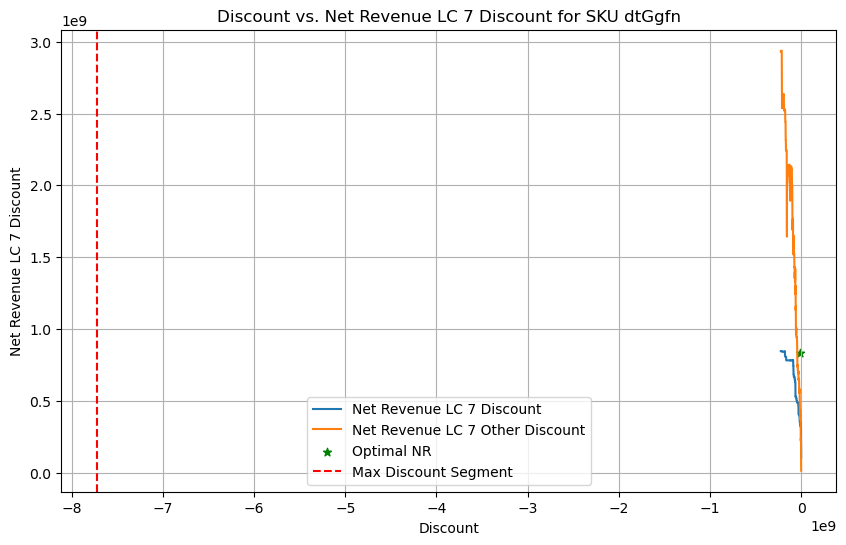

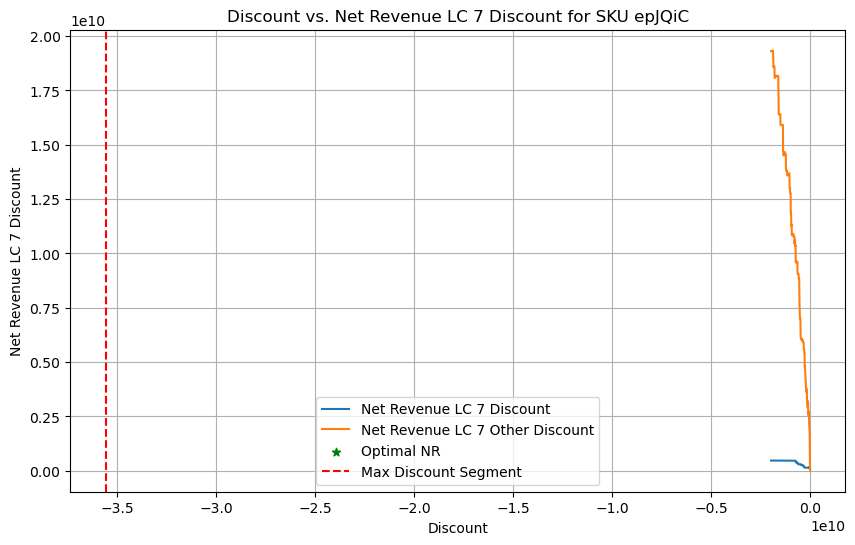

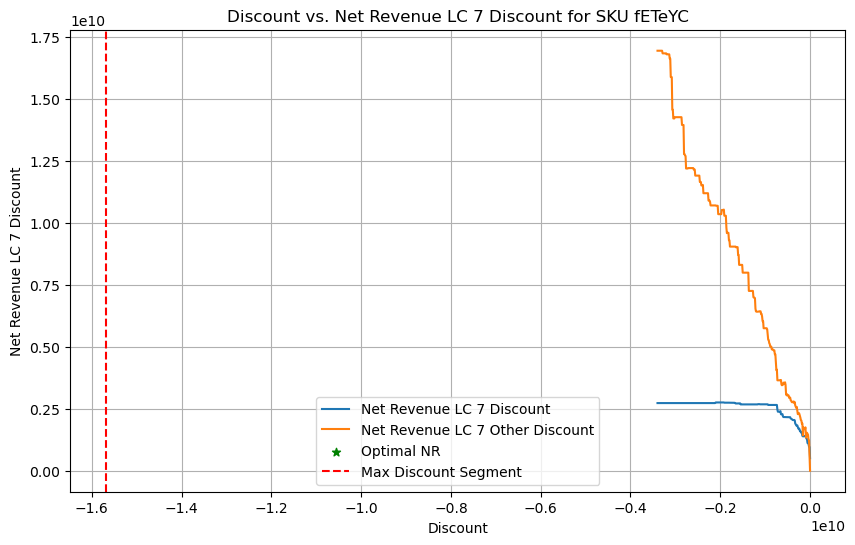

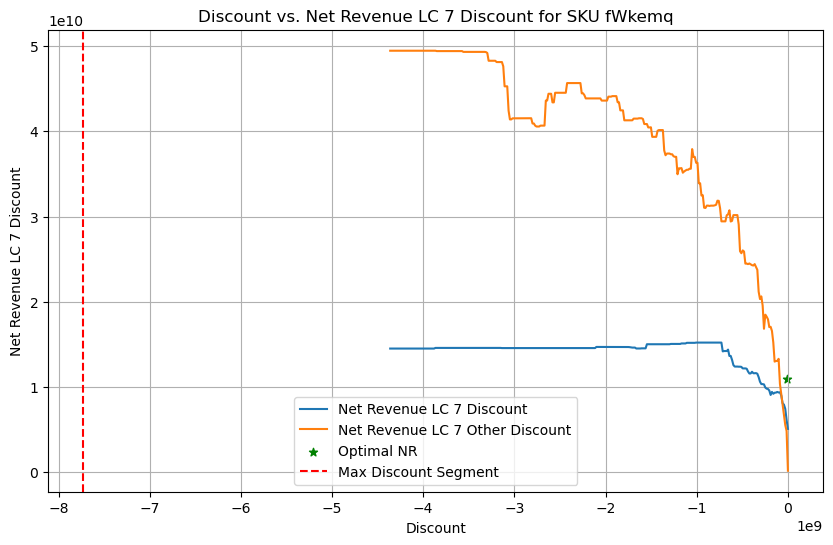

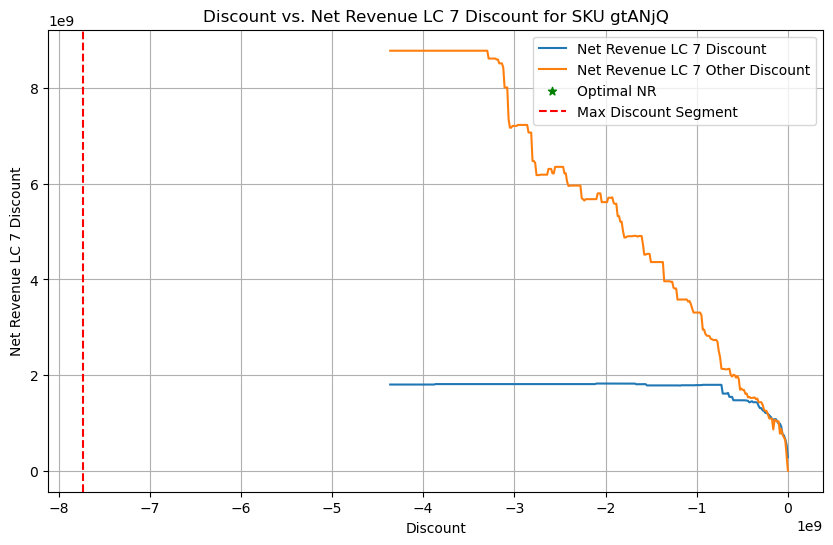

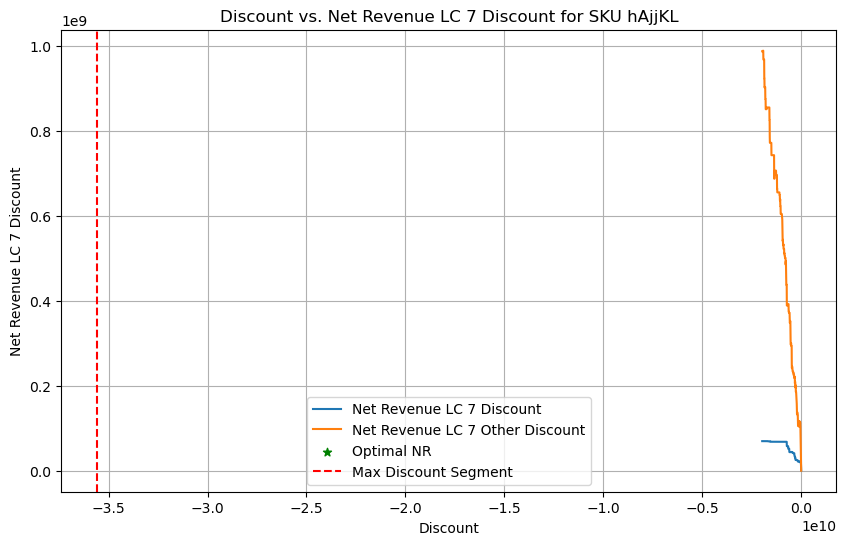

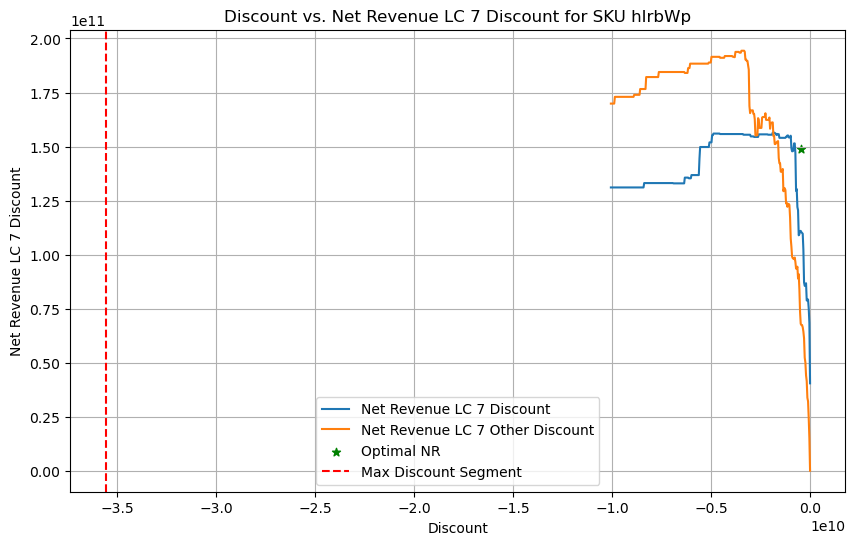

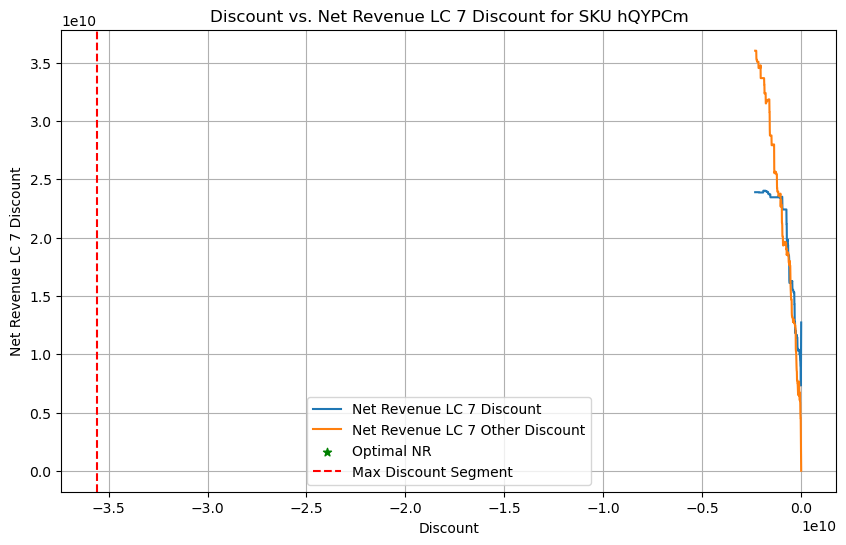

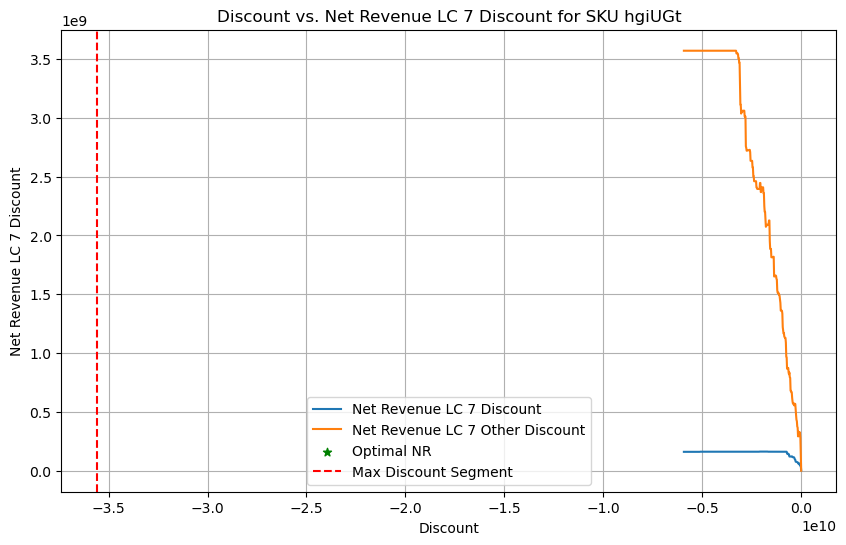

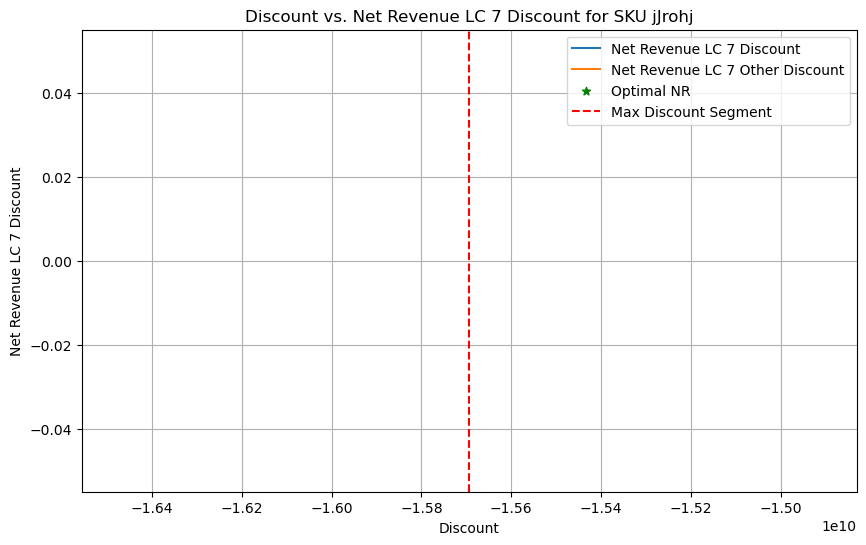

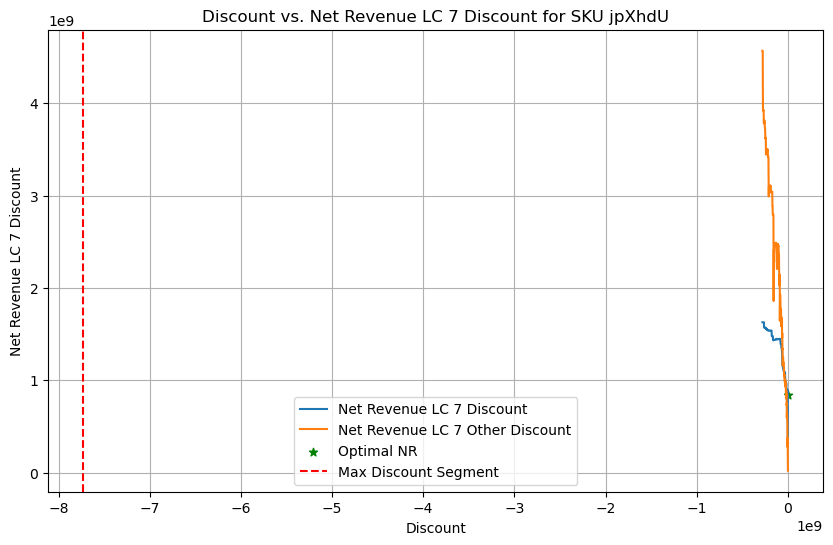

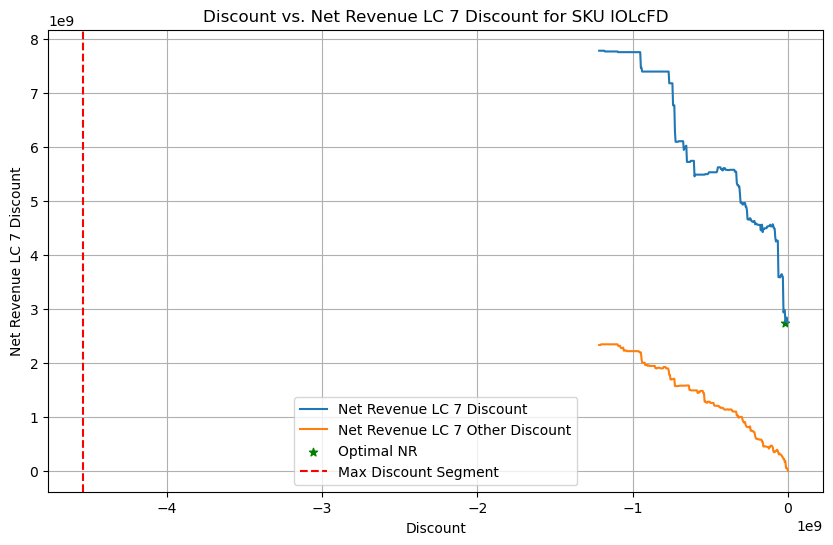

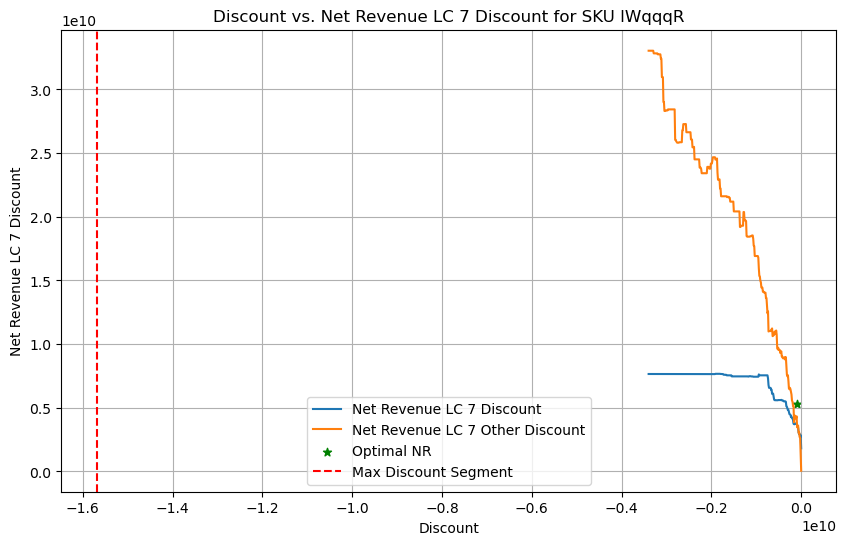

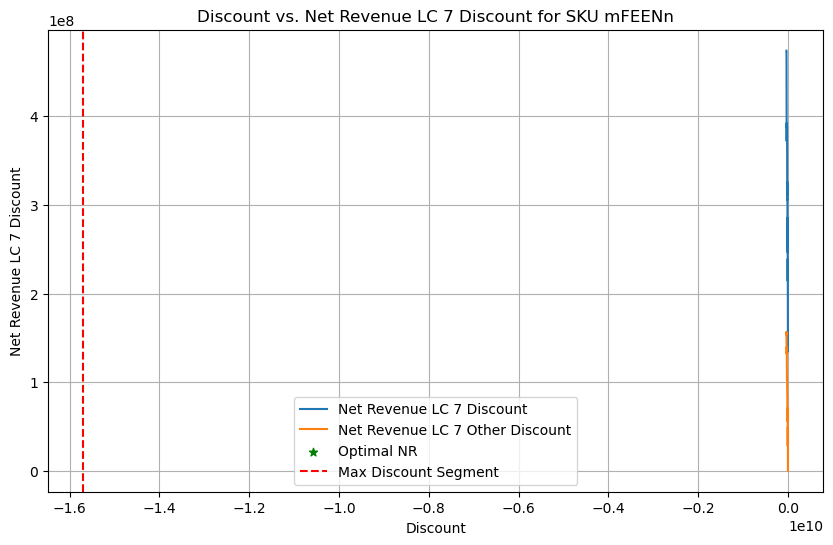

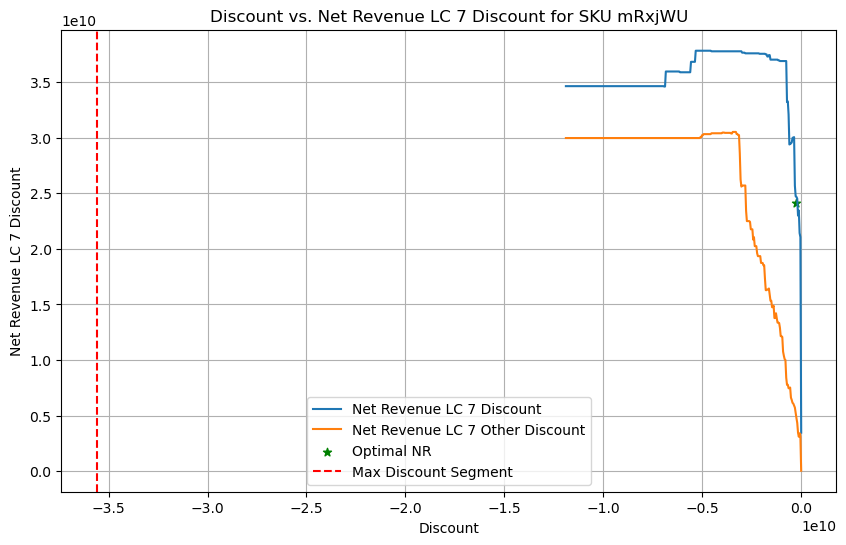

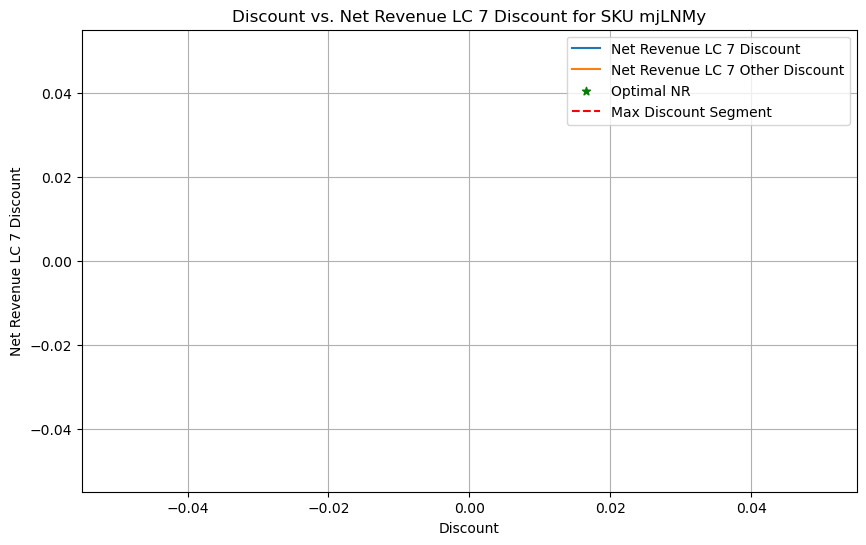

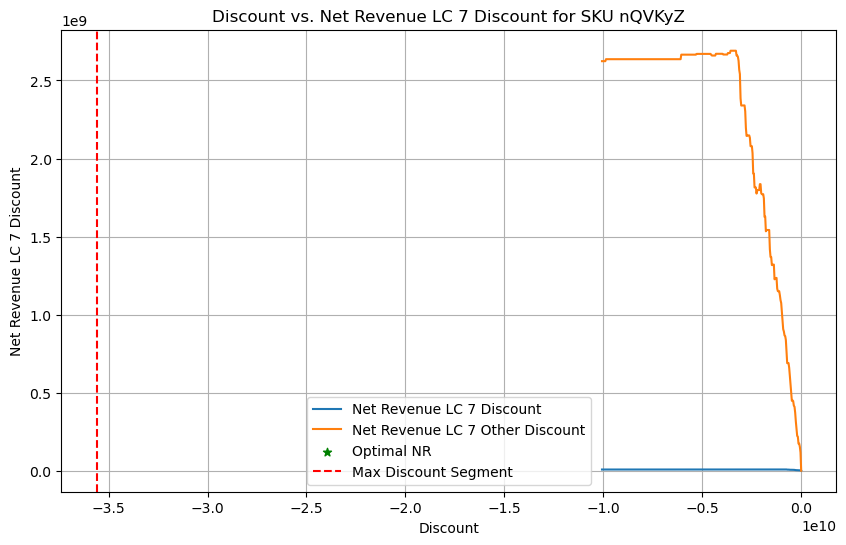

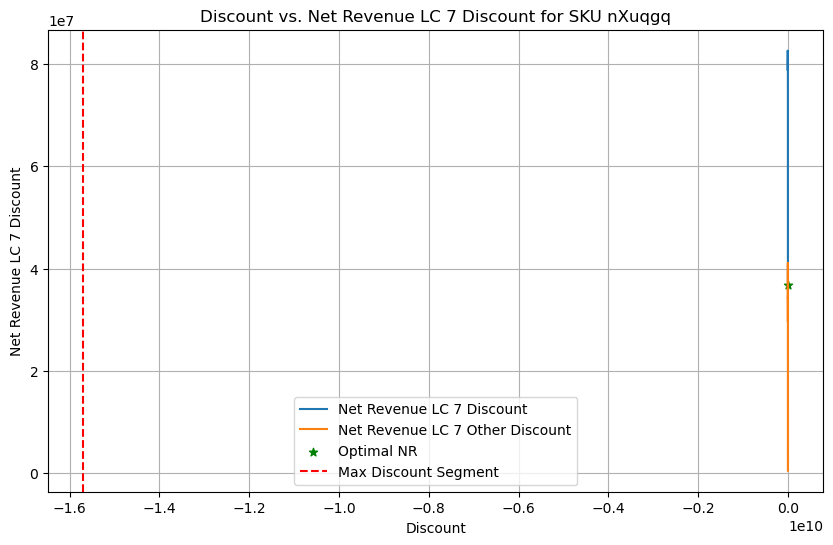

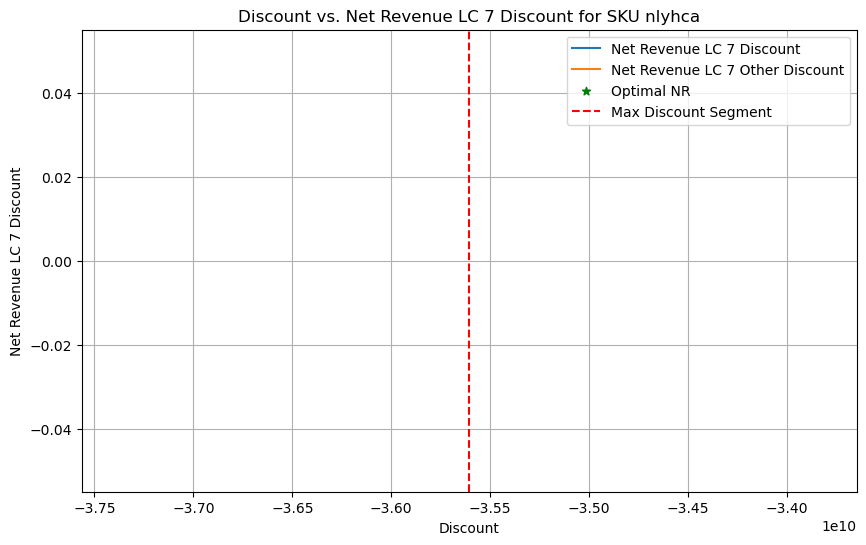

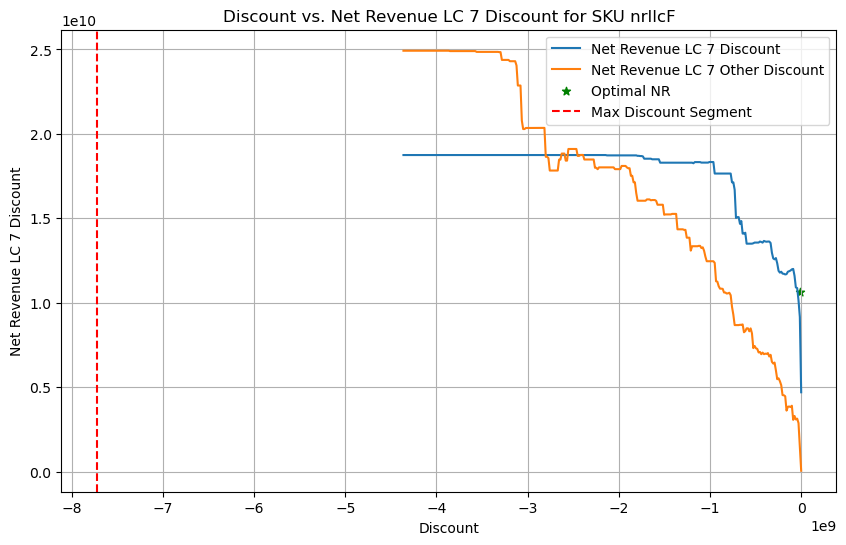

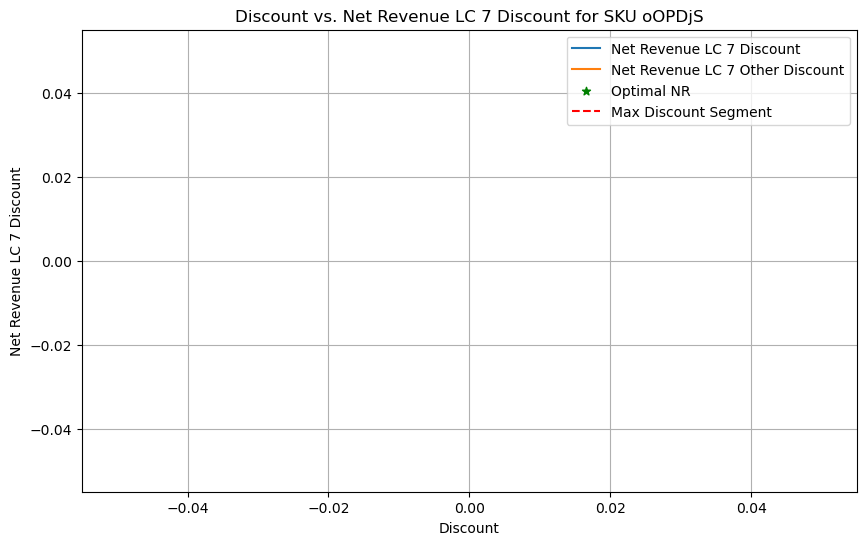

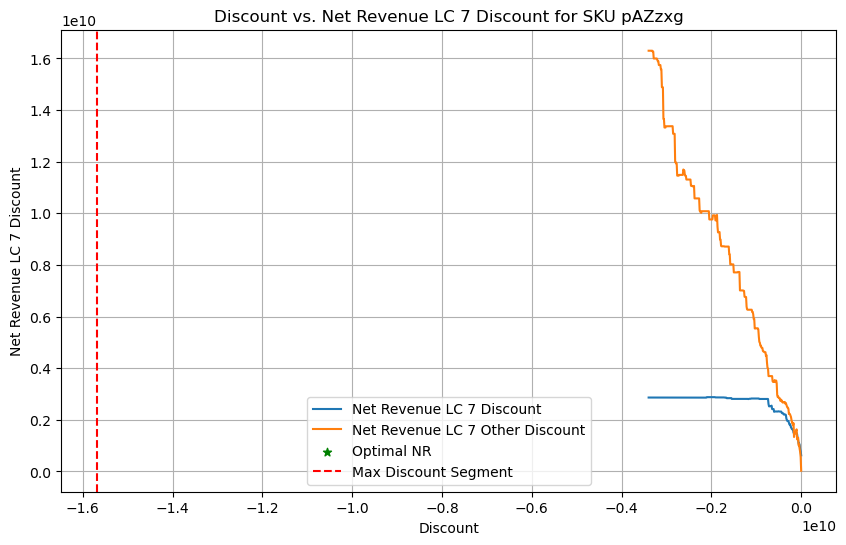

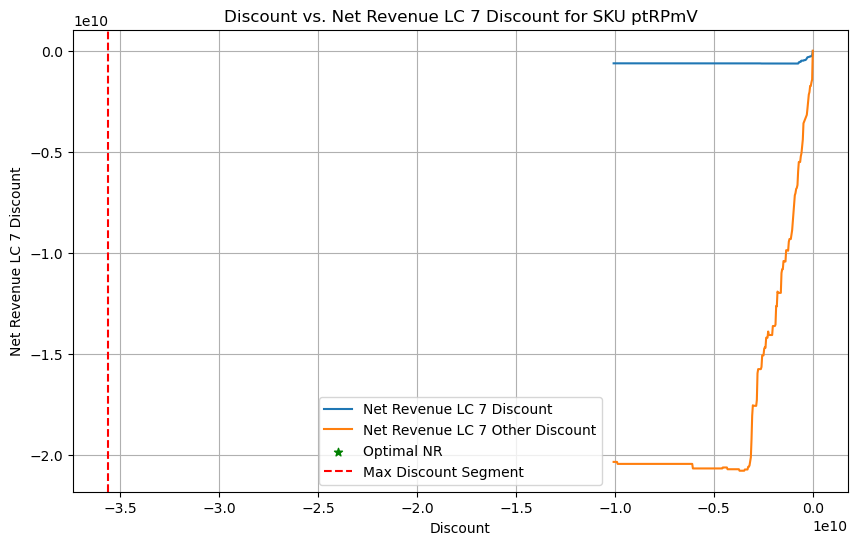

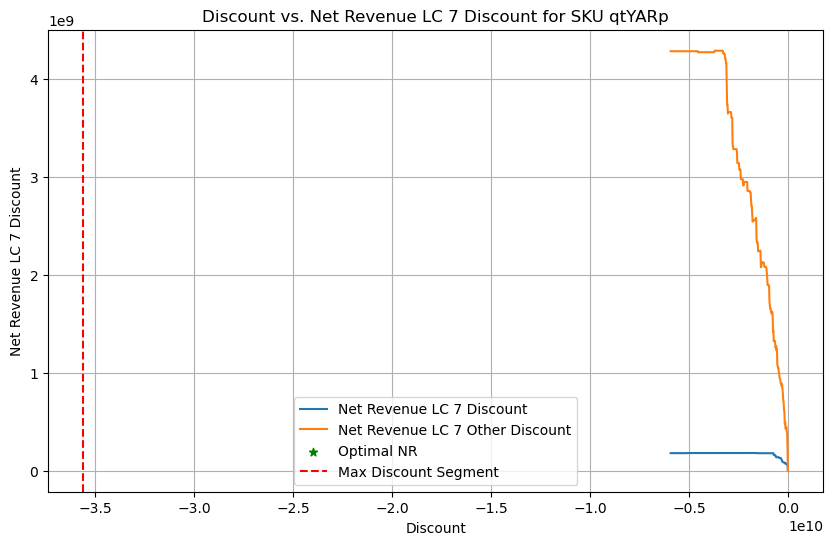

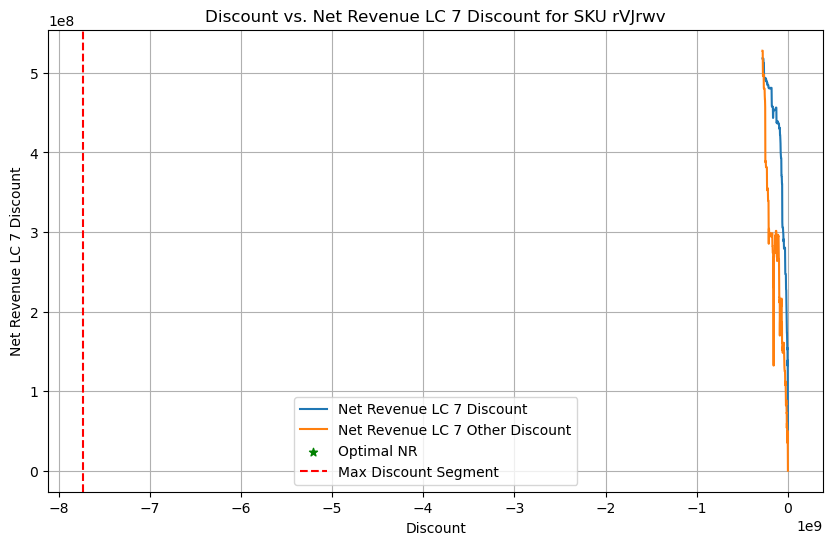

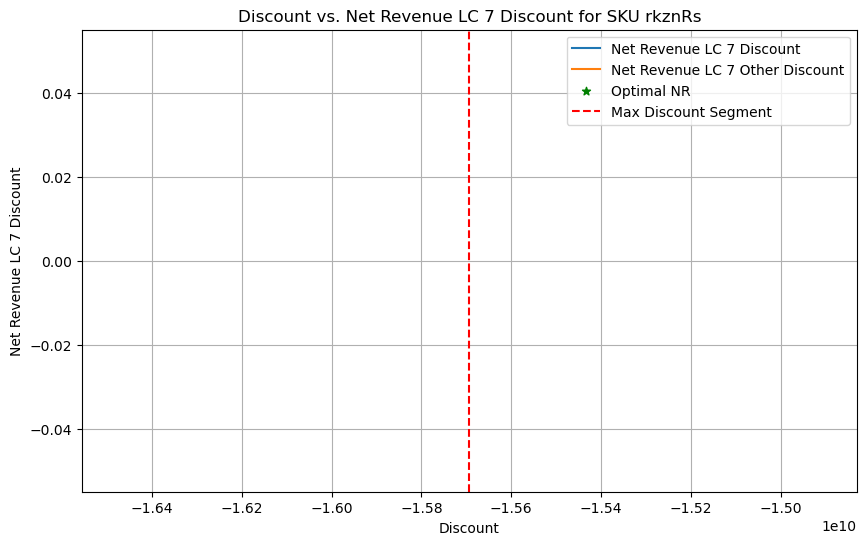

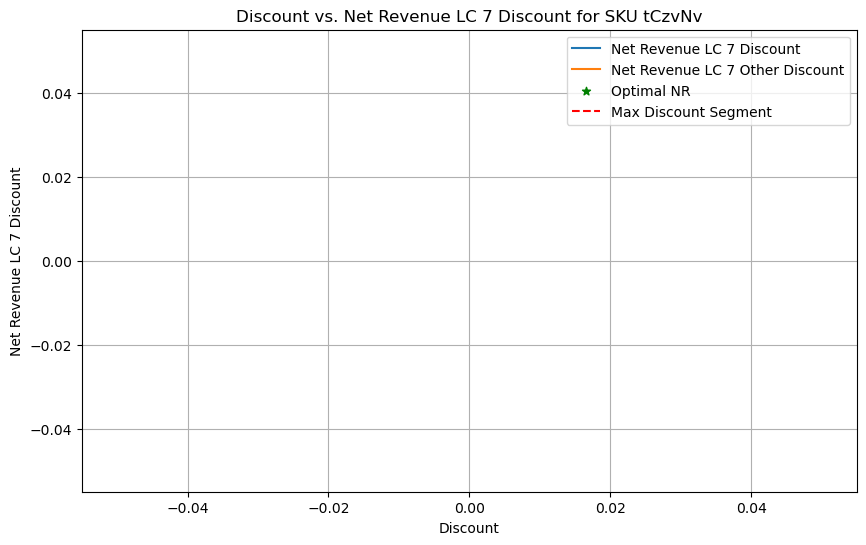

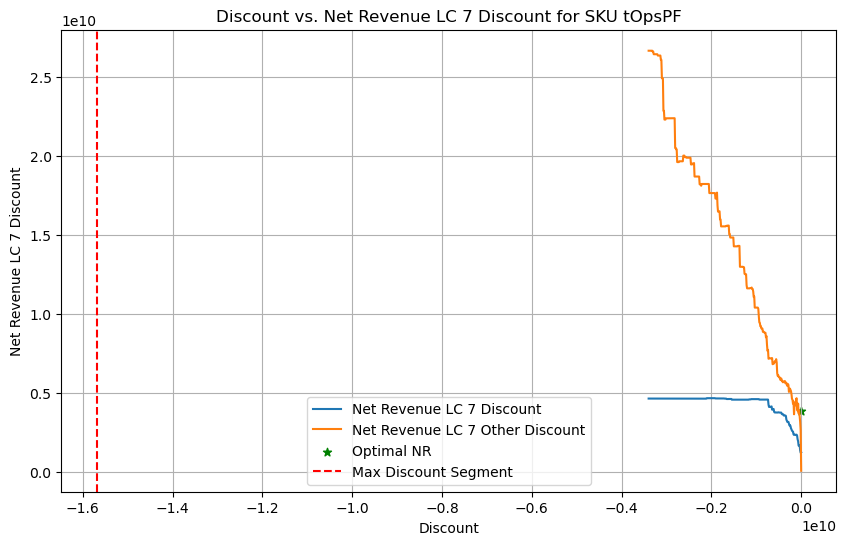

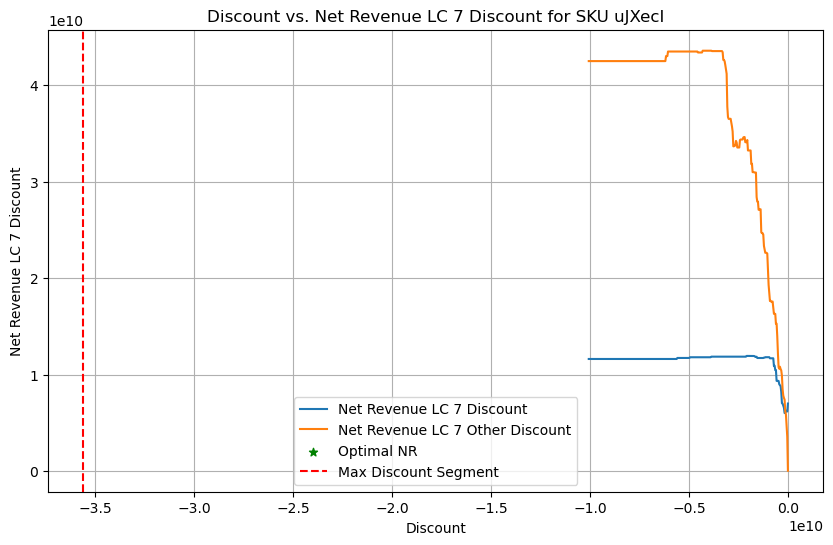

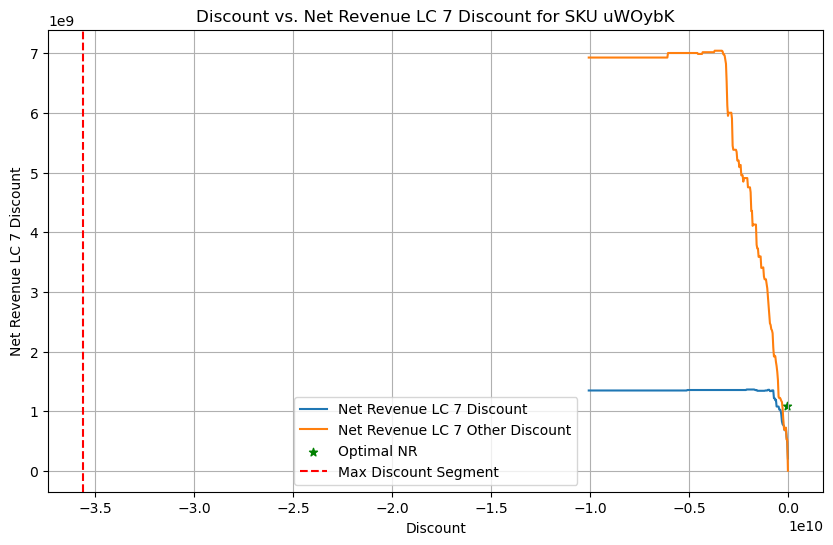

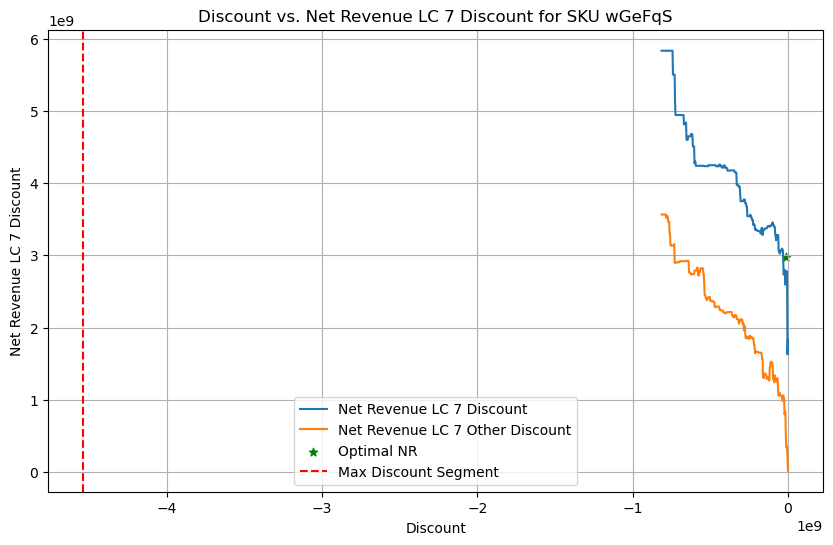

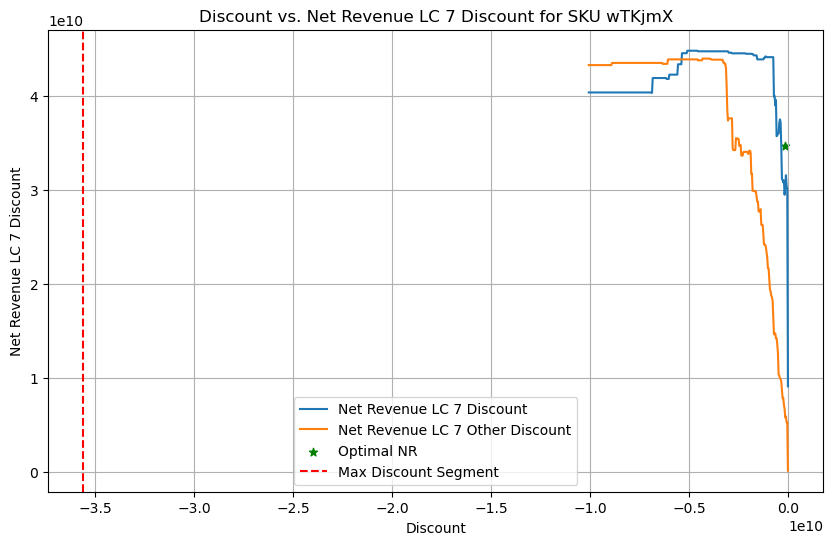

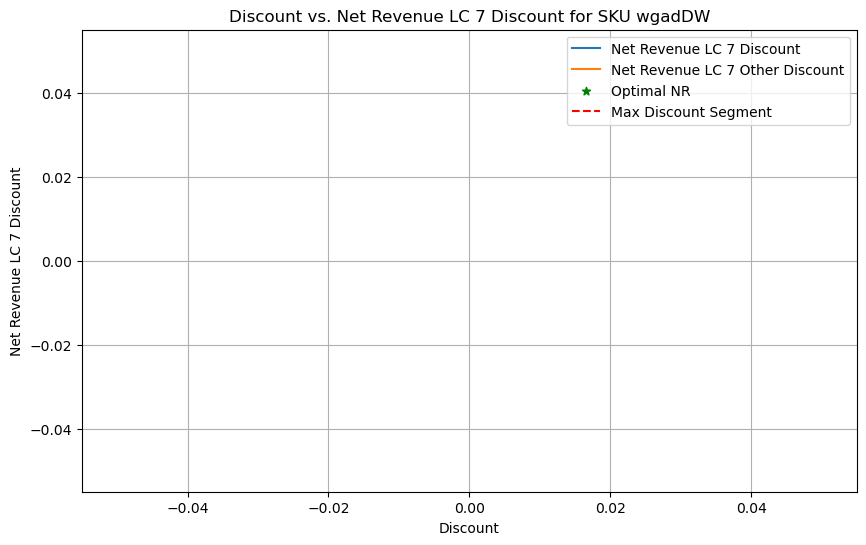

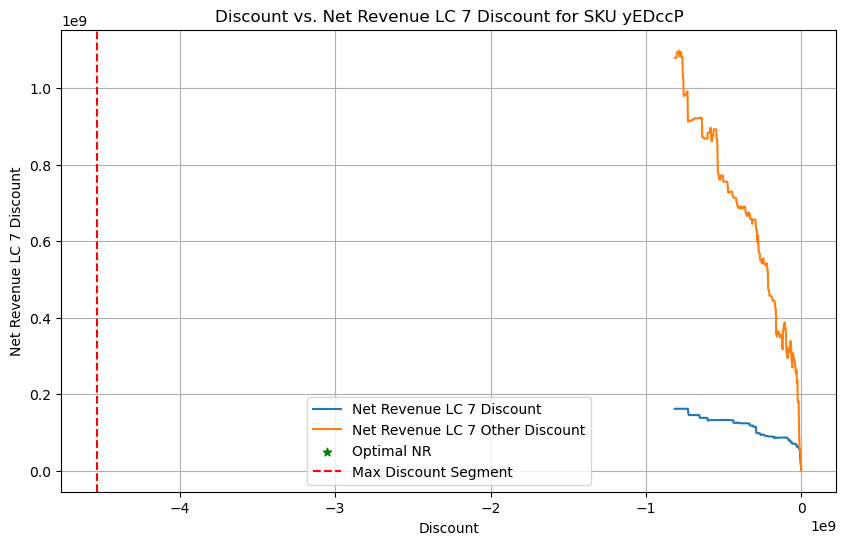

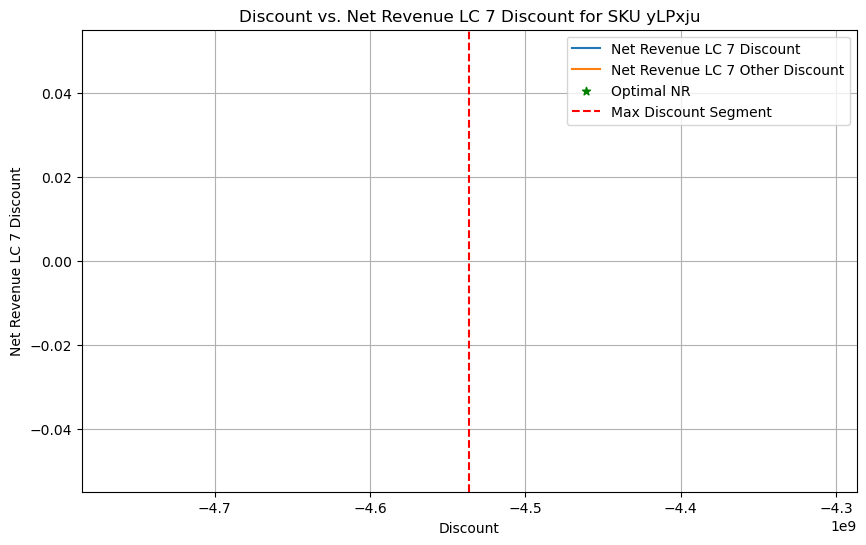

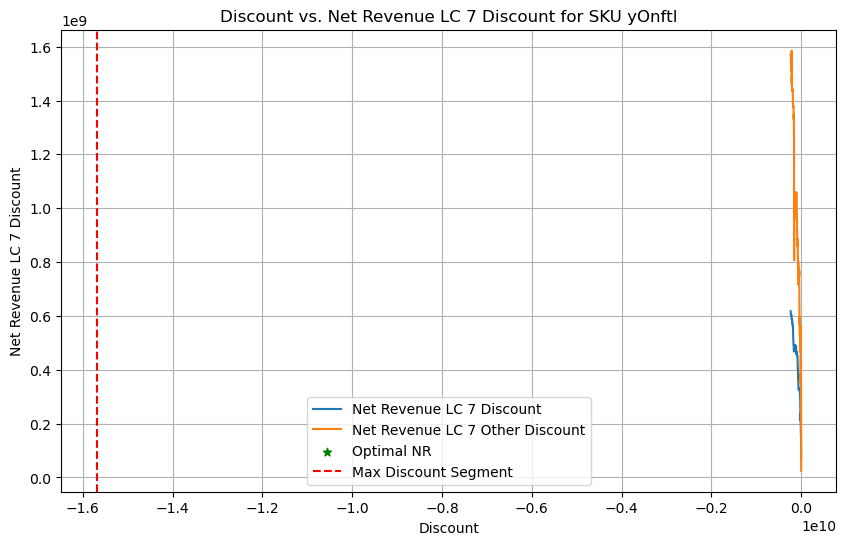

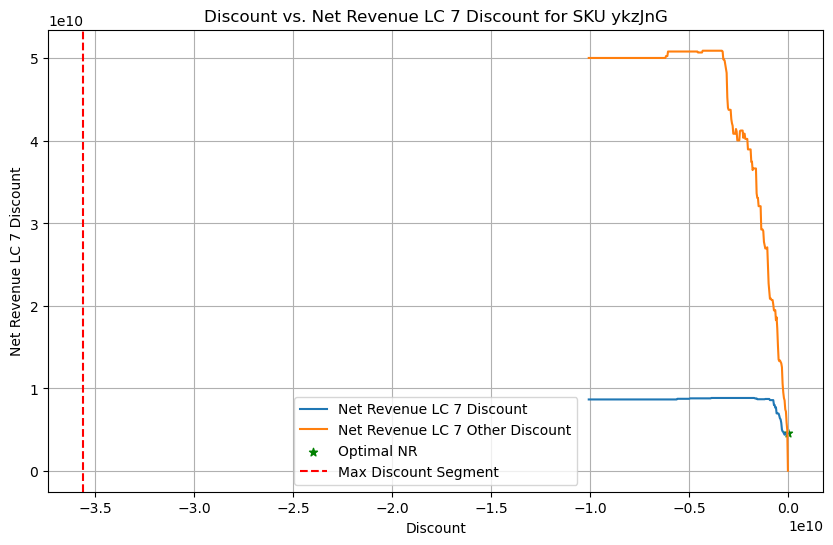

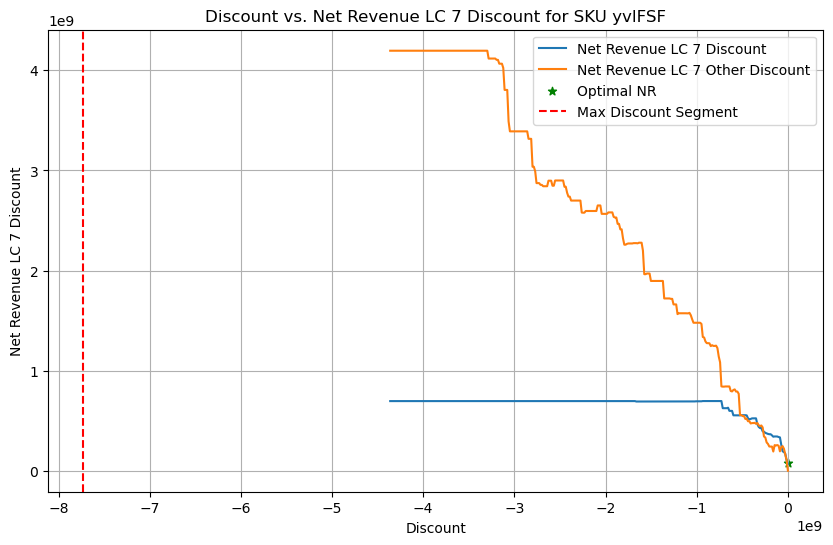

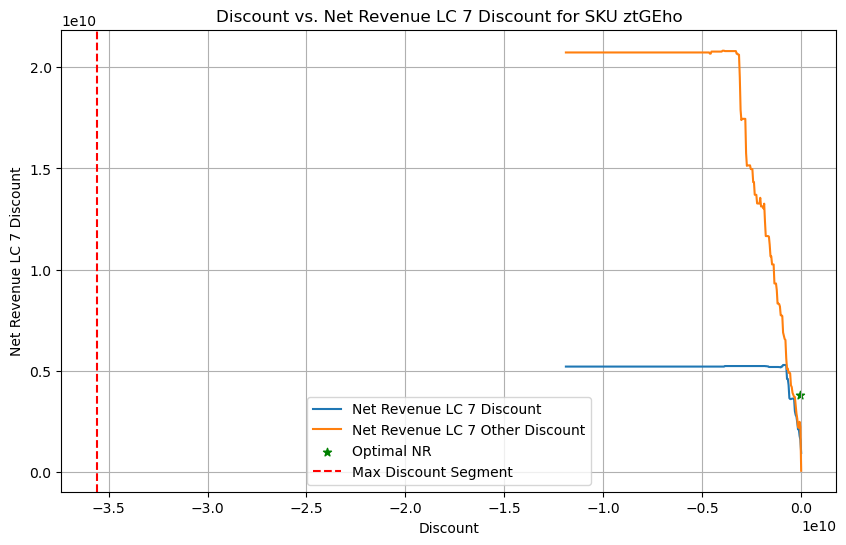

In [59]:
for sku in sku_list:
    # Filter the data for SKU current
    barrier_df4= barrier_df3[barrier_df3.SKU == sku]
    sku_filter = output_format_month_7['SKU'] == sku
    filtered_df = output_format_month_7[sku_filter]

    discount = barrier_df4['discount']
    net_revenue_discount = barrier_df4['Net_Revenue_LC_6_discount']
    net_revenue_other_discount = barrier_df4['Net_Revenue_LC_6_other_discount']
    Optimal_Net_Revenue = filtered_df['Optimal_Net_Revenue']
    optimal_amount_discount = filtered_df['Optimal_Promotional_Discount'] + filtered_df['Optimal_Other_Discount']

    plt.figure(figsize=(10, 6))
    plt.plot(discount, net_revenue_discount, label='Net Revenue LC 7 Discount')
    plt.plot(discount, net_revenue_other_discount, label='Net Revenue LC 7 Other Discount')

    plt.scatter(optimal_amount_discount, Optimal_Net_Revenue, c='green', marker='*', label='Optimal NR')
    max_discount_segment = barrier_df4[barrier_df4['SKU'] == sku]['max_discount_segment'].values[0]
    plt.axvline(x=max_discount_segment, color='red', linestyle='--', label='Max Discount Segment')
    plt.xlabel('Discount')
    plt.ylabel('Net Revenue LC 7 Discount')
    plt.title(f'Discount vs. Net Revenue LC 7 Discount for SKU {sku}')
    plt.legend()
    plt.grid()
    plt.show()